In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')
save_loc_out = 'Trained_Params_70_50_day5.npz'

Counter({3: 131304,
         4: 134757,
         5: 133326,
         6: 127225,
         0: 131584,
         1: 132744,
         2: 131599})

In [3]:
weekday_lookup = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}

In [35]:
Event_Type_Lookup = {}
for i in range(0, len(full_data)):
    key = full_data.CALL_TYPE_FINAL[i]
    val = full_data.CALL_TYPE_FINAL_D[i]
    Event_Type_Lookup.setdefault(key, [])
    if val not in Event_Type_Lookup[key]:
        Event_Type_Lookup[key].append(val)

KeyboardInterrupt: 

In [40]:
top_labels = full_data.CALL_TYPE_FINAL.sort_values().value_counts()[:20]
top_labels

766A      90331
765A      86018
790A      73456
773A      57410
790B      46434
792B      45329
768A      42483
792A      37433
767A      31061
770A      27201
770B      26876
775A      23420
767B      21126
772A      18392
790C      15255
790ALR    15233
771A      14679
774B      13939
791A      12723
792C      11709
Name: CALL_TYPE_FINAL, dtype: int64

In [4]:
end = len(full_data)- 10000
start = 0
data = full_data[start:end]
data.reset_index(drop=True, inplace=True)
#reasonable results
#all_events = PointProcessTrain(data, w = [.14, 1, .03],final_param_save_loc = save_loc_out, xgridsize = 70, ygridsize = 50, track_granularity=500) 
breathing = PointProcessTrain(data, w = [24, 4, 1],final_param_save_loc = save_loc_out, xgridsize = 70, ygridsize = 50, track_granularity=500) 
#all_events = PointProcessTrain(data, w = [24, 4, 1],final_param_save_loc = save_loc_out, xgridsize = 70, ygridsize = 50, lam_memory=1000) 



In [6]:
breathing.train()

0.5832604257801108 percent trained
1.1665208515602217 percent trained
1.7497812773403325 percent trained
2.3330417031204433 percent trained
2.916302128900554 percent trained
3.499562554680665 percent trained
4.082822980460776 percent trained
4.666083406240887 percent trained
5.2493438320209975 percent trained
5.832604257801108 percent trained
6.41586468358122 percent trained
6.99912510936133 percent trained
7.582385535141441 percent trained
8.165645960921552 percent trained
8.748906386701663 percent trained
9.332166812481773 percent trained
9.915427238261884 percent trained
10.498687664041995 percent trained
11.081948089822106 percent trained
11.665208515602217 percent trained
12.248468941382328 percent trained
12.83172936716244 percent trained
13.41498979294255 percent trained
13.99825021872266 percent trained
14.581510644502771 percent trained
15.164771070282882 percent trained
15.748031496062993 percent trained
16.331291921843103 percent trained
16.914552347623214 percent trained
17

In [7]:
plt.rcParams.update({'font.size': 10, 'text.color' : "black",
                     'axes.labelcolor' : "black"})

In [8]:
breathing.param_examine()

Look at theta: 
for i in range(0, self._K):
plt.plot(np.transpose(self._theta_track)[i][1:], label='w = ' + str(self._w[i]))
plt.title('data points vs. theta')
plt.legend()
plt.show()
Look at mu + F: 
all_sum = np.zeros(len(self._mu_track))
for i in range(0, len(all_sum)):
all_sum[i] = sum(sum(self._mu_track[i]))+sum(sum(sum(self._F_track[i])))
plt.plot(all_sum[1:])
plt.title('sum of all background rates & triggering funcions')
plt.show()
Hour vector sum: 
1.0000000000001097
plt.plot(self._hour, 'b.-')
plt.show()
Day vector sum: 
1.0000000000000004
plt.plot(self._day, 'b.-')
plt.show()


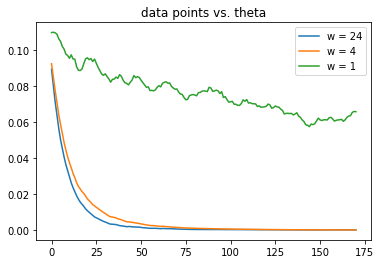

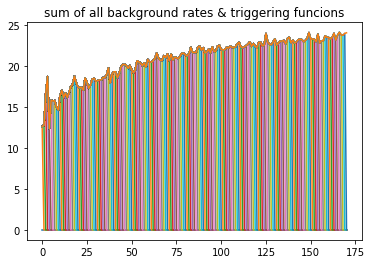

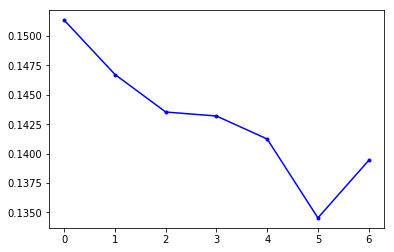

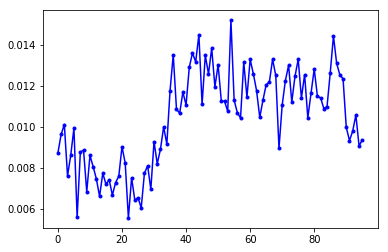

In [9]:
for i in range(0, breathing._K):
    plt.plot(np.transpose(breathing._theta_track)[i][1:], label='w = ' + str(breathing._w[i]))
    plt.title('data points vs. theta')
    plt.legend()
plt.show()
all_sum = np.zeros(len(breathing._mu_track))
for i in range(0, len(all_sum)):
    all_sum[i] = sum(sum(breathing._mu_track[i]))+sum(sum(sum(breathing._F_track[i])))
    plt.plot(all_sum[1:])
    plt.title('sum of all background rates & triggering funcions')
plt.show()
plt.plot(breathing._day, 'b.-')
plt.show()
plt.plot(breathing._hour, 'b.-')
plt.show()

In [10]:
breathing.model_hotspot_examine(2000)

Location and value of largest and smallest sum(Lambda): 
0.5816416931915168 (27, 23) 0.0 (0, 0)

Location and value of largest and smallest (final) background rate: 
0.09238187267014926 (27, 23) 0.0 (0, 0)

Location of grid with most events:
6.0 (26, 27)

Historical time period is 17.005362166 days

Trained hotspots in real top 10
Grid: (28, 24), Model: 1.52929018432551, Real: 5
Grid: (27, 22), Model: 1.3450572611908596, Real: 4
Grid: (33, 1), Model: 1.3402435497582879, Real: 5
Grid: (36, 24), Model: 1.3391064742864103, Real: 6

Trained hotstpots not in real top 10
Grid: (27, 23), Model: 1.899072863733957, Real: 4
Grid: (27, 31), Model: 1.613080189354904, Real: 3
Grid: (51, 33), Model: 1.4525118426382433, Real: 1
Grid: (28, 23), Model: 1.3779858360044024, Real: 2
Grid: (27, 24), Model: 1.3586646511057985, Real: 3
Grid: (37, 23), Model: 1.3335140964588825, Real: 4

Real top 10 hotspots not in trained model
Grid: (26, 27), Model: 1.268411746300406, Real: 6
Grid: (29, 32), Model: 0.821531

#### Testing Projections w/Simulation

In [13]:
simulation = PointProcessRun(param_location = save_loc_out, save_loc = 'PPtesting.npz')
start_index = end 
end_index = start_index + 50
test_points = full_data[start_index:end_index]
test_points.reset_index(drop=True,inplace=True)
ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 30)


Predicting over time of 1.9449812086 days. Generating 187 intensity prediction(s)
Events will be projected until 1.94792103 days from now
Number of simulated events used: 49. First Event Time: 2016-05-02 22:22:31.128386 End: 2016-08-10 20:04:24.561822
Number of simulated events used: 73. First Event Time: 2016-05-02 22:27:38.574287 End: 2016-08-10 18:23:05.696837
Number of simulated events used: 55. First Event Time: 2016-05-02 22:04:15.936994 End: 2016-08-10 21:31:06.407337
Number of simulated events used: 82. First Event Time: 2016-05-02 21:41:54.216105 End: 2016-08-10 21:06:17.858509
Number of simulated events used: 78. First Event Time: 2016-05-02 21:38:52.497257 End: 2016-08-10 21:04:30.505394
Number of simulated events used: 61. First Event Time: 2016-05-02 21:52:54.341678 End: 2016-08-10 20:49:57.128853
Number of simulated events used: 61. First Event Time: 2016-05-02 21:33:08.416051 End: 2016-08-10 20:48:57.156292
Number of simulated events used: 71. First Event Time: 2016-05-

In [14]:
simulation = PointProcessRun(param_location = save_loc_out, save_loc = 'PPtesting.npz')

ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 30, use_synthetic=False)


Predicting over time of 1.9449812086 days. Generating 187 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.999999999999998. 
Hit number/Tot number: 0.12. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 47.62313141207221

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.2783303441851452, Real: 1.0
Grid: (32, 25), Model: 0.23705310646702266, Real: 1.0
Grid: (23, 30), Model: 0.17525629310802102, Real: 1.0
Grid: (27, 31), Model: 0.16757456585713817, Real: 1.0
Grid: (21, 22), Model: 0.12833453410752113, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (37, 23), Model: 0.25202337139315545, Real: 0.0
Grid: (54, 31), Model: 0.200863395360595, Real: 0.0
Grid: (29, 32), Model: 0.17243793412602584, Real: 0.0
Grid: (34, 33), Model: 0.17101994904114423, Real: 0.0
Grid: (22, 27), Model: 0.16820094288097182, Real: 0.0
Grid: (36, 23), Model: 0.16676649297242238, Real: 0.0
Grid: (36, 24), Model: 0.16559490150198777, Real: 0.0
Gr

#### Lets get results

In [63]:
save_loc = 'GoodParameters!/Trained_Params_.npz'
max_iters = 50
end = len(full_data)-8000

In [29]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
last_t = simulation._LastTime


indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*5: # 4 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_1h = []
real_num_1h = []
pai_1h = []

if len(indices)<max_iters:
    max_iters = len(indices)

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig1, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_synthetic=False)
    pred_num_1h.append(sum(sum(pred)))
    real_num_1h.append(sum(sum(real)))
    pai_1h.append(pai)
    msg = simulation.update_from_new_inputs(test_points)
    print(msg)
  

simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

pred_num_1h_sim = []
real_num_1h_sim = []
pai_1h_sim = []

for i in range(0, int(max_iters)):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig1, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_synthetic=True)
    pred_num_1h_sim.append(sum(sum(pred)))
    real_num_1h_sim.append(sum(sum(real)))
    pai_1h_sim.append(pai)
    simulation.update_from_new_inputs(test_points)



Predicting over time of 0.2047805513 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.121212121212121. 
Hit number/Tot number: 0.1038961038961039. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 73.31201347560264

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.7782954508662087, Real: 1.0
Grid: (27, 22), Model: 0.7102305152986775, Real: 2.0
Grid: (26, 22), Model: 0.6060251362280129, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.6296373682696995, Real: 0.0
Grid: (26, 23), Model: 0.3551289489710863, Real: 0.0
Grid: (33, 25), Model: 0.3449864995163273, Real: 1.0
Grid: (28, 23), Model: 0.3335478880768525, Real: 0.0
Grid: (32, 25), Model: 0.30795362817466415, Real: 0.0
Grid: (34, 24), Model: 0.3038868694781869, Real: 0.0
Grid: (28, 24), Model: 0.30160960131198716, Real: 0.0
Grid: (33, 23), Model: 0.3002638546715288, Real: 0.0
Grid: (27, 31), Model: 0.2973443258197975, Real: 

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Parameters updated: 42 used for update ranging from: 2016-10-06 04:04:29 to 2016-10-06 08:57:49.Parameters updated: 42 used for update ranging from: 2016-10-06 04:04:29 to 2016-10-06 08:57:49. Params also saved.

Predicting over time of 0.2049078664 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.07051282051282. 
Hit number/Tot number: 0.16346153846153846. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 70.27801731699834

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.6952569232874851, Real: 2.0
Grid: (32, 25), Model: 0.29054991434913846, Real: 2.0
Grid: (26, 26), Model: 0.227446391327557, Real: 2.0
Grid: (35, 23), Model: 0.2144339523633305, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.6242150035391462, Real: 1.0
Grid: (27, 24), Model: 0.5956365004189419, Real: 0.0
Grid: (26, 22), Model: 0.5647734480587411, Real: 1.0
Grid: (33, 25), Model: 0.3332155785929744, Real: 0.

Parameters updated: 58 used for update ranging from: 2016-10-07 05:24:32 to 2016-10-07 10:22:46.Parameters updated: 58 used for update ranging from: 2016-10-07 05:24:32 to 2016-10-07 10:22:46. Params also saved.

Predicting over time of 0.2051162002 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 22.22222222222222. 
Hit number/Tot number: 0.19047619047619047. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 82.27238105286035

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.787345861560437, Real: 2.0
Grid: (26, 22), Model: 0.7084827351173832, Real: 1.0
Grid: (27, 24), Model: 0.6714157594380564, Real: 1.0
Grid: (26, 23), Model: 0.39459841085424685, Real: 1.0
Grid: (27, 26), Model: 0.3031916824576826, Real: 1.0
Grid: (26, 29), Model: 0.29246000454103355, Real: 1.0
Grid: (26, 26), Model: 0.25699183203722414, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.8398760158902993, Real: 

Parameters updated: 45 used for update ranging from: 2016-10-08 06:50:02 to 2016-10-08 11:48:21.Parameters updated: 45 used for update ranging from: 2016-10-08 06:50:02 to 2016-10-08 11:48:21. Params also saved.

Predicting over time of 0.203935642 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.154228855721392. 
Hit number/Tot number: 0.16417910447761194. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 85.09035836057481

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.8497352533472609, Real: 2.0
Grid: (27, 22), Model: 0.7846556526180066, Real: 1.0
Grid: (26, 22), Model: 0.7023043605211851, Real: 1.0
Grid: (29, 20), Model: 0.3623370636961046, Real: 1.0
Grid: (27, 26), Model: 0.29827963757493864, Real: 1.0
Grid: (33, 1), Model: 0.28182387079098525, Real: 2.0
Grid: (26, 27), Model: 0.2803586425692038, Real: 1.0
Grid: (31, 22), Model: 0.27192845259680987, Real: 1.0

Predicted hotstpots not in real top

Parameters updated: 64 used for update ranging from: 2016-10-08 21:51:32 to 2016-10-09 02:42:10.Parameters updated: 64 used for update ranging from: 2016-10-08 21:51:32 to 2016-10-09 02:42:10. Params also saved.

Predicting over time of 0.2043291614 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.71717511318828

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.33800166119064434, Real: 2.0
Grid: (27, 22), Model: 0.3139032208211684, Real: 1.0
Grid: (26, 22), Model: 0.2937223944730261, Real: 1.0
Grid: (27, 31), Model: 0.13279764439304997, Real: 1.0
Grid: (34, 23), Model: 0.10527649977766113, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.297408618365762, Real: 0.0
Grid: (33, 25), Model: 0.17611923625141226, Real: 0.0
Grid: (26, 23), Model: 0.16794259184331686, Rea

Parameters updated: 80 used for update ranging from: 2016-10-09 13:05:16 to 2016-10-09 17:58:29.Parameters updated: 80 used for update ranging from: 2016-10-09 13:05:16 to 2016-10-09 17:58:29. Params also saved.

Predicting over time of 0.2029286953 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.0. 
Hit number/Tot number: 0.17142857142857143. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 86.32243225119412

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.8249322400589578, Real: 1.0
Grid: (27, 24), Model: 0.7255893273590239, Real: 1.0
Grid: (28, 23), Model: 0.41904132086899004, Real: 1.0
Grid: (34, 24), Model: 0.378157953574374, Real: 3.0
Grid: (27, 31), Model: 0.3468131096463414, Real: 1.0
Grid: (28, 24), Model: 0.3416604777499612, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.88486082491686, Real: 0.0
Grid: (26, 22), Model: 0.7289417545372677, Real: 0.0
Grid: (26, 23

Parameters updated: 45 used for update ranging from: 2016-10-10 04:19:18 to 2016-10-10 09:17:39.Parameters updated: 45 used for update ranging from: 2016-10-10 04:19:18 to 2016-10-10 09:17:39. Params also saved.

Predicting over time of 0.2073500015 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.867469879518072. 
Hit number/Tot number: 0.14457831325301204. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 56.30206703934611

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5613973871655704, Real: 1.0
Grid: (27, 22), Model: 0.5418285257057013, Real: 1.0
Grid: (27, 24), Model: 0.4694130636653485, Real: 1.0
Grid: (26, 23), Model: 0.2831409697278956, Real: 1.0
Grid: (28, 23), Model: 0.27879711857087336, Real: 1.0
Grid: (27, 31), Model: 0.2412983127227569, Real: 1.0
Grid: (27, 26), Model: 0.21487910194151788, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.4811465146608631, Real:

Parameters updated: 51 used for update ranging from: 2016-10-11 05:26:42 to 2016-10-11 10:25:49.Parameters updated: 51 used for update ranging from: 2016-10-11 05:26:42 to 2016-10-11 10:25:49. Params also saved.

Predicting over time of 0.20827592949999998 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 28.488372093023255. 
Hit number/Tot number: 0.2441860465116279. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 58.44712616791064

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5850958683457919, Real: 1.0
Grid: (27, 24), Model: 0.4906462935337988, Real: 3.0
Grid: (26, 22), Model: 0.4775620253623272, Real: 1.0
Grid: (28, 23), Model: 0.27914760422504964, Real: 3.0
Grid: (27, 31), Model: 0.24083092521183833, Real: 1.0
Grid: (27, 26), Model: 0.23353879382493628, Real: 3.0
Grid: (44, 32), Model: 0.20973507858021234, Real: 2.0
Grid: (26, 29), Model: 0.18127684521158183, Real: 1.0

Predicted hotstpots not i

Parameters updated: 54 used for update ranging from: 2016-10-11 20:38:58 to 2016-10-12 01:36:10.Parameters updated: 54 used for update ranging from: 2016-10-11 20:38:58 to 2016-10-12 01:36:10. Params also saved.

Predicting over time of 0.2064240735 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.15686274509804. 
Hit number/Tot number: 0.14705882352941177. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 26.0455483418218

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.26508667561164, Real: 1.0
Grid: (34, 24), Model: 0.12312656773233874, Real: 1.0
Grid: (26, 23), Model: 0.1214737542441655, Real: 1.0
Grid: (33, 24), Model: 0.08985055966475869, Real: 1.0
Grid: (35, 23), Model: 0.08723208794402494, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2661940677665201, Real: 0.0
Grid: (27, 24), Model: 0.22230187378282473, Real: 0.0
Grid: (26, 22), Model: 0.21507660654356808, Real: 

Parameters updated: 93 used for update ranging from: 2016-10-12 12:14:02 to 2016-10-12 17:11:35.Parameters updated: 93 used for update ranging from: 2016-10-12 12:14:02 to 2016-10-12 17:11:35. Params also saved.

Predicting over time of 0.2075120389 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.259259259259258. 
Hit number/Tot number: 0.12222222222222222. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 70.39886970136581

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.7437946718339519, Real: 2.0
Grid: (26, 22), Model: 0.6152108553219231, Real: 2.0
Grid: (32, 25), Model: 0.30883573723727864, Real: 2.0
Grid: (27, 31), Model: 0.2981636989810292, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.6966335127095901, Real: 0.0
Grid: (27, 24), Model: 0.6051610241485315, Real: 0.0
Grid: (27, 26), Model: 0.3422963285085276, Real: 0.0
Grid: (28, 23), Model: 0.33233189179754363, Real:

Parameters updated: 35 used for update ranging from: 2016-10-13 03:24:01 to 2016-10-13 08:14:22.Parameters updated: 35 used for update ranging from: 2016-10-13 03:24:01 to 2016-10-13 08:14:22. Params also saved.

Predicting over time of 0.2069912044 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.352941176470587. 
Hit number/Tot number: 0.10588235294117647. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 67.90833995689367

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.6735715043699814, Real: 2.0
Grid: (27, 31), Model: 0.31437040847731107, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.7121925628139287, Real: 0.0
Grid: (26, 22), Model: 0.6018380575780068, Real: 0.0
Grid: (27, 24), Model: 0.5637272556368167, Real: 0.0
Grid: (28, 23), Model: 0.3211014260947315, Real: 0.0
Grid: (34, 24), Model: 0.3154641637193101, Real: 1.0
Grid: (26, 23), Model: 0.31340076967162683, Real:

Parameters updated: 64 used for update ranging from: 2016-10-13 18:42:03 to 2016-10-13 23:41:51.Parameters updated: 64 used for update ranging from: 2016-10-13 18:42:03 to 2016-10-13 23:41:51. Params also saved.

Predicting over time of 0.1990513718 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.999999999999998. 
Hit number/Tot number: 0.12. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 42.468822666354356

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.3565232204705039, Real: 1.0
Grid: (33, 23), Model: 0.13807356405980745, Real: 1.0
Grid: (37, 23), Model: 0.1344638929429265, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.4386585573988054, Real: 0.0
Grid: (27, 23), Model: 0.433789866353707, Real: 0.0
Grid: (26, 22), Model: 0.355443306607728, Real: 0.0
Grid: (27, 31), Model: 0.22273619716097842, Real: 0.0
Grid: (34, 24), Model: 0.2105864002480124, Real: 0.0
Grid: (26, 

Parameters updated: 75 used for update ranging from: 2016-10-14 09:56:50 to 2016-10-14 14:49:41.Parameters updated: 75 used for update ranging from: 2016-10-14 09:56:50 to 2016-10-14 14:49:41. Params also saved.

Predicting over time of 0.207523613 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.23076923076923. 
Hit number/Tot number: 0.16483516483516483. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 93.19523920643783

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.9386419236480268, Real: 1.0
Grid: (26, 23), Model: 0.45250151887568846, Real: 1.0
Grid: (33, 1), Model: 0.31885123294016493, Real: 2.0
Grid: (36, 25), Model: 0.28526670756803385, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.9250864673546435, Real: 1.0
Grid: (27, 24), Model: 0.7897478705239462, Real: 1.0
Grid: (26, 22), Model: 0.7575825792217594, Real: 0.0
Grid: (27, 31), Model: 0.4500600724519765, Real: 0

Parameters updated: 53 used for update ranging from: 2016-10-15 01:29:36 to 2016-10-15 06:17:49.Parameters updated: 53 used for update ranging from: 2016-10-15 01:29:36 to 2016-10-15 06:17:49. Params also saved.

Predicting over time of 0.2080444475 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 9.722222222222221. 
Hit number/Tot number: 0.08333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 55.959701629927935

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.5832977743792427, Real: 1.0
Grid: (27, 24), Model: 0.46190280620195345, Real: 1.0
Grid: (27, 31), Model: 0.25413724036619173, Real: 1.0
Grid: (28, 23), Model: 0.25403848865436107, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.5477860754659432, Real: 0.0
Grid: (26, 22), Model: 0.4642887840071788, Real: 0.0
Grid: (26, 23), Model: 0.26858913608830975, Real: 0.0
Grid: (34, 24), Model: 0.26428854459096485, Re

Parameters updated: 63 used for update ranging from: 2016-10-15 16:47:56 to 2016-10-15 21:44:42.Parameters updated: 63 used for update ranging from: 2016-10-15 16:47:56 to 2016-10-15 21:44:42. Params also saved.

Predicting over time of 0.2050236074 days. Generating 20 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.29032258064516. 
Hit number/Tot number: 0.0967741935483871. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 54.04941843891233

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.43308762337008927, Real: 3.0
Grid: (29, 20), Model: 0.2047593799605642, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.5569834718381099, Real: 0.0
Grid: (27, 23), Model: 0.5175447001630374, Real: 0.0
Grid: (27, 24), Model: 0.4730840715667512, Real: 0.0
Grid: (34, 24), Model: 0.2574565140514116, Real: 1.0
Grid: (28, 23), Model: 0.25610427328061447, Real: 0.0
Grid: (33, 25), Model: 0.25474738068062236, Real: 

Number of simulated events used: 53. First Event Time: 2016-10-05 18:09:27.333304 End: 2016-11-08 01:59:30.114771
Number of simulated events used: 53. First Event Time: 2016-10-05 18:05:42.310387 End: 2016-11-08 01:58:10.782623
Number of simulated events used: 68. First Event Time: 2016-10-05 18:02:06.104519 End: 2016-11-08 02:00:51.090501
Number of simulated events used: 60. First Event Time: 2016-10-05 18:12:44.050723 End: 2016-11-08 01:52:07.380904

The predictive accuracy index for 30 hotspots is: 12.121212121212121. 
Hit number/Tot number: 0.1038961038961039. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 73.24799478966347

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.7793208547889532, Real: 1.0
Grid: (27, 22), Model: 0.711235893675504, Real: 2.0
Grid: (26, 22), Model: 0.6032266052584991, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.6293145119643058, Real: 0.0
Grid: (26, 23), Model: 0.3554424842521621, Real: 

Number of simulated events used: 45. First Event Time: 2016-10-06 04:05:00.241565 End: 2016-11-08 12:02:00.726287
Number of simulated events used: 42. First Event Time: 2016-10-06 04:09:15.685629 End: 2016-11-08 12:03:34.063730
Number of simulated events used: 43. First Event Time: 2016-10-06 04:17:41.542121 End: 2016-11-08 12:03:33.495476
Number of simulated events used: 41. First Event Time: 2016-10-06 04:10:35.825637 End: 2016-11-08 12:04:05.852608
Number of simulated events used: 40. First Event Time: 2016-10-06 04:06:49.480912 End: 2016-11-08 12:01:05.781020
Number of simulated events used: 45. First Event Time: 2016-10-06 04:09:19.995427 End: 2016-11-08 12:00:50.826309
Number of simulated events used: 38. First Event Time: 2016-10-06 04:05:14.062835 End: 2016-11-08 12:02:07.660086
Number of simulated events used: 50. First Event Time: 2016-10-06 04:04:56.531206 End: 2016-11-08 11:53:14.091254

The predictive accuracy index for 30 hotspots is: 11.11111111111111. 
Hit number/Tot nu

Number of simulated events used: 33. First Event Time: 2016-10-06 14:21:01.551186 End: 2016-11-08 21:59:15.861533
Number of simulated events used: 50. First Event Time: 2016-10-06 14:20:42.933391 End: 2016-11-08 21:47:41.230029
Number of simulated events used: 49. First Event Time: 2016-10-06 14:21:59.423124 End: 2016-11-08 22:13:24.518046
Number of simulated events used: 45. First Event Time: 2016-10-06 14:28:09.760800 End: 2016-11-08 22:10:04.726142
Number of simulated events used: 41. First Event Time: 2016-10-06 14:26:36.236457 End: 2016-11-08 22:11:01.781110
Number of simulated events used: 41. First Event Time: 2016-10-06 14:17:50.667122 End: 2016-11-08 22:13:28.949735
Number of simulated events used: 36. First Event Time: 2016-10-06 14:18:38.740185 End: 2016-11-08 22:09:41.158589
Number of simulated events used: 51. First Event Time: 2016-10-06 14:16:17.084060 End: 2016-11-08 22:12:13.721980

The predictive accuracy index for 30 hotspots is: 10.802469135802468. 
Hit number/Tot n

Number of simulated events used: 32. First Event Time: 2016-10-07 00:25:39.186762 End: 2016-11-09 08:18:58.479968
Number of simulated events used: 32. First Event Time: 2016-10-07 00:28:29.911002 End: 2016-11-09 08:22:38.937177
Number of simulated events used: 40. First Event Time: 2016-10-07 00:25:04.612619 End: 2016-11-09 08:22:03.597577
Number of simulated events used: 35. First Event Time: 2016-10-07 00:25:13.532514 End: 2016-11-09 08:19:00.573107
Number of simulated events used: 38. First Event Time: 2016-10-07 00:28:43.665485 End: 2016-11-09 08:23:55.989092
Number of simulated events used: 30. First Event Time: 2016-10-07 00:27:59.035186 End: 2016-11-09 08:22:29.951727
Number of simulated events used: 48. First Event Time: 2016-10-07 00:26:15.974068 End: 2016-11-09 08:21:54.877398
Number of simulated events used: 44. First Event Time: 2016-10-07 00:26:01.425211 End: 2016-11-09 08:21:05.725413

The predictive accuracy index for 30 hotspots is: 35.27131782945736. 
Hit number/Tot nu

Number of simulated events used: 49. First Event Time: 2016-10-07 10:41:42.434491 End: 2016-11-09 18:31:45.384755
Number of simulated events used: 38. First Event Time: 2016-10-07 10:39:58.365823 End: 2016-11-09 18:34:17.626183
Number of simulated events used: 48. First Event Time: 2016-10-07 10:42:33.477405 End: 2016-11-09 18:26:42.879014
Number of simulated events used: 40. First Event Time: 2016-10-07 10:43:14.235048 End: 2016-11-09 18:35:51.442052
Number of simulated events used: 48. First Event Time: 2016-10-07 10:40:12.392398 End: 2016-11-09 18:25:49.430348
Number of simulated events used: 37. First Event Time: 2016-10-07 10:48:53.750068 End: 2016-11-09 18:33:35.636220
Number of simulated events used: 43. First Event Time: 2016-10-07 10:55:41.091955 End: 2016-11-09 18:35:43.664721
Number of simulated events used: 52. First Event Time: 2016-10-07 10:37:38.838837 End: 2016-11-09 18:32:57.620818

The predictive accuracy index for 30 hotspots is: 22.22222222222222. 
Hit number/Tot nu


Predicting over time of 0.2023499903 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 34. First Event Time: 2016-10-07 20:50:27.869138 End: 2016-11-10 04:26:59.377577
Number of simulated events used: 39. First Event Time: 2016-10-07 20:45:10.408211 End: 2016-11-10 04:33:24.807481
Number of simulated events used: 38. First Event Time: 2016-10-07 20:59:29.878694 End: 2016-11-10 04:30:27.571925
Number of simulated events used: 55. First Event Time: 2016-10-07 20:41:09.445776 End: 2016-11-10 04:37:41.993523
Number of simulated events used: 45. First Event Time: 2016-10-07 20:42:08.124235 End: 2016-11-10 04:35:21.812466
Number of simulated events used: 37. First Event Time: 2016-10-07 20:48:26.238898 End: 2016-11-10 04:35:19.389094
Number of simulated events used: 49. First Event Time: 2016-10-07 20:40:57.775278 End: 2016-11-10 04:25:58.961664
Number of simulated events used: 40. First Event Time: 


Predicting over time of 0.2071648159 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 56. First Event Time: 2016-10-08 06:51:30.992723 End: 2016-11-10 14:49:22.389103
Number of simulated events used: 39. First Event Time: 2016-10-08 07:01:35.714229 End: 2016-11-10 14:49:55.352650
Number of simulated events used: 42. First Event Time: 2016-10-08 06:53:30.598247 End: 2016-11-10 14:38:41.067145
Number of simulated events used: 38. First Event Time: 2016-10-08 06:50:22.681356 End: 2016-11-10 14:44:11.276995
Number of simulated events used: 33. First Event Time: 2016-10-08 06:57:31.484586 End: 2016-11-10 14:44:44.927280
Number of simulated events used: 45. First Event Time: 2016-10-08 06:57:29.468371 End: 2016-11-10 14:48:42.097888
Number of simulated events used: 32. First Event Time: 2016-10-08 06:50:12.168175 End: 2016-11-10 14:31:57.217454
Number of simulated events used: 51. First Event Time: 

Number of simulated events used: 37. First Event Time: 2016-10-08 17:00:46.343597 End: 2016-11-11 00:43:11.290940
Number of simulated events used: 41. First Event Time: 2016-10-08 16:54:27.532478 End: 2016-11-11 00:44:58.132862
Number of simulated events used: 35. First Event Time: 2016-10-08 16:54:00.162217 End: 2016-11-11 00:50:27.361551
Number of simulated events used: 52. First Event Time: 2016-10-08 16:52:28.711299 End: 2016-11-11 00:30:06.629333
Number of simulated events used: 45. First Event Time: 2016-10-08 16:55:13.093102 End: 2016-11-11 00:44:50.220514
Number of simulated events used: 40. First Event Time: 2016-10-08 16:53:52.128059 End: 2016-11-11 00:48:28.326374
Number of simulated events used: 42. First Event Time: 2016-10-08 16:57:11.127042 End: 2016-11-11 00:39:32.154128
Number of simulated events used: 47. First Event Time: 2016-10-08 16:54:13.473623 End: 2016-11-11 00:50:00.539387

The predictive accuracy index for 30 hotspots is: 14.957264957264956. 
Hit number/Tot n

Number of simulated events used: 25. First Event Time: 2016-10-09 03:33:51.293789 End: 2016-11-11 10:54:03.192414
Number of simulated events used: 43. First Event Time: 2016-10-09 03:15:02.483514 End: 2016-11-11 10:55:59.839988
Number of simulated events used: 31. First Event Time: 2016-10-09 03:02:42.055353 End: 2016-11-11 10:52:22.748775
Number of simulated events used: 33. First Event Time: 2016-10-09 03:01:50.764376 End: 2016-11-11 10:56:15.434845
Number of simulated events used: 31. First Event Time: 2016-10-09 03:02:57.389062 End: 2016-11-11 10:40:33.053849
Number of simulated events used: 46. First Event Time: 2016-10-09 03:04:07.089459 End: 2016-11-11 10:52:46.062412
Number of simulated events used: 34. First Event Time: 2016-10-09 03:08:48.956003 End: 2016-11-11 10:53:46.308260
Number of simulated events used: 36. First Event Time: 2016-10-09 03:07:19.553052 End: 2016-11-11 10:58:28.309801

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot n

Number of simulated events used: 33. First Event Time: 2016-10-09 13:06:31.745501 End: 2016-11-11 20:53:55.671394
Number of simulated events used: 34. First Event Time: 2016-10-09 13:08:02.241942 End: 2016-11-11 21:03:47.436555
Number of simulated events used: 39. First Event Time: 2016-10-09 13:15:49.104788 End: 2016-11-11 21:01:20.054750
Number of simulated events used: 47. First Event Time: 2016-10-09 13:09:39.379152 End: 2016-11-11 20:57:46.358524
Number of simulated events used: 43. First Event Time: 2016-10-09 13:11:00.623444 End: 2016-11-11 20:58:19.942492
Number of simulated events used: 38. First Event Time: 2016-10-09 13:07:38.161160 End: 2016-11-11 21:05:06.667892
Number of simulated events used: 37. First Event Time: 2016-10-09 13:13:50.357547 End: 2016-11-11 21:03:54.113268
Number of simulated events used: 43. First Event Time: 2016-10-09 13:07:22.539686 End: 2016-11-11 20:54:12.349510

The predictive accuracy index for 30 hotspots is: 21.875. 
Hit number/Tot number: 0.187

Number of simulated events used: 41. First Event Time: 2016-10-09 23:18:42.506427 End: 2016-11-12 06:59:05.834663
Number of simulated events used: 28. First Event Time: 2016-10-09 23:18:41.003238 End: 2016-11-12 07:16:14.352489
Number of simulated events used: 39. First Event Time: 2016-10-09 23:19:30.369836 End: 2016-11-12 07:10:26.497724
Number of simulated events used: 31. First Event Time: 2016-10-09 23:24:12.369043 End: 2016-11-12 07:14:56.793211
Number of simulated events used: 25. First Event Time: 2016-10-09 23:31:42.485547 End: 2016-11-12 07:16:23.185300
Number of simulated events used: 46. First Event Time: 2016-10-09 23:28:23.154474 End: 2016-11-12 06:59:17.673878
Number of simulated events used: 36. First Event Time: 2016-10-09 23:21:04.721494 End: 2016-11-12 07:09:48.812123
Number of simulated events used: 36. First Event Time: 2016-10-09 23:21:41.284309 End: 2016-11-12 07:17:57.747225

The predictive accuracy index for 30 hotspots is: 15.350877192982454. 
Hit number/Tot n


Predicting over time of 0.2073500015 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 40. First Event Time: 2016-10-10 09:32:50.252674 End: 2016-11-12 17:17:31.441335
2016-10-10 13:49:41.006783
2016-10-10 13:49:41
Future time is behind last time!!!!
Cannot calculate with decay
Number of simulated events used: 38. First Event Time: 2016-10-10 09:32:13.175057 End: 2016-11-12 17:13:42.124631
Number of simulated events used: 44. First Event Time: 2016-10-10 09:23:33.889894 End: 2016-11-12 17:08:26.601052
Number of simulated events used: 48. First Event Time: 2016-10-10 09:21:44.597279 End: 2016-11-12 17:13:17.793151
Number of simulated events used: 34. First Event Time: 2016-10-10 09:29:27.571755 End: 2016-11-12 17:17:04.300284
Number of simulated events used: 42. First Event Time: 2016-10-10 09:27:19.199311 End: 2016-11-12 16:49:29.468869
Number of simulated events used: 28. First Event Time: 201

Number of simulated events used: 43. First Event Time: 2016-10-10 19:23:41.271913 End: 2016-11-13 03:13:20.040315
Number of simulated events used: 33. First Event Time: 2016-10-10 19:27:53.110346 End: 2016-11-13 03:20:22.319497
Number of simulated events used: 34. First Event Time: 2016-10-10 19:32:27.697255 End: 2016-11-13 03:21:02.717773
Number of simulated events used: 34. First Event Time: 2016-10-10 19:22:52.506163 End: 2016-11-13 02:56:45.869325
Number of simulated events used: 40. First Event Time: 2016-10-10 19:28:57.989665 End: 2016-11-13 03:16:49.447551
Number of simulated events used: 38. First Event Time: 2016-10-10 19:26:34.403129 End: 2016-11-13 03:06:47.526800
Number of simulated events used: 42. First Event Time: 2016-10-10 19:32:22.689725 End: 2016-11-13 03:21:02.242662
Number of simulated events used: 46. First Event Time: 2016-10-10 19:30:18.979969 End: 2016-11-13 03:18:50.788768

The predictive accuracy index for 30 hotspots is: 13.815789473684209. 
Hit number/Tot n

Number of simulated events used: 34. First Event Time: 2016-10-11 05:30:52.981619 End: 2016-11-13 13:23:58.352794
Number of simulated events used: 39. First Event Time: 2016-10-11 05:40:27.778353 End: 2016-11-13 13:23:40.897939
Number of simulated events used: 40. First Event Time: 2016-10-11 05:29:30.069566 End: 2016-11-13 13:25:15.094843
Number of simulated events used: 44. First Event Time: 2016-10-11 05:30:32.846318 End: 2016-11-13 13:26:33.500570
Number of simulated events used: 40. First Event Time: 2016-10-11 05:29:34.257523 End: 2016-11-13 13:16:07.630073
Number of simulated events used: 28. First Event Time: 2016-10-11 05:26:53.850591 End: 2016-11-13 13:25:57.582665
Number of simulated events used: 40. First Event Time: 2016-10-11 05:34:12.963625 End: 2016-11-13 13:25:02.433793
Number of simulated events used: 35. First Event Time: 2016-10-11 05:48:34.844672 End: 2016-11-13 13:25:08.157290

The predictive accuracy index for 30 hotspots is: 6.862745098039215. 
Hit number/Tot nu

Number of simulated events used: 51. First Event Time: 2016-10-11 15:44:33.469208 End: 2016-11-13 23:33:07.280481
Number of simulated events used: 46. First Event Time: 2016-10-11 15:45:04.597294 End: 2016-11-13 23:34:48.990382
Number of simulated events used: 39. First Event Time: 2016-10-11 15:50:54.170432 End: 2016-11-13 23:37:28.306230
Number of simulated events used: 31. First Event Time: 2016-10-11 15:42:14.755626 End: 2016-11-13 23:37:58.453746
Number of simulated events used: 35. First Event Time: 2016-10-11 15:43:19.747204 End: 2016-11-13 23:28:00.064546
Number of simulated events used: 35. First Event Time: 2016-10-11 15:38:06.028713 End: 2016-11-13 23:34:31.552048
Number of simulated events used: 31. First Event Time: 2016-10-11 15:42:02.409432 End: 2016-11-13 23:34:37.858833
Number of simulated events used: 26. First Event Time: 2016-10-11 16:29:35.401781 End: 2016-11-13 23:31:24.809197

The predictive accuracy index for 30 hotspots is: 20.348837209302324. 
Hit number/Tot n

Number of simulated events used: 31. First Event Time: 2016-10-12 01:58:58.394756 End: 2016-11-14 09:48:41.533864
Number of simulated events used: 34. First Event Time: 2016-10-12 02:00:43.387473 End: 2016-11-14 09:48:59.635569
Number of simulated events used: 41. First Event Time: 2016-10-12 02:14:34.801524 End: 2016-11-14 09:54:34.433634
Number of simulated events used: 39. First Event Time: 2016-10-12 01:57:51.954760 End: 2016-11-14 09:55:39.182572
Number of simulated events used: 39. First Event Time: 2016-10-12 01:59:19.729048 End: 2016-11-14 09:49:13.162200
Number of simulated events used: 38. First Event Time: 2016-10-12 02:02:06.295005 End: 2016-11-14 09:37:02.118805
Number of simulated events used: 34. First Event Time: 2016-10-12 02:20:14.032241 End: 2016-11-14 09:38:48.835758
Number of simulated events used: 32. First Event Time: 2016-10-12 02:06:53.077296 End: 2016-11-14 09:54:15.718138

The predictive accuracy index for 30 hotspots is: 17.15686274509804. 
Hit number/Tot nu

Number of simulated events used: 39. First Event Time: 2016-10-12 12:26:12.865767 End: 2016-11-14 20:07:08.069476
Number of simulated events used: 45. First Event Time: 2016-10-12 12:16:06.447380 End: 2016-11-14 19:56:03.200561
Number of simulated events used: 41. First Event Time: 2016-10-12 12:19:14.135222 End: 2016-11-14 20:04:45.481152
Number of simulated events used: 23. First Event Time: 2016-10-12 12:32:05.253624 End: 2016-11-14 20:11:03.883221
Number of simulated events used: 40. First Event Time: 2016-10-12 12:15:49.825484 End: 2016-11-14 20:00:49.057931
Number of simulated events used: 35. First Event Time: 2016-10-12 12:32:52.934142 End: 2016-11-14 20:05:19.012171
Number of simulated events used: 33. First Event Time: 2016-10-12 13:03:32.647212 End: 2016-11-14 20:13:05.463588
Number of simulated events used: 40. First Event Time: 2016-10-12 12:22:28.482992 End: 2016-11-14 20:11:02.963482

The predictive accuracy index for 30 hotspots is: 15.053763440860214. 
Hit number/Tot n

Number of simulated events used: 47. First Event Time: 2016-10-12 22:27:28.492971 End: 2016-11-15 06:03:48.035017
Number of simulated events used: 33. First Event Time: 2016-10-12 22:18:24.345977 End: 2016-11-15 06:09:17.631534
Number of simulated events used: 42. First Event Time: 2016-10-12 22:30:02.434173 End: 2016-11-15 06:16:27.149571
Number of simulated events used: 28. First Event Time: 2016-10-12 22:18:55.442877 End: 2016-11-15 06:15:04.367059
Number of simulated events used: 39. First Event Time: 2016-10-12 22:19:54.869064 End: 2016-11-15 06:07:25.572307
Number of simulated events used: 40. First Event Time: 2016-10-12 22:21:40.949752 End: 2016-11-15 06:15:16.405963
Number of simulated events used: 43. First Event Time: 2016-10-12 22:18:03.802047 End: 2016-11-15 06:04:58.737572
Number of simulated events used: 33. First Event Time: 2016-10-12 22:20:24.345030 End: 2016-11-15 06:16:49.565398

The predictive accuracy index for 30 hotspots is: 24.822695035460992. 
Hit number/Tot n

Number of simulated events used: 34. First Event Time: 2016-10-13 08:36:36.706371 End: 2016-11-15 16:30:12.579527
Number of simulated events used: 34. First Event Time: 2016-10-13 08:40:32.191034 End: 2016-11-15 16:30:09.042520
Number of simulated events used: 36. First Event Time: 2016-10-13 08:42:53.907287 End: 2016-11-15 16:31:37.887000
Number of simulated events used: 37. First Event Time: 2016-10-13 08:35:21.008184 End: 2016-11-15 16:26:11.938690
Number of simulated events used: 40. First Event Time: 2016-10-13 08:36:38.288410 End: 2016-11-15 16:27:32.934614
Number of simulated events used: 40. First Event Time: 2016-10-13 08:33:05.233557 End: 2016-11-15 16:25:23.105481
Number of simulated events used: 38. First Event Time: 2016-10-13 08:47:37.719085 End: 2016-11-15 16:23:27.790668
Number of simulated events used: 38. First Event Time: 2016-10-13 08:33:59.621287 End: 2016-11-15 16:20:44.249944

The predictive accuracy index for 30 hotspots is: 12.352941176470587. 
Hit number/Tot n

Number of simulated events used: 41. First Event Time: 2016-10-13 18:56:36.351881 End: 2016-11-16 02:41:52.681786
Number of simulated events used: 54. First Event Time: 2016-10-13 18:45:08.170713 End: 2016-11-16 02:40:21.156607
Number of simulated events used: 38. First Event Time: 2016-10-13 18:44:29.377047 End: 2016-11-16 02:40:34.576203
Number of simulated events used: 27. First Event Time: 2016-10-13 18:52:26.553593 End: 2016-11-16 02:06:42.979988
Number of simulated events used: 33. First Event Time: 2016-10-13 18:46:17.458416 End: 2016-11-16 02:19:53.686553
Number of simulated events used: 47. First Event Time: 2016-10-13 18:43:46.092892 End: 2016-11-16 02:34:47.593911
Number of simulated events used: 35. First Event Time: 2016-10-13 19:03:38.871594 End: 2016-11-16 02:31:48.151739
Number of simulated events used: 37. First Event Time: 2016-10-13 19:19:48.343551 End: 2016-11-16 02:36:29.574173

The predictive accuracy index for 30 hotspots is: 20.052083333333332. 
Hit number/Tot n

Number of simulated events used: 35. First Event Time: 2016-10-14 05:02:12.566965 End: 2016-11-16 12:33:57.167308
Number of simulated events used: 49. First Event Time: 2016-10-14 04:56:26.542366 End: 2016-11-16 12:44:31.166781
Number of simulated events used: 36. First Event Time: 2016-10-14 04:56:24.861785 End: 2016-11-16 12:29:00.267353
Number of simulated events used: 41. First Event Time: 2016-10-14 04:55:47.366786 End: 2016-11-16 12:52:22.403234
Number of simulated events used: 43. First Event Time: 2016-10-14 04:57:42.839544 End: 2016-11-16 12:48:00.457926
Number of simulated events used: 35. First Event Time: 2016-10-14 05:14:46.522374 End: 2016-11-16 12:46:25.844118
Number of simulated events used: 45. First Event Time: 2016-10-14 04:58:35.298061 End: 2016-11-16 12:34:51.860723
Number of simulated events used: 34. First Event Time: 2016-10-14 04:54:43.215089 End: 2016-11-16 12:49:13.652710

The predictive accuracy index for 30 hotspots is: 8.333333333333332. 
Hit number/Tot nu

Number of simulated events used: 39. First Event Time: 2016-10-14 15:01:53.829121 End: 2016-11-16 22:57:33.347984
Number of simulated events used: 26. First Event Time: 2016-10-14 15:19:30.476086 End: 2016-11-16 22:54:04.066471
Number of simulated events used: 44. First Event Time: 2016-10-14 15:05:26.875770 End: 2016-11-16 22:56:26.275887
Number of simulated events used: 31. First Event Time: 2016-10-14 15:00:29.903158 End: 2016-11-16 22:58:07.483636
Number of simulated events used: 42. First Event Time: 2016-10-14 15:00:09.614283 End: 2016-11-16 22:52:30.839823
Number of simulated events used: 39. First Event Time: 2016-10-14 15:00:09.925168 End: 2016-11-16 22:57:03.250730
Number of simulated events used: 32. First Event Time: 2016-10-14 15:25:23.684677 End: 2016-11-16 22:58:54.577735
Number of simulated events used: 42. First Event Time: 2016-10-14 15:02:31.061350 End: 2016-11-16 22:48:34.198609

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot n


Predicting over time of 0.20015091129999998 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 29. First Event Time: 2016-10-15 01:29:54.829286 End: 2016-11-17 09:25:20.093152
Number of simulated events used: 33. First Event Time: 2016-10-15 01:45:00.809505 End: 2016-11-17 09:27:43.264527
Number of simulated events used: 36. First Event Time: 2016-10-15 01:31:30.713011 End: 2016-11-17 09:25:27.952849
Number of simulated events used: 46. First Event Time: 2016-10-15 01:30:14.986032 End: 2016-11-17 09:21:21.604066
Number of simulated events used: 40. First Event Time: 2016-10-15 01:30:27.732464 End: 2016-11-17 09:24:08.291677
Number of simulated events used: 35. First Event Time: 2016-10-15 01:32:43.891570 End: 2016-11-17 09:27:22.607203
Number of simulated events used: 40. First Event Time: 2016-10-15 01:37:54.607751 End: 2016-11-17 09:25:02.899625
Number of simulated events used: 49. First Event


Predicting over time of 0.2049194405 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 29. First Event Time: 2016-10-15 11:56:25.694900 End: 2016-11-17 19:40:01.058286
Number of simulated events used: 48. First Event Time: 2016-10-15 11:52:36.388542 End: 2016-11-17 19:35:54.001538
Number of simulated events used: 32. First Event Time: 2016-10-15 11:49:30.962228 End: 2016-11-17 19:45:45.657954
Number of simulated events used: 41. First Event Time: 2016-10-15 12:24:33.009430 End: 2016-11-17 19:41:54.488725
Number of simulated events used: 39. First Event Time: 2016-10-15 11:56:05.525235 End: 2016-11-17 19:17:18.321091
Number of simulated events used: 34. First Event Time: 2016-10-15 11:54:52.145739 End: 2016-11-17 19:37:55.914915
Number of simulated events used: 23. First Event Time: 2016-10-15 12:06:59.594241 End: 2016-11-17 19:38:54.584003
Number of simulated events used: 49. First Event Time: 


Predicting over time of 0.2050236074 days. Generating 20 intensity prediction(s)
Events will be projected until 0.20833379999999999 days from now
Number of simulated events used: 40. First Event Time: 2016-10-15 21:58:39.027342 End: 2016-11-18 05:44:33.384601
Number of simulated events used: 46. First Event Time: 2016-10-15 21:54:32.640114 End: 2016-11-18 05:37:17.550050
Number of simulated events used: 46. First Event Time: 2016-10-15 21:53:07.769289 End: 2016-11-18 05:28:43.360662
Number of simulated events used: 34. First Event Time: 2016-10-15 21:52:03.124718 End: 2016-11-18 05:45:17.796240
Number of simulated events used: 34. First Event Time: 2016-10-15 21:51:33.728306 End: 2016-11-18 05:40:07.362072
Number of simulated events used: 31. First Event Time: 2016-10-15 22:17:36.771337 End: 2016-11-18 05:44:41.504216
Number of simulated events used: 38. First Event Time: 2016-10-15 21:48:40.891254 End: 2016-11-18 05:47:38.820179
Number of simulated events used: 31. First Event Time: 

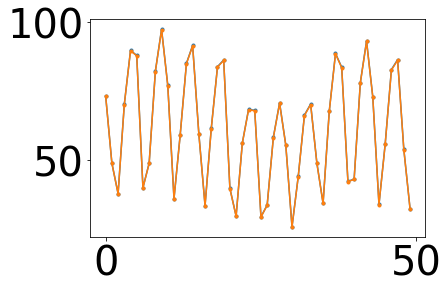

In [30]:
plt.plot(pred_num_1h, '.-')
plt.plot(pred_num_1h_sim, '.-')
plt.show()

In [31]:
#print(pred_num_4h, real_num_4h, pai_4h)
print(np.mean(pred_num_1h), np.mean(real_num_1h), np.mean(pai_1h), 
      np.median(pred_num_1h), np.median(real_num_1h), np.median(pai_1h))

print(np.mean(pred_num_1h_sim), np.mean(real_num_1h_sim), np.mean(pai_1h_sim), 
      np.median(pred_num_1h_sim), np.median(real_num_1h_sim), np.median(pai_1h_sim))

61.40851754298598 65.8 16.9155592376163 60.65573554852948 64.0 15.687382297551789
61.28470958529425 65.8 16.760706855984566 60.52396043667248 64.0 15.585043116265238


In [64]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
last_t = simulation._LastTime

indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*7: # 4 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []

if len(indices)<max_iters:
    max_iters = len(indices)

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_synthetic=False)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    pai_2h.append(pai)
    simulation.update_from_new_inputs(test_points)
  

simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

pred_num_2h_sim = []
real_num_2h_sim = []
pai_2h_sim = []

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_2h_sim.append(sum(sum(pred)))
    real_num_2h_sim.append(sum(sum(real)))
    pai_2h_sim.append(pai)
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.2902205575 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.294117647058824. 
Hit number/Tot number: 0.08823529411764706. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 97.10404238931937

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.940722410887024, Real: 2.0
Grid: (26, 22), Model: 0.8026991447569739, Real: 2.0
Grid: (33, 25), Model: 0.45694535021773214, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 1.0308765353645264, Real: 1.0
Grid: (27, 24), Model: 0.8339742806096457, Real: 0.0
Grid: (26, 23), Model: 0.47037934002506704, Real: 0.0
Grid: (28, 23), Model: 0.4417945535415045, Real: 0.0
Grid: (32, 25), Model: 0.4078941601320065, Real: 0.0
Grid: (34, 24), Model: 0.40250761173252364, Real: 0.0
Grid: (28, 24), Model: 0.39949129920666326, Real: 0.0
Grid: (33, 23), Model: 0.3977088159187934, Real: 0.0
Grid: (27, 31), Model: 0.39384180913593236, Rea

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



The predictive accuracy index for 30 hotspots is: 15.441176470588236. 
Hit number/Tot number: 0.1323529411764706. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 96.61118303254605

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.95754543002344, Real: 2.0
Grid: (32, 25), Model: 0.399853352775586, Real: 2.0
Grid: (26, 26), Model: 0.3131288602772065, Real: 2.0
Grid: (35, 23), Model: 0.29552181482675766, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.8596663961800063, Real: 1.0
Grid: (27, 24), Model: 0.8196298740637676, Real: 0.0
Grid: (26, 22), Model: 0.7783154259705931, Real: 1.0
Grid: (33, 25), Model: 0.4589088262803733, Real: 0.0
Grid: (26, 23), Model: 0.45679198406880295, Real: 1.0
Grid: (28, 23), Model: 0.4254376391651682, Real: 0.0
Grid: (34, 24), Model: 0.3997575718077483, Real: 1.0
Grid: (28, 24), Model: 0.39788476479181983, Real: 1.0
Grid: (27, 31), Model: 0.3953317015099466, Real: 0.0
Grid: (35, 32), Model: 0.38


The predictive accuracy index for 30 hotspots is: 17.375886524822693. 
Hit number/Tot number: 0.14893617021276595. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 127.98761752921

Predicted hotspots in real top 30
Grid: (27, 24), Model: 1.0671162465585577, Real: 2.0
Grid: (26, 23), Model: 0.60875802119595, Real: 2.0
Grid: (28, 23), Model: 0.5856790222990956, Real: 2.0
Grid: (29, 20), Model: 0.49610099323358575, Real: 2.0
Grid: (26, 26), Model: 0.3976287688930352, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 1.2985317257809006, Real: 1.0
Grid: (27, 22), Model: 1.2733512222233487, Real: 0.0
Grid: (26, 22), Model: 1.1206862052292308, Real: 0.0
Grid: (34, 24), Model: 0.5997997349993621, Real: 1.0
Grid: (33, 25), Model: 0.5977747865845287, Real: 0.0
Grid: (32, 25), Model: 0.5386931062805166, Real: 1.0
Grid: (28, 24), Model: 0.5073568082208434, Real: 1.0
Grid: (44, 32), Model: 0.5033996335868309, Real: 0.0
Grid: (27, 31), Model: 0.4941


Predicting over time of 0.2810307221 days. Generating 27 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.925925925925924. 
Hit number/Tot number: 0.2222222222222222. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 51.802076486500475

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5229800089059741, Real: 2.0
Grid: (27, 22), Model: 0.4740104966854484, Real: 2.0
Grid: (27, 24), Model: 0.4510777947071741, Real: 1.0
Grid: (26, 22), Model: 0.4331618900275201, Real: 3.0
Grid: (44, 32), Model: 0.19699007471907612, Real: 2.0
Grid: (28, 19), Model: 0.1862996142176867, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (33, 25), Model: 0.27470573003270704, Real: 0.0
Grid: (26, 23), Model: 0.2613245252275205, Real: 0.0
Grid: (28, 23), Model: 0.24413834593210695, Real: 0.0
Grid: (34, 24), Model: 0.22628346164955812, Real: 0.0
Grid: (29, 20), Model: 0.2175514773208749, Real: 0.0
Grid: (35, 32), Model: 0.2069671644890674, Rea


Predicting over time of 0.2904867618 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.61111111111111. 
Hit number/Tot number: 0.11666666666666667. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 77.80084542565

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.6498278084234682, Real: 2.0
Grid: (28, 23), Model: 0.3716893542547216, Real: 2.0
Grid: (28, 24), Model: 0.30532269364279735, Real: 2.0
Grid: (29, 22), Model: 0.28891418572419864, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.7896258245955919, Real: 0.0
Grid: (27, 22), Model: 0.7524376413852583, Real: 0.0
Grid: (27, 24), Model: 0.6646536221328859, Real: 0.0
Grid: (26, 23), Model: 0.4082527774380625, Real: 0.0
Grid: (33, 25), Model: 0.39247044725483465, Real: 0.0
Grid: (34, 24), Model: 0.3869101037405401, Real: 0.0
Grid: (32, 25), Model: 0.3279504550306718, Real: 0.0
Grid: (27, 31), Model: 0.3264032227830404, Real: 0.


Predicting over time of 0.2857876772 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 18.855218855218855. 
Hit number/Tot number: 0.16161616161616163. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 92.69975433900018

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.8806120132078408, Real: 2.0
Grid: (27, 24), Model: 0.7696493853615204, Real: 2.0
Grid: (36, 23), Model: 0.3005631189262455, Real: 2.0
Grid: (33, 24), Model: 0.2956394188193136, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.9380263793717684, Real: 1.0
Grid: (26, 22), Model: 0.7839426769131492, Real: 0.0
Grid: (28, 23), Model: 0.4734194249522333, Real: 0.0
Grid: (26, 23), Model: 0.46716827383112974, Real: 0.0
Grid: (34, 24), Model: 0.4535326909167995, Real: 0.0
Grid: (33, 25), Model: 0.44102504563582334, Real: 0.0
Grid: (27, 31), Model: 0.39892703865337026, Real: 0.0
Grid: (28, 24), Model: 0.39642888585167035, Rea


Predicting over time of 0.2897112971 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.848484848484846. 
Hit number/Tot number: 0.12727272727272726. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 53.16976327862124

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5447574721239146, Real: 1.0
Grid: (27, 22), Model: 0.526312857595477, Real: 2.0
Grid: (26, 23), Model: 0.24870640122225357, Real: 1.0
Grid: (27, 26), Model: 0.22820627399205085, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.4575171771281175, Real: 0.0
Grid: (26, 22), Model: 0.4418629668847931, Real: 0.0
Grid: (28, 23), Model: 0.2690867000571901, Real: 0.0
Grid: (34, 24), Model: 0.2541692774907788, Real: 1.0
Grid: (32, 25), Model: 0.2538295074965913, Real: 0.0
Grid: (33, 25), Model: 0.2522348794551519, Real: 0.0
Grid: (27, 31), Model: 0.24077937549184064, Real: 0.0
Grid: (28, 24), Model: 0.20965833869380246, Real


Predicting over time of 0.2912853747 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.294117647058824. 
Hit number/Tot number: 0.08823529411764706. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 53.5112158251588

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.2306098659121891, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.5685414705414721, Real: 0.0
Grid: (27, 22), Model: 0.5376640348758155, Real: 0.0
Grid: (26, 22), Model: 0.48323232489778967, Real: 0.0
Grid: (27, 24), Model: 0.44782452704409803, Real: 0.0
Grid: (28, 23), Model: 0.256191176092024, Real: 0.0
Grid: (34, 24), Model: 0.2515613651650009, Real: 0.0
Grid: (26, 23), Model: 0.24790354897872488, Real: 0.0
Grid: (32, 25), Model: 0.24619856022203274, Real: 0.0
Grid: (27, 26), Model: 0.2454065717053754, Real: 0.0
Grid: (33, 25), Model: 0.24153468454281085, Real: 0.0
Grid: (35, 32), Model: 0.22139916813453134, Rea


Predicting over time of 0.2902321316 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.29032258064516. 
Hit number/Tot number: 0.0967741935483871. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 90.03466126472425

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.9123558651242035, Real: 1.0
Grid: (27, 24), Model: 0.7639825653080246, Real: 1.0
Grid: (26, 23), Model: 0.42821003324399515, Real: 1.0
Grid: (27, 26), Model: 0.3724556483768956, Real: 1.0
Grid: (44, 32), Model: 0.33292250497434506, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.9099474244432318, Real: 0.0
Grid: (26, 22), Model: 0.7454495919560588, Real: 0.0
Grid: (27, 31), Model: 0.45430173730132095, Real: 0.0
Grid: (34, 24), Model: 0.4366407448393497, Real: 0.0
Grid: (28, 23), Model: 0.4193433433242838, Real: 0.0
Grid: (33, 25), Model: 0.3934260802608182, Real: 0.0
Grid: (32, 25), Model: 0.38164978036458935, Real:


Predicting over time of 0.291088615 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 113.35719801761067

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.9532100711119676, Real: 3.0
Grid: (27, 31), Model: 0.5096691168089972, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.1885078268779863, Real: 0.0
Grid: (27, 23), Model: 1.1043939737117192, Real: 0.0
Grid: (26, 22), Model: 0.9316861689465897, Real: 0.0
Grid: (26, 23), Model: 0.5386765584721818, Real: 0.0
Grid: (28, 23), Model: 0.5349295219941417, Real: 1.0
Grid: (34, 24), Model: 0.529464363265374, Real: 0.0
Grid: (33, 25), Model: 0.4973820701332635, Real: 0.0
Grid: (27, 26), Model: 0.47834122083180064, Real: 0.0
Grid: (32, 25), Model: 0.45730208667979216, Real: 0.0
Grid: (28, 24), Model: 0.45508005431801063, Real:


The predictive accuracy index for 30 hotspots is: 15.123456790123456. 
Hit number/Tot number: 0.12962962962962962. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 112.78918106031804

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.9314461427549543, Real: 2.0
Grid: (26, 23), Model: 0.5057042081975672, Real: 1.0
Grid: (27, 31), Model: 0.491423187557896, Real: 1.0
Grid: (44, 32), Model: 0.39475070532472606, Real: 2.0
Grid: (31, 22), Model: 0.36080328628162806, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.142940006703845, Real: 0.0
Grid: (27, 23), Model: 1.0559692501190392, Real: 0.0
Grid: (26, 22), Model: 0.9263089427695358, Real: 0.0
Grid: (34, 24), Model: 0.5736988903015388, Real: 1.0
Grid: (33, 25), Model: 0.5398121426897426, Real: 0.0
Grid: (28, 23), Model: 0.5057741106471876, Real: 1.0
Grid: (28, 24), Model: 0.4615093994052139, Real: 1.0
Grid: (29, 20), Model: 0.44736029752014134, Real: 0.0
Grid: (27, 26), Model: 0


Predicting over time of 0.2872923102 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.819672131147538. 
Hit number/Tot number: 0.22131147540983606. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 101.21448630562283

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.965245490638827, Real: 2.0
Grid: (27, 24), Model: 0.8312428874879546, Real: 2.0
Grid: (26, 22), Model: 0.8191108823172077, Real: 3.0
Grid: (34, 24), Model: 0.5278382736044482, Real: 2.0
Grid: (28, 23), Model: 0.5060544061142372, Real: 4.0
Grid: (28, 24), Model: 0.43067558396242733, Real: 3.0
Grid: (33, 1), Model: 0.35156210687799866, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.9808468211449127, Real: 1.0
Grid: (26, 23), Model: 0.4793889127106281, Real: 1.0
Grid: (27, 31), Model: 0.47884995127860697, Real: 1.0
Grid: (33, 25), Model: 0.454481741420683, Real: 0.0
Grid: (35, 32), Model: 0.4330257026842638, Real: 


Predicting over time of 0.2884034238 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 27.876106194690266. 
Hit number/Tot number: 0.23893805309734514. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 94.29194441280295

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.9157497691732793, Real: 4.0
Grid: (34, 24), Model: 0.46687715148332437, Real: 2.0
Grid: (33, 24), Model: 0.41031174746135135, Real: 2.0
Grid: (44, 32), Model: 0.4019102754769739, Real: 2.0
Grid: (29, 20), Model: 0.3396911857627913, Real: 2.0
Grid: (37, 23), Model: 0.33588918964113834, Real: 2.0
Grid: (26, 26), Model: 0.3189540452271953, Real: 2.0
Grid: (51, 33), Model: 0.2868787216324846, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.8967698388315964, Real: 0.0
Grid: (27, 24), Model: 0.8218195584138698, Real: 1.0
Grid: (26, 22), Model: 0.8080210753259022, Real: 0.0
Grid: (28, 23), Model: 0.5064853646987539, Real


Predicting over time of 0.2869798095 days. Generating 28 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.41947565543071. 
Hit number/Tot number: 0.12359550561797752. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 65.58769524466771

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.6639004777932119, Real: 4.0
Grid: (28, 24), Model: 0.26073401572397714, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.6752082827431609, Real: 0.0
Grid: (26, 22), Model: 0.567810733824861, Real: 0.0
Grid: (27, 24), Model: 0.5325531397172698, Real: 1.0
Grid: (34, 24), Model: 0.3285794496103573, Real: 0.0
Grid: (26, 23), Model: 0.32053834910321893, Real: 0.0
Grid: (28, 23), Model: 0.3192443720243853, Real: 0.0
Grid: (33, 24), Model: 0.2989642954769064, Real: 1.0
Grid: (35, 32), Model: 0.2880337725449994, Real: 0.0
Grid: (33, 25), Model: 0.28567949207544197, Real: 0.0
Grid: (27, 31), Model: 0.2836504953526124, Real: 

Number of simulated events used: 65. First Event Time: 2016-10-06 01:08:01.203958 End: 2016-11-08 09:03:48.778701
Number of simulated events used: 80. First Event Time: 2016-10-06 01:12:54.319711 End: 2016-11-08 09:04:11.719490
Number of simulated events used: 63. First Event Time: 2016-10-06 01:10:17.960401 End: 2016-11-08 09:05:42.090224
Number of simulated events used: 73. First Event Time: 2016-10-06 01:21:17.351132 End: 2016-11-08 09:01:59.018645
Number of simulated events used: 81. First Event Time: 2016-10-06 01:19:54.517254 End: 2016-11-08 09:06:12.743604
Number of simulated events used: 72. First Event Time: 2016-10-06 01:12:11.625766 End: 2016-11-08 09:05:55.204640
Number of simulated events used: 66. First Event Time: 2016-10-06 01:09:47.146017 End: 2016-11-08 09:02:00.456459

The predictive accuracy index for 30 hotspots is: 18.103448275862068. 
Hit number/Tot number: 0.15517241379310345. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 53.1014196

Number of simulated events used: 51. First Event Time: 2016-10-06 15:25:35.047855 End: 2016-11-08 23:09:29.306939
Number of simulated events used: 58. First Event Time: 2016-10-06 15:10:48.777111 End: 2016-11-08 22:56:01.017755
Number of simulated events used: 81. First Event Time: 2016-10-06 15:14:54.613446 End: 2016-11-08 23:09:28.504013
Number of simulated events used: 71. First Event Time: 2016-10-06 15:15:35.471968 End: 2016-11-08 22:58:40.455257
Number of simulated events used: 49. First Event Time: 2016-10-06 15:24:27.813710 End: 2016-11-08 23:02:06.374547
Number of simulated events used: 67. First Event Time: 2016-10-06 15:12:36.320180 End: 2016-11-08 23:08:35.707597
Number of simulated events used: 63. First Event Time: 2016-10-06 15:10:37.834427 End: 2016-11-08 23:07:19.673453
Number of simulated events used: 63. First Event Time: 2016-10-06 15:10:32.911074 End: 2016-11-08 23:06:55.313996

The predictive accuracy index for 30 hotspots is: 19.58041958041958. 
Hit number/Tot nu

Number of simulated events used: 57. First Event Time: 2016-10-07 05:26:44.182592 End: 2016-11-09 13:23:27.773397
Number of simulated events used: 49. First Event Time: 2016-10-07 05:27:08.264803 End: 2016-11-09 13:21:15.194936
Number of simulated events used: 65. First Event Time: 2016-10-07 05:27:00.624697 End: 2016-11-09 13:11:32.674339
Number of simulated events used: 56. First Event Time: 2016-10-07 05:25:44.157634 End: 2016-11-09 13:18:47.077119
Number of simulated events used: 61. First Event Time: 2016-10-07 05:28:58.545608 End: 2016-11-09 13:24:03.554028
Number of simulated events used: 65. First Event Time: 2016-10-07 05:26:16.200262 End: 2016-11-09 13:22:55.837868
Number of simulated events used: 62. First Event Time: 2016-10-07 05:26:59.970837 End: 2016-11-09 13:21:44.532376
Number of simulated events used: 54. First Event Time: 2016-10-07 05:33:37.466955 End: 2016-11-09 13:19:21.999170

The predictive accuracy index for 30 hotspots is: 24.137931034482758. 
Hit number/Tot n

Number of simulated events used: 59. First Event Time: 2016-10-07 19:42:00.183087 End: 2016-11-10 03:40:17.519236
Number of simulated events used: 66. First Event Time: 2016-10-07 20:02:23.502986 End: 2016-11-10 03:33:26.175482
Number of simulated events used: 42. First Event Time: 2016-10-07 19:42:24.802332 End: 2016-11-10 03:40:59.628173
Number of simulated events used: 55. First Event Time: 2016-10-07 20:01:45.965388 End: 2016-11-10 03:39:55.183928
Number of simulated events used: 60. First Event Time: 2016-10-07 19:48:44.211143 End: 2016-11-10 03:37:12.811115
Number of simulated events used: 58. First Event Time: 2016-10-07 19:51:32.912206 End: 2016-11-10 03:39:03.403145
Number of simulated events used: 65. First Event Time: 2016-10-07 19:42:48.525394 End: 2016-11-10 03:39:50.340794
Number of simulated events used: 45. First Event Time: 2016-10-07 19:52:17.774585 End: 2016-11-10 03:39:42.095864

The predictive accuracy index for 30 hotspots is: 18.495934959349594. 
Hit number/Tot n

Number of simulated events used: 55. First Event Time: 2016-10-08 09:49:04.438250 End: 2016-11-10 17:33:09.410078
Number of simulated events used: 53. First Event Time: 2016-10-08 09:47:08.865993 End: 2016-11-10 17:36:59.206863
Number of simulated events used: 55. First Event Time: 2016-10-08 09:45:10.393587 End: 2016-11-10 17:38:56.047436
Number of simulated events used: 63. First Event Time: 2016-10-08 09:44:21.063476 End: 2016-11-10 17:30:11.037018
Number of simulated events used: 44. First Event Time: 2016-10-08 09:42:53.981933 End: 2016-11-10 17:33:54.779083
Number of simulated events used: 56. First Event Time: 2016-10-08 09:45:16.917663 End: 2016-11-10 17:42:27.617474
Number of simulated events used: 59. First Event Time: 2016-10-08 09:49:28.954014 End: 2016-11-10 17:34:06.027555
Number of simulated events used: 59. First Event Time: 2016-10-08 09:46:56.945921 End: 2016-11-10 17:42:29.099614

The predictive accuracy index for 30 hotspots is: 17.63565891472868. 
Hit number/Tot nu

Number of simulated events used: 59. First Event Time: 2016-10-08 23:56:59.285511 End: 2016-11-11 07:28:57.244903
Number of simulated events used: 53. First Event Time: 2016-10-09 00:02:11.712298 End: 2016-11-11 07:48:17.467057
Number of simulated events used: 53. First Event Time: 2016-10-08 23:53:37.264974 End: 2016-11-11 07:45:05.662336
Number of simulated events used: 56. First Event Time: 2016-10-08 23:56:13.891104 End: 2016-11-11 07:45:51.375822
Number of simulated events used: 57. First Event Time: 2016-10-08 23:54:16.561838 End: 2016-11-11 07:34:10.472813
Number of simulated events used: 51. First Event Time: 2016-10-08 23:56:31.271801 End: 2016-11-11 07:45:31.677170
Number of simulated events used: 51. First Event Time: 2016-10-09 00:05:46.919057 End: 2016-11-11 07:46:47.800499
Number of simulated events used: 48. First Event Time: 2016-10-08 23:51:16.015434 End: 2016-11-11 07:48:45.576645

The predictive accuracy index for 30 hotspots is: 24.305555555555557. 
Hit number/Tot n

Number of simulated events used: 53. First Event Time: 2016-10-09 14:25:17.325791 End: 2016-11-11 21:52:26.537497
Number of simulated events used: 64. First Event Time: 2016-10-09 13:56:46.822188 End: 2016-11-11 21:43:09.735720
Number of simulated events used: 64. First Event Time: 2016-10-09 14:03:46.786435 End: 2016-11-11 21:49:24.869114
Number of simulated events used: 66. First Event Time: 2016-10-09 13:54:37.095063 End: 2016-11-11 21:43:23.224954
Number of simulated events used: 45. First Event Time: 2016-10-09 13:58:10.200318 End: 2016-11-11 21:53:04.893700
Number of simulated events used: 46. First Event Time: 2016-10-09 13:57:30.234453 End: 2016-11-11 21:53:37.760051
Number of simulated events used: 44. First Event Time: 2016-10-09 13:54:22.748534 End: 2016-11-11 21:53:48.263178
Number of simulated events used: 64. First Event Time: 2016-10-09 13:58:31.009443 End: 2016-11-11 21:43:47.823846

The predictive accuracy index for 30 hotspots is: 23.958333333333332. 
Hit number/Tot n

Number of simulated events used: 51. First Event Time: 2016-10-10 04:46:13.428806 End: 2016-11-12 12:04:51.053170
Number of simulated events used: 58. First Event Time: 2016-10-10 04:08:12.585173 End: 2016-11-12 11:57:51.334025
Number of simulated events used: 56. First Event Time: 2016-10-10 04:05:53.697748 End: 2016-11-12 12:04:47.439312
Number of simulated events used: 68. First Event Time: 2016-10-10 04:15:01.433714 End: 2016-11-12 11:56:26.115421
Number of simulated events used: 51. First Event Time: 2016-10-10 04:07:57.295482 End: 2016-11-12 12:04:15.759921
Number of simulated events used: 57. First Event Time: 2016-10-10 04:11:45.216633 End: 2016-11-12 11:56:38.012928
Number of simulated events used: 63. First Event Time: 2016-10-10 04:10:14.402600 End: 2016-11-12 12:03:13.014907
Number of simulated events used: 60. First Event Time: 2016-10-10 04:18:45.636880 End: 2016-11-12 11:59:41.123412

The predictive accuracy index for 30 hotspots is: 11.814345991561181. 
Hit number/Tot n


Predicting over time of 0.2857876772 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 58. First Event Time: 2016-10-10 18:11:48.639964 End: 2016-11-13 01:58:00.380049
Number of simulated events used: 63. First Event Time: 2016-10-10 18:25:58.782968 End: 2016-11-13 02:02:51.815854
Number of simulated events used: 51. First Event Time: 2016-10-10 18:19:57.198902 End: 2016-11-13 02:06:34.748677
Number of simulated events used: 49. First Event Time: 2016-10-10 18:11:37.315491 End: 2016-11-13 02:05:13.681763
Number of simulated events used: 59. First Event Time: 2016-10-10 18:17:45.361323 End: 2016-11-13 01:54:44.870071
Number of simulated events used: 57. First Event Time: 2016-10-10 18:17:00.723960 End: 2016-11-13 02:07:17.383887
Number of simulated events used: 56. First Event Time: 2016-10-10 18:24:42.929869 End: 2016-11-13 02:00:43.736690
Number of simulated events used: 56. First Event Time: 2016-10-1


Predicting over time of 0.28895898059999997 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 54. First Event Time: 2016-10-11 08:30:13.321358 End: 2016-11-13 16:04:46.052990
Number of simulated events used: 51. First Event Time: 2016-10-11 08:14:05.319133 End: 2016-11-13 16:13:08.708370
Number of simulated events used: 55. First Event Time: 2016-10-11 09:00:22.658517 End: 2016-11-13 16:12:35.694104
Number of simulated events used: 54. First Event Time: 2016-10-11 08:27:15.829696 End: 2016-11-13 16:05:05.089774
Number of simulated events used: 51. First Event Time: 2016-10-11 08:15:49.532570 End: 2016-11-13 16:09:21.200768
Number of simulated events used: 50. First Event Time: 2016-10-11 08:20:55.316283 End: 2016-11-13 16:07:08.954730
Number of simulated events used: 49. First Event Time: 2016-10-11 08:32:26.524851 End: 2016-11-13 15:51:10.194228
Number of simulated events used: 49. First Event Time: 20


Predicting over time of 0.2897112971 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 62. First Event Time: 2016-10-11 22:26:21.773086 End: 2016-11-14 06:20:52.993535
Number of simulated events used: 62. First Event Time: 2016-10-11 22:41:02.061939 End: 2016-11-14 06:15:53.882430
Number of simulated events used: 66. First Event Time: 2016-10-11 22:33:51.975180 End: 2016-11-14 06:21:27.868356
Number of simulated events used: 60. First Event Time: 2016-10-11 22:29:01.786400 End: 2016-11-14 06:11:23.587738
Number of simulated events used: 59. First Event Time: 2016-10-11 22:33:42.440610 End: 2016-11-14 05:55:59.351655
Number of simulated events used: 41. First Event Time: 2016-10-11 22:26:52.376527 End: 2016-11-14 06:21:59.563280
Number of simulated events used: 56. First Event Time: 2016-10-11 22:34:53.611881 End: 2016-11-14 06:17:30.299607
Number of simulated events used: 48. First Event Time: 2016-10-1

Number of simulated events used: 54. First Event Time: 2016-10-12 12:39:00.123987 End: 2016-11-14 20:31:04.309026
Number of simulated events used: 45. First Event Time: 2016-10-12 12:44:50.779512 End: 2016-11-14 20:24:47.425326
Number of simulated events used: 53. First Event Time: 2016-10-12 12:31:47.253601 End: 2016-11-14 20:20:03.946286
Number of simulated events used: 49. First Event Time: 2016-10-12 12:39:59.872772 End: 2016-11-14 20:21:07.213884
Number of simulated events used: 65. First Event Time: 2016-10-12 12:38:35.022491 End: 2016-11-14 20:08:42.364375
Number of simulated events used: 59. First Event Time: 2016-10-12 12:37:22.436470 End: 2016-11-14 20:31:09.945550
Number of simulated events used: 43. First Event Time: 2016-10-12 12:36:35.170283 End: 2016-11-14 20:24:59.433674
Number of simulated events used: 45. First Event Time: 2016-10-12 12:39:57.527420 End: 2016-11-14 20:25:06.108977

The predictive accuracy index for 30 hotspots is: 14.691358024691356. 
Hit number/Tot n


Predicting over time of 0.2912853747 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 54. First Event Time: 2016-10-13 02:54:47.113928 End: 2016-11-15 10:25:30.818248
Number of simulated events used: 53. First Event Time: 2016-10-13 02:40:32.727911 End: 2016-11-15 10:17:00.110744
Number of simulated events used: 51. First Event Time: 2016-10-13 02:57:36.254186 End: 2016-11-15 10:33:43.357187
Number of simulated events used: 56. First Event Time: 2016-10-13 02:38:39.216996 End: 2016-11-15 10:32:20.235839
Number of simulated events used: 62. First Event Time: 2016-10-13 02:59:14.925870 End: 2016-11-15 10:34:33.881401
Number of simulated events used: 49. First Event Time: 2016-10-13 02:42:34.230092 End: 2016-11-15 10:34:10.649009
Number of simulated events used: 50. First Event Time: 2016-10-13 02:38:10.997272 End: 2016-11-15 10:13:40.108821
Number of simulated events used: 51. First Event Time: 2016-10-1


Predicting over time of 0.2913779675 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 60. First Event Time: 2016-10-13 16:52:18.116175 End: 2016-11-16 00:33:26.650147
Number of simulated events used: 47. First Event Time: 2016-10-13 16:42:35.186132 End: 2016-11-16 00:34:03.446933
Number of simulated events used: 57. First Event Time: 2016-10-13 16:47:43.024560 End: 2016-11-16 00:41:12.518050
Number of simulated events used: 69. First Event Time: 2016-10-13 16:45:11.179496 End: 2016-11-16 00:15:07.876025
Number of simulated events used: 49. First Event Time: 2016-10-13 16:50:59.855613 End: 2016-11-16 00:40:42.833931
Number of simulated events used: 53. First Event Time: 2016-10-13 16:53:57.619727 End: 2016-11-16 00:38:12.354633
Number of simulated events used: 58. First Event Time: 2016-10-13 16:53:57.593123 End: 2016-11-16 00:25:34.015069
Number of simulated events used: 61. First Event Time: 2016-10-1


Predicting over time of 0.2902321316 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 52. First Event Time: 2016-10-14 06:58:58.652521 End: 2016-11-16 14:54:55.612711
Number of simulated events used: 42. First Event Time: 2016-10-14 07:06:19.714441 End: 2016-11-16 14:33:32.554433
Number of simulated events used: 56. First Event Time: 2016-10-14 07:03:19.148515 End: 2016-11-16 14:53:53.027684
Number of simulated events used: 58. First Event Time: 2016-10-14 07:07:56.699666 End: 2016-11-16 14:56:26.402858
Number of simulated events used: 53. First Event Time: 2016-10-14 07:06:47.978433 End: 2016-11-16 14:49:05.809355
Number of simulated events used: 53. First Event Time: 2016-10-14 07:01:15.023933 End: 2016-11-16 14:37:38.130110
Number of simulated events used: 59. First Event Time: 2016-10-14 07:08:00.620922 End: 2016-11-16 14:53:04.353677
Number of simulated events used: 47. First Event Time: 2016-10-1

Number of simulated events used: 67. First Event Time: 2016-10-14 21:14:25.100410 End: 2016-11-17 05:02:27.034893
Number of simulated events used: 62. First Event Time: 2016-10-14 21:04:12.956357 End: 2016-11-17 04:54:39.283367
Number of simulated events used: 59. First Event Time: 2016-10-14 21:16:08.009311 End: 2016-11-17 04:27:16.659098
Number of simulated events used: 56. First Event Time: 2016-10-14 21:08:59.720972 End: 2016-11-17 04:53:50.304669
Number of simulated events used: 61. First Event Time: 2016-10-14 21:04:11.971112 End: 2016-11-17 05:01:58.192037
Number of simulated events used: 46. First Event Time: 2016-10-14 21:12:35.855009 End: 2016-11-17 04:59:58.209315
Number of simulated events used: 58. First Event Time: 2016-10-14 21:07:59.506423 End: 2016-11-17 05:03:13.995941
Number of simulated events used: 52. First Event Time: 2016-10-14 21:23:55.984601 End: 2016-11-17 04:59:15.310634

The predictive accuracy index for 30 hotspots is: 20.289855072463766. 
Hit number/Tot n

Number of simulated events used: 45. First Event Time: 2016-10-15 11:09:29.407800 End: 2016-11-17 19:04:32.526847
Number of simulated events used: 55. First Event Time: 2016-10-15 11:17:01.838020 End: 2016-11-17 19:00:15.030589
Number of simulated events used: 61. First Event Time: 2016-10-15 11:07:10.055341 End: 2016-11-17 19:01:11.945744
Number of simulated events used: 48. First Event Time: 2016-10-15 11:22:59.317430 End: 2016-11-17 18:56:02.067631
Number of simulated events used: 53. First Event Time: 2016-10-15 11:13:05.334111 End: 2016-11-17 19:03:48.003903
Number of simulated events used: 60. First Event Time: 2016-10-15 11:15:04.433886 End: 2016-11-17 19:01:46.616417
Number of simulated events used: 44. First Event Time: 2016-10-15 11:14:36.760150 End: 2016-11-17 19:02:10.698490
Number of simulated events used: 54. First Event Time: 2016-10-15 11:59:23.368318 End: 2016-11-17 18:58:13.965528

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot n


Predicting over time of 0.2860075851 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 55. First Event Time: 2016-10-16 01:12:13.979976 End: 2016-11-18 09:06:40.348707
Number of simulated events used: 67. First Event Time: 2016-10-16 01:17:45.392627 End: 2016-11-18 09:04:49.742440
Number of simulated events used: 63. First Event Time: 2016-10-16 01:12:14.041497 End: 2016-11-18 09:04:13.703790
Number of simulated events used: 51. First Event Time: 2016-10-16 01:15:04.857999 End: 2016-11-18 09:05:30.026558
Number of simulated events used: 49. First Event Time: 2016-10-16 01:11:45.104739 End: 2016-11-18 09:09:48.696676
Number of simulated events used: 56. First Event Time: 2016-10-16 01:15:45.982942 End: 2016-11-18 09:09:52.228436
Number of simulated events used: 63. First Event Time: 2016-10-16 01:17:25.276542 End: 2016-11-18 09:00:36.410969
Number of simulated events used: 51. First Event Time: 2016-10-1


Predicting over time of 0.2779288633 days. Generating 27 intensity prediction(s)
Events will be projected until 0.28125063 days from now
Number of simulated events used: 59. First Event Time: 2016-10-16 15:26:36.188456 End: 2016-11-18 23:14:28.417044
Number of simulated events used: 43. First Event Time: 2016-10-16 15:44:18.725471 End: 2016-11-18 23:18:32.476282
Number of simulated events used: 44. First Event Time: 2016-10-16 15:30:48.898200 End: 2016-11-18 23:08:46.665270
Number of simulated events used: 58. First Event Time: 2016-10-16 15:23:15.466759 End: 2016-11-18 23:19:42.954396
Number of simulated events used: 50. First Event Time: 2016-10-16 15:31:53.178016 End: 2016-11-18 23:12:40.890949
Number of simulated events used: 61. First Event Time: 2016-10-16 15:26:34.510244 End: 2016-11-18 23:21:54.632971
Number of simulated events used: 45. First Event Time: 2016-10-16 15:28:40.465902 End: 2016-11-18 23:10:06.581353
Number of simulated events used: 51. First Event Time: 2016-10-1


Predicting over time of 0.2891557403 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 70. First Event Time: 2016-10-17 05:53:59.711477 End: 2016-11-19 13:45:08.231425
Number of simulated events used: 51. First Event Time: 2016-10-17 06:02:12.945557 End: 2016-11-19 13:48:14.544897
Number of simulated events used: 55. First Event Time: 2016-10-17 05:51:05.360183 End: 2016-11-19 13:46:56.825449
Number of simulated events used: 71. First Event Time: 2016-10-17 05:53:43.314485 End: 2016-11-19 13:43:40.162067
Number of simulated events used: 60. First Event Time: 2016-10-17 06:12:47.630069 End: 2016-11-19 13:35:56.047947
Number of simulated events used: 47. First Event Time: 2016-10-17 05:52:25.292044 End: 2016-11-19 13:39:49.346985
Number of simulated events used: 67. First Event Time: 2016-10-17 05:51:06.516997 End: 2016-11-19 13:46:52.400965
Number of simulated events used: 58. First Event Time: 2016-10-1


Predicting over time of 0.2879751821 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 49. First Event Time: 2016-10-17 19:52:24.448305 End: 2016-11-20 03:44:57.850671
Number of simulated events used: 51. First Event Time: 2016-10-17 20:01:50.053133 End: 2016-11-20 03:43:58.873741
Number of simulated events used: 58. First Event Time: 2016-10-17 20:05:42.018956 End: 2016-11-20 03:45:51.059095
Number of simulated events used: 53. First Event Time: 2016-10-17 19:49:26.790334 End: 2016-11-20 03:34:42.444145
Number of simulated events used: 58. First Event Time: 2016-10-17 19:51:30.749613 End: 2016-11-20 03:40:55.837606
Number of simulated events used: 43. First Event Time: 2016-10-17 19:54:21.197482 End: 2016-11-20 03:41:02.502298
Number of simulated events used: 48. First Event Time: 2016-10-17 20:03:14.801719 End: 2016-11-20 03:41:39.918388
Number of simulated events used: 48. First Event Time: 2016-10-1


Predicting over time of 0.2906487992 days. Generating 28 intensity prediction(s)
Events will be projected until 0.29166732 days from now
Number of simulated events used: 42. First Event Time: 2016-10-18 10:23:02.330193 End: 2016-11-20 17:53:06.686140
Number of simulated events used: 44. First Event Time: 2016-10-18 10:00:50.080625 End: 2016-11-20 17:47:07.232822
Number of simulated events used: 50. First Event Time: 2016-10-18 10:01:31.699439 End: 2016-11-20 17:57:09.731796
Number of simulated events used: 50. First Event Time: 2016-10-18 10:02:42.031307 End: 2016-11-20 17:56:33.685684
Number of simulated events used: 55. First Event Time: 2016-10-18 10:06:23.557728 End: 2016-11-20 17:52:42.472680
Number of simulated events used: 63. First Event Time: 2016-10-18 10:01:43.116385 End: 2016-11-20 17:52:35.448518
Number of simulated events used: 44. First Event Time: 2016-10-18 10:12:27.511706 End: 2016-11-20 17:52:31.949455
Number of simulated events used: 46. First Event Time: 2016-10-1

Number of simulated events used: 53. First Event Time: 2016-10-19 00:11:41.438674 End: 2016-11-21 08:06:32.403168
Number of simulated events used: 61. First Event Time: 2016-10-19 00:13:27.429098 End: 2016-11-21 07:58:34.613649
Number of simulated events used: 51. First Event Time: 2016-10-19 00:08:28.751664 End: 2016-11-21 08:02:11.426416
Number of simulated events used: 46. First Event Time: 2016-10-19 00:10:02.499782 End: 2016-11-21 07:48:28.015813
Number of simulated events used: 57. First Event Time: 2016-10-19 00:08:27.970933 End: 2016-11-21 08:07:23.811056
Number of simulated events used: 55. First Event Time: 2016-10-19 00:29:35.423541 End: 2016-11-21 07:59:52.262798
Number of simulated events used: 62. First Event Time: 2016-10-19 00:23:29.762130 End: 2016-11-21 08:06:39.049226
Number of simulated events used: 46. First Event Time: 2016-10-19 00:15:46.810782 End: 2016-11-21 08:03:02.070422

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot n

Number of simulated events used: 48. First Event Time: 2016-10-19 14:21:17.962399 End: 2016-11-21 22:03:30.192497
Number of simulated events used: 59. First Event Time: 2016-10-19 14:16:00.900380 End: 2016-11-21 22:11:41.309035
2016-10-19 20:13:53.022364
2016-10-19 20:13:53
Future time is behind last time!!!!
Cannot calculate with decay
Number of simulated events used: 47. First Event Time: 2016-10-19 14:29:17.709945 End: 2016-11-21 22:09:17.866401
Number of simulated events used: 60. First Event Time: 2016-10-19 14:22:59.906612 End: 2016-11-21 22:07:29.084152
Number of simulated events used: 53. First Event Time: 2016-10-19 14:18:58.427927 End: 2016-11-21 22:00:31.678908
Number of simulated events used: 49. First Event Time: 2016-10-19 14:14:34.908655 End: 2016-11-21 22:05:57.972911
Number of simulated events used: 54. First Event Time: 2016-10-19 14:14:50.741161 End: 2016-11-21 21:53:34.246035
Number of simulated events used: 48. First Event Time: 2016-10-19 14:25:04.783111 End: 2016

Number of simulated events used: 50. First Event Time: 2016-10-20 04:34:59.391884 End: 2016-11-22 12:19:34.459592
Number of simulated events used: 49. First Event Time: 2016-10-20 04:40:32.904705 End: 2016-11-22 12:26:27.233123
Number of simulated events used: 52. First Event Time: 2016-10-20 04:32:52.912639 End: 2016-11-22 12:00:25.658907
Number of simulated events used: 46. First Event Time: 2016-10-20 04:35:21.311140 End: 2016-11-22 12:29:08.762830
Number of simulated events used: 51. First Event Time: 2016-10-20 04:40:05.923626 End: 2016-11-22 12:27:18.530733
Number of simulated events used: 59. First Event Time: 2016-10-20 04:33:14.560351 End: 2016-11-22 12:07:54.669413
Number of simulated events used: 59. First Event Time: 2016-10-20 04:44:36.343952 End: 2016-11-22 12:22:47.464363
Number of simulated events used: 52. First Event Time: 2016-10-20 04:30:54.653943 End: 2016-11-22 12:30:00.766423

The predictive accuracy index for 30 hotspots is: 14.41947565543071. 
Hit number/Tot nu

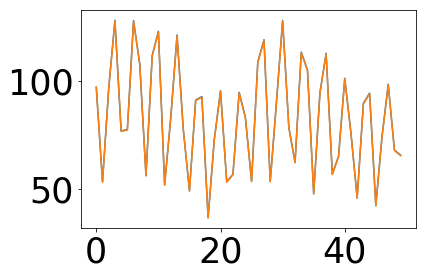

In [65]:
plt.plot(pred_num_2h)
plt.plot(pred_num_2h_sim)

In [66]:
#print(pred_num_4h, real_num_4h, pai_4h)
print(np.mean(pred_num_2h), np.mean(real_num_2h), np.mean(pai_2h), 
      np.median(pred_num_2h), np.median(real_num_2h), np.median(pai_2h))

print(np.mean(pred_num_2h_sim), np.mean(real_num_2h_sim), np.mean(pai_2h_sim), 
      np.median(pred_num_2h_sim), np.median(real_num_2h_sim), np.median(pai_2h_sim))

83.19316280298463 90.98 17.342997400947727 83.22898310071784 90.5 16.147828863346103
82.95090658331384 90.98 17.108483813059742 82.96033975853273 90.5 16.32020868998125


In [35]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
last_t = simulation._LastTime

indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*9: # 4 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_4h = []
real_num_4h = []
pai_4h = []

if len(indices)<max_iters:
    max_iters = len(indices)

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_synthetic=False)
    pred_num_4h.append(sum(sum(pred)))
    real_num_4h.append(sum(sum(real)))
    pai_4h.append(pai)
    simulation.update_from_new_inputs(test_points)
  

simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

pred_num_4h_sim = []
real_num_4h_sim = []
pai_4h_sim = []

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_4h_sim.append(sum(sum(pred)))
    real_num_4h_sim.append(sum(sum(real)))
    pai_4h_sim.append(pai)
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.3739707451 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 115.56895415944194

Predicted hotspots in real top 30
Grid: (27, 23), Model: 1.226903845896856, Real: 2.0
Grid: (27, 22), Model: 1.119606377916562, Real: 2.0
Grid: (26, 22), Model: 0.9553371660091214, Real: 2.0
Grid: (33, 25), Model: 0.5438362289899039, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.9925594551409824, Real: 0.0
Grid: (26, 23), Model: 0.5598247719384832, Real: 0.0
Grid: (28, 23), Model: 0.5258044181252868, Real: 0.0
Grid: (32, 25), Model: 0.48545766308267435, Real: 0.0
Grid: (34, 24), Model: 0.4790468304361652, Real: 0.0
Grid: (28, 24), Model: 0.47545694812586864, Real: 0.0
Grid: (33, 23), Model: 0.47333551502878, Real: 0.0
Grid: (27, 31), Model: 0.468733173883898, Real: 1.0
Grid: (35, 32),

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.3693179569 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.838487972508588. 
Hit number/Tot number: 0.14432989690721648. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 154.67208181104252

Predicted hotspots in real top 30
Grid: (27, 23), Model: 1.5489600673051196, Real: 2.0
Grid: (27, 22), Model: 1.3945417728094995, Real: 3.0
Grid: (27, 24), Model: 1.3044494914945033, Real: 2.0
Grid: (26, 23), Model: 0.7252823573905062, Real: 3.0
Grid: (34, 24), Model: 0.6376634729338303, Real: 2.0
Grid: (33, 23), Model: 0.5850393898943731, Real: 3.0
Grid: (36, 23), Model: 0.527605797478903, Real: 2.0
Grid: (44, 32), Model: 0.500412003958837, Real: 2.0
Grid: (35, 23), Model: 0.4982222600595628, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 1.2606683920532227, Real: 0.0
Grid: (33, 25), Model: 0.727897922242033, Real: 0.0
Grid: (28, 23), Model: 0.6741104320937289, Real: 1.0


Predicting over time of 0.36894758569999997 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.5. 
Hit number/Tot number: 0.15. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 162.34663326366547

Predicted hotspots in real top 30
Grid: (27, 23), Model: 1.6303046158235845, Real: 2.0
Grid: (27, 24), Model: 1.3392510970807014, Real: 3.0
Grid: (27, 31), Model: 0.6229369703326316, Real: 2.0
Grid: (29, 20), Model: 0.6205130797158556, Real: 3.0
Grid: (26, 27), Model: 0.5078645971387141, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.590024060263479, Real: 0.0
Grid: (26, 22), Model: 1.3991296152575567, Real: 1.0
Grid: (26, 23), Model: 0.7967489388453967, Real: 1.0
Grid: (34, 24), Model: 0.7812619659045266, Real: 0.0
Grid: (28, 23), Model: 0.7674378008897019, Real: 1.0
Grid: (33, 25), Model: 0.7520219166215945, Real: 1.0
Grid: (32, 25), Model: 0.7106945866384385, Real: 0.0
Grid: (28, 24), Mod


Predicting over time of 0.3748735249 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.41947565543071. 
Hit number/Tot number: 0.12359550561797752. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 85.77574480354015

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.877307074588724, Real: 2.0
Grid: (27, 22), Model: 0.8160392605207851, Real: 2.0
Grid: (26, 22), Model: 0.7448685758029874, Real: 1.0
Grid: (26, 23), Model: 0.42595270442210215, Real: 1.0
Grid: (27, 31), Model: 0.3374908522150524, Real: 1.0
Grid: (28, 24), Model: 0.3298934626377451, Real: 1.0
Grid: (29, 22), Model: 0.317650162866034, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.7542993520552213, Real: 0.0
Grid: (33, 25), Model: 0.44638977298697446, Real: 1.0
Grid: (28, 23), Model: 0.3980339598614688, Real: 0.0
Grid: (34, 24), Model: 0.3703655324121868, Real: 0.0
Grid: (44, 32), Model: 0.3552307867326626, Real: 0.


Predicting over time of 0.3720841668 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 119.90389443320854

Predicted hotspots in real top 30
Grid: (27, 22), Model: 1.1480362114023723, Real: 2.0
Grid: (27, 24), Model: 1.0026376438910105, Real: 2.0
Grid: (36, 23), Model: 0.3906206825022395, Real: 2.0
Grid: (37, 23), Model: 0.38247044208617775, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 1.222159847143005, Real: 1.0
Grid: (26, 22), Model: 1.0227846128160607, Real: 0.0
Grid: (28, 23), Model: 0.6214198485138738, Real: 0.0
Grid: (26, 23), Model: 0.610285538046166, Real: 0.0
Grid: (33, 25), Model: 0.5739480945481513, Real: 0.0
Grid: (34, 24), Model: 0.5671181442331756, Real: 1.0
Grid: (27, 31), Model: 0.5214097421837597, Real: 0.0
Grid: (28, 24), Model: 0.518385338939799, Real: 0.0
Grid: (32, 2


Predicting over time of 0.3706837007 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.114942528735632. 
Hit number/Tot number: 0.1724137931034483. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 89.13887575850843

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.8717403683644379, Real: 3.0
Grid: (26, 22), Model: 0.726571903779021, Real: 1.0
Grid: (28, 19), Model: 0.2915346588593117, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.9210557084310966, Real: 1.0
Grid: (27, 24), Model: 0.7745063744121312, Real: 0.0
Grid: (28, 23), Model: 0.45754341976221674, Real: 0.0
Grid: (34, 24), Model: 0.43138080534320494, Real: 1.0
Grid: (26, 23), Model: 0.41915800318062113, Real: 0.0
Grid: (32, 25), Model: 0.4125873260974704, Real: 1.0
Grid: (27, 31), Model: 0.40932467317750476, Real: 0.0
Grid: (33, 25), Model: 0.4058809458525202, Real: 1.0
Grid: (27, 26), Model: 0.388416717985191, Real: 


Predicting over time of 0.3736582444 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 18.075117370892016. 
Hit number/Tot number: 0.15492957746478872. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 72.87060560578817

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.7063782275190841, Real: 2.0
Grid: (26, 22), Model: 0.6504487444151168, Real: 1.0
Grid: (27, 31), Model: 0.31660368552845497, Real: 2.0
Grid: (24, 29), Model: 0.2238057685803476, Real: 1.0
Grid: (26, 29), Model: 0.22372321569545284, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.7815877650037297, Real: 0.0
Grid: (27, 24), Model: 0.6133442730256212, Real: 0.0
Grid: (28, 23), Model: 0.35197386680297116, Real: 0.0
Grid: (34, 24), Model: 0.34553806122656994, Real: 0.0
Grid: (27, 26), Model: 0.33992689405380744, Real: 0.0
Grid: (32, 25), Model: 0.33955823991723944, Real: 0.0
Grid: (26, 23), Model: 0.33845360859772666, 


Predicting over time of 0.365510078 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.698412698412698. 
Hit number/Tot number: 0.10884353741496598. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 155.6975739923611

Predicted hotspots in real top 30
Grid: (44, 32), Model: 0.5692985425164176, Real: 2.0
Grid: (33, 1), Model: 0.5380831961764275, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.5911435009917652, Real: 1.0
Grid: (27, 23), Model: 1.5600847205997002, Real: 1.0
Grid: (27, 24), Model: 1.3388133543449778, Real: 1.0
Grid: (26, 22), Model: 1.277826744071685, Real: 0.0
Grid: (27, 31), Model: 0.7673194014707817, Real: 0.0
Grid: (26, 23), Model: 0.7673169917339296, Real: 1.0
Grid: (34, 24), Model: 0.7440241498522503, Real: 0.0
Grid: (28, 23), Model: 0.7167565052009935, Real: 1.0
Grid: (33, 25), Model: 0.677327526195719, Real: 0.0
Grid: (32, 25), Model: 0.6545322821153627, Real: 0.0
G


Predicting over time of 0.3649545212 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.246376811594203. 
Hit number/Tot number: 0.14782608695652175. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 150.43542638614895

Predicted hotspots in real top 30
Grid: (27, 24), Model: 1.2498773044810698, Real: 3.0
Grid: (34, 24), Model: 0.6947181066905546, Real: 2.0
Grid: (33, 25), Model: 0.654245894212346, Real: 3.0
Grid: (33, 23), Model: 0.4857301952136288, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.5538060231153221, Real: 1.0
Grid: (27, 23), Model: 1.454582381841071, Real: 0.0
Grid: (26, 22), Model: 1.2236742898533672, Real: 1.0
Grid: (28, 23), Model: 0.7346080320486893, Real: 0.0
Grid: (26, 23), Model: 0.7072630150740058, Real: 0.0
Grid: (27, 31), Model: 0.7009327151351844, Real: 0.0
Grid: (27, 26), Model: 0.6266809114813034, Real: 0.0
Grid: (32, 25), Model: 0.602832456721862, Real: 0.0


Predicting over time of 0.3697809209 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 120.61601510901647

Predicted hotspots in real top 30
Grid: (27, 23), Model: 1.1234751929727402, Real: 1.0
Grid: (27, 24), Model: 1.0142476780929672, Real: 1.0
Grid: (27, 31), Model: 0.5480313975555878, Real: 1.0
Grid: (26, 23), Model: 0.5375772967153192, Real: 1.0
Grid: (44, 32), Model: 0.41952259034362643, Real: 2.0
Grid: (26, 29), Model: 0.37890333965553374, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.2112376380371528, Real: 0.0
Grid: (26, 22), Model: 0.982257303086676, Real: 0.0
Grid: (34, 24), Model: 0.6326690341500549, Real: 1.0
Grid: (33, 25), Model: 0.5705620345644212, Real: 0.0
Grid: (28, 23), Model: 0.5629626317069715, Real: 0.0
Grid: (28, 24), Model: 0.4887445664612958, Real: 


Predicting over time of 0.34826466899999997 days. Generating 34 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.08433734939759. 
Hit number/Tot number: 0.18072289156626506. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 70.16278826440197

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.6778470890372463, Real: 1.0
Grid: (27, 24), Model: 0.5883752653260671, Real: 1.0
Grid: (26, 23), Model: 0.3495803821471657, Real: 1.0
Grid: (27, 31), Model: 0.33220237204034186, Real: 1.0
Grid: (33, 24), Model: 0.2803970355868, Real: 3.0
Grid: (28, 19), Model: 0.22896440690682823, Real: 1.0
Grid: (26, 29), Model: 0.22374415382835217, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.6807033759140265, Real: 0.0
Grid: (26, 22), Model: 0.5928402721537369, Real: 0.0
Grid: (28, 23), Model: 0.3909137472444449, Real: 0.0
Grid: (34, 24), Model: 0.3771784904415596, Real: 0.0
Grid: (33, 25), Model: 0.33743900809887084, 


Predicting over time of 0.3724313898 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.198312236286917. 
Hit number/Tot number: 0.16455696202531644. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 57.993439367620454

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.5435338488101258, Real: 1.0
Grid: (26, 22), Model: 0.4825723078300438, Real: 2.0
Grid: (28, 23), Model: 0.2983156254622272, Real: 1.0
Grid: (26, 23), Model: 0.28295670648406696, Real: 1.0
Grid: (29, 20), Model: 0.22818777003646126, Real: 1.0
Grid: (26, 26), Model: 0.21120301281012777, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.5953391574105756, Real: 0.0
Grid: (27, 24), Model: 0.502164074100311, Real: 0.0
Grid: (34, 24), Model: 0.30532560395608777, Real: 0.0
Grid: (35, 32), Model: 0.2742029127186432, Real: 0.0
Grid: (33, 25), Model: 0.2656983622422203, Real: 0.0
Grid: (33, 24), Model: 0.2644680419533604, Rea


Predicting over time of 0.3738087077 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.760416666666666. 
Hit number/Tot number: 0.109375. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 149.12692974861926

Predicted hotspots in real top 30
Grid: (26, 22), Model: 1.285706180004211, Real: 3.0
Grid: (28, 23), Model: 0.7080953490931733, Real: 2.0
Grid: (44, 32), Model: 0.5959670125901652, Real: 2.0
Grid: (29, 22), Model: 0.5884999187088934, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.585334754177659, Real: 0.0
Grid: (27, 23), Model: 1.4921637622652857, Real: 0.0
Grid: (27, 24), Model: 1.2154584412849472, Real: 1.0
Grid: (34, 24), Model: 0.7300705412346649, Real: 1.0
Grid: (26, 23), Model: 0.7103312573121923, Real: 0.0
Grid: (28, 24), Model: 0.6970451047205237, Real: 0.0
Grid: (33, 24), Model: 0.6780627029610304, Real: 0.0
Grid: (27, 31), Model: 0.667320630344995, Real: 1.0
Grid: (33,


Predicting over time of 0.3726628718 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 140.35249401063183

Predicted hotspots in real top 30
Grid: (27, 24), Model: 1.116749895928256, Real: 2.0
Grid: (26, 23), Model: 0.6601578191596796, Real: 1.0
Grid: (28, 24), Model: 0.5951546418090512, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 1.5113143869499976, Real: 1.0
Grid: (27, 23), Model: 1.3365543581138573, Real: 0.0
Grid: (26, 22), Model: 1.2137851223876381, Real: 0.0
Grid: (28, 23), Model: 0.700963851233862, Real: 0.0
Grid: (34, 24), Model: 0.6966403041688013, Real: 0.0
Grid: (29, 22), Model: 0.6880638245175, Real: 1.0
Grid: (33, 24), Model: 0.649799061113176, Real: 0.0
Grid: (33, 25), Model: 0.6311983229771738, Real: 0.0
Grid: (27, 31), Model: 0.6164097893492014, Real: 0.0
Grid: (44, 32), Mo


The predictive accuracy index for 30 hotspots is: 17.876344086021504. 
Hit number/Tot number: 0.1532258064516129. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 106.427813574793

Predicted hotspots in real top 30
Grid: (27, 22), Model: 1.1838550307843105, Real: 2.0
Grid: (27, 23), Model: 0.989704660230298, Real: 2.0
Grid: (26, 22), Model: 0.8754376867663739, Real: 3.0
Grid: (26, 23), Model: 0.5083287290573758, Real: 3.0
Grid: (24, 29), Model: 0.35333042042176366, Real: 1.0
Grid: (36, 23), Model: 0.3497829661559648, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.8750774204414374, Real: 1.0
Grid: (34, 24), Model: 0.5324456281902669, Real: 1.0
Grid: (28, 23), Model: 0.4902193412958679, Real: 1.0
Grid: (28, 24), Model: 0.4889654165305949, Real: 1.0
Grid: (33, 25), Model: 0.4705038355436652, Real: 0.0
Grid: (29, 22), Model: 0.4671079191574974, Real: 0.0
Grid: (27, 31), Model: 0.46046753852138134, Real: 0.0
Grid: (33, 24), Model: 0.46


Predicting over time of 0.37252398259999997 days. Generating 36 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.75141242937853. 
Hit number/Tot number: 0.1864406779661017. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 69.52690054101416

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.6628676932065937, Real: 1.0
Grid: (27, 24), Model: 0.5652772375634655, Real: 1.0
Grid: (28, 23), Model: 0.33744882017066075, Real: 2.0
Grid: (44, 32), Model: 0.2681311542961444, Real: 3.0
Grid: (31, 22), Model: 0.2537085760330669, Real: 1.0
Grid: (28, 19), Model: 0.2323037019093978, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.7227122914654414, Real: 0.0
Grid: (26, 22), Model: 0.5998714404594985, Real: 0.0
Grid: (34, 24), Model: 0.3474630477784389, Real: 0.0
Grid: (26, 23), Model: 0.3377361944261162, Real: 0.0
Grid: (27, 31), Model: 0.32430967082558126, Real: 0.0
Grid: (28, 24), Model: 0.31252702245693015,


Predicting over time of 0.3745610242 days. Generating 36 intensity prediction(s)
Events will be projected until 0.37500084 days from now
Number of simulated events used: 91. First Event Time: 2016-10-06 03:10:57.165562 End: 2016-11-08 10:58:04.537279
Number of simulated events used: 90. First Event Time: 2016-10-06 03:11:38.162477 End: 2016-11-08 11:01:50.717937
Number of simulated events used: 101. First Event Time: 2016-10-06 03:08:39.256581 End: 2016-11-08 10:58:15.162027
Number of simulated events used: 86. First Event Time: 2016-10-06 03:02:56.595401 End: 2016-11-08 11:01:49.122119
Number of simulated events used: 86. First Event Time: 2016-10-06 03:06:33.024873 End: 2016-11-08 10:57:08.213212
Number of simulated events used: 104. First Event Time: 2016-10-06 03:06:07.094657 End: 2016-11-08 11:00:56.301011
Number of simulated events used: 81. First Event Time: 2016-10-06 03:14:53.278323 End: 2016-11-08 10:57:25.922329
Number of simulated events used: 91. First Event Time: 2016-10


Predicting over time of 0.3708688863 days. Generating 36 intensity prediction(s)
Events will be projected until 0.37500084 days from now
Number of simulated events used: 69. First Event Time: 2016-10-06 21:34:20.981651 End: 2016-11-09 05:05:53.044133
Number of simulated events used: 77. First Event Time: 2016-10-06 21:14:28.330590 End: 2016-11-09 05:00:33.605775
Number of simulated events used: 73. First Event Time: 2016-10-06 21:19:58.317772 End: 2016-11-09 05:05:19.462978
Number of simulated events used: 73. First Event Time: 2016-10-06 21:08:57.551328 End: 2016-11-09 04:47:22.686272
Number of simulated events used: 86. First Event Time: 2016-10-06 21:07:38.654520 End: 2016-11-09 04:52:19.736138
Number of simulated events used: 63. First Event Time: 2016-10-06 21:08:39.448202 End: 2016-11-09 05:05:00.146452
Number of simulated events used: 103. First Event Time: 2016-10-06 21:08:12.693861 End: 2016-11-09 05:04:30.167866
Number of simulated events used: 84. First Event Time: 2016-10-


Predicting over time of 0.36894758569999997 days. Generating 36 intensity prediction(s)
Events will be projected until 0.37500084 days from now
Number of simulated events used: 78. First Event Time: 2016-10-07 15:34:49.079634 End: 2016-11-09 23:08:33.717742
Number of simulated events used: 89. First Event Time: 2016-10-07 15:17:56.903425 End: 2016-11-09 23:07:30.929014
Number of simulated events used: 76. First Event Time: 2016-10-07 15:15:57.364404 End: 2016-11-09 23:09:42.742718
Number of simulated events used: 85. First Event Time: 2016-10-07 15:19:24.102229 End: 2016-11-09 23:10:19.150314
Number of simulated events used: 84. First Event Time: 2016-10-07 15:41:03.455328 End: 2016-11-09 23:07:12.560255
Number of simulated events used: 67. First Event Time: 2016-10-07 15:42:38.953552 End: 2016-11-09 23:12:47.205599
Number of simulated events used: 80. First Event Time: 2016-10-07 15:34:33.265882 End: 2016-11-09 23:14:18.102046
Number of simulated events used: 89. First Event Time: 20

Number of simulated events used: 82. First Event Time: 2016-10-08 09:36:46.733514 End: 2016-11-10 17:28:08.770851
Number of simulated events used: 93. First Event Time: 2016-10-08 09:34:42.637821 End: 2016-11-10 17:19:48.602263
Number of simulated events used: 61. First Event Time: 2016-10-08 09:33:47.621005 End: 2016-11-10 17:31:22.457356
Number of simulated events used: 83. First Event Time: 2016-10-08 09:33:40.015408 End: 2016-11-10 17:32:43.046286
Number of simulated events used: 79. First Event Time: 2016-10-08 09:35:57.711300 End: 2016-11-10 17:31:07.215254
Number of simulated events used: 81. First Event Time: 2016-10-08 09:41:44.596368 End: 2016-11-10 17:31:35.005674
Number of simulated events used: 82. First Event Time: 2016-10-08 09:37:29.538235 End: 2016-11-10 17:27:58.563433
Number of simulated events used: 78. First Event Time: 2016-10-08 09:35:03.144980 End: 2016-11-10 17:28:27.267035

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot n

Events will be projected until 0.37500084 days from now
Number of simulated events used: 85. First Event Time: 2016-10-09 03:54:00.151654 End: 2016-11-11 11:51:00.194152
Number of simulated events used: 81. First Event Time: 2016-10-09 03:54:17.543269 End: 2016-11-11 11:42:14.386184
Number of simulated events used: 57. First Event Time: 2016-10-09 03:53:39.941458 End: 2016-11-11 11:39:23.144084
Number of simulated events used: 82. First Event Time: 2016-10-09 03:56:51.632926 End: 2016-11-11 11:44:55.243901
Number of simulated events used: 70. First Event Time: 2016-10-09 04:00:51.468290 End: 2016-11-11 11:51:34.793357
Number of simulated events used: 64. First Event Time: 2016-10-09 03:54:50.765396 End: 2016-11-11 11:49:16.086617
Number of simulated events used: 79. First Event Time: 2016-10-09 04:07:21.819583 End: 2016-11-11 11:51:54.503866
Number of simulated events used: 64. First Event Time: 2016-10-09 03:52:42.360221 End: 2016-11-11 11:44:17.620624

The predictive accuracy index f

Number of simulated events used: 71. First Event Time: 2016-10-09 22:02:35.019254 End: 2016-11-12 05:52:42.847530
Number of simulated events used: 72. First Event Time: 2016-10-09 21:59:11.119129 End: 2016-11-12 05:47:58.511800
Number of simulated events used: 82. First Event Time: 2016-10-09 22:05:22.129076 End: 2016-11-12 05:18:31.476456
Number of simulated events used: 69. First Event Time: 2016-10-09 22:02:39.094170 End: 2016-11-12 05:56:57.275009
Number of simulated events used: 70. First Event Time: 2016-10-09 22:15:24.337009 End: 2016-11-12 05:49:32.643813
Number of simulated events used: 82. First Event Time: 2016-10-09 22:01:38.896242 End: 2016-11-12 05:47:09.653968
Number of simulated events used: 77. First Event Time: 2016-10-09 22:08:23.408588 End: 2016-11-12 05:57:53.636488
Number of simulated events used: 75. First Event Time: 2016-10-09 22:06:22.569235 End: 2016-11-12 05:35:30.035709

The predictive accuracy index for 30 hotspots is: 14.141414141414142. 
Hit number/Tot n

Number of simulated events used: 64. First Event Time: 2016-10-10 16:08:08.844180 End: 2016-11-13 00:03:14.674572
Number of simulated events used: 74. First Event Time: 2016-10-10 16:19:02.331103 End: 2016-11-12 23:58:08.179856
Number of simulated events used: 74. First Event Time: 2016-10-10 16:36:25.264806 End: 2016-11-12 23:45:59.357334
Number of simulated events used: 66. First Event Time: 2016-10-10 16:05:47.918688 End: 2016-11-13 00:02:59.666789
Number of simulated events used: 77. First Event Time: 2016-10-10 16:04:49.947000 End: 2016-11-13 00:03:54.019765
Number of simulated events used: 80. First Event Time: 2016-10-10 16:17:35.213761 End: 2016-11-12 23:59:34.636972
Number of simulated events used: 68. First Event Time: 2016-10-10 16:11:04.826361 End: 2016-11-12 23:55:15.725154
Number of simulated events used: 60. First Event Time: 2016-10-10 16:12:19.253366 End: 2016-11-12 23:55:19.071865

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot nu

Number of simulated events used: 71. First Event Time: 2016-10-11 10:38:05.024710 End: 2016-11-13 18:21:58.724274
Number of simulated events used: 59. First Event Time: 2016-10-11 10:29:05.397461 End: 2016-11-13 18:24:28.446697
Number of simulated events used: 73. First Event Time: 2016-10-11 10:34:49.944339 End: 2016-11-13 18:24:10.390062
Number of simulated events used: 72. First Event Time: 2016-10-11 10:44:23.752326 End: 2016-11-13 18:25:29.701109
Number of simulated events used: 75. First Event Time: 2016-10-11 10:29:52.722255 End: 2016-11-13 17:55:09.523777
Number of simulated events used: 59. First Event Time: 2016-10-11 10:30:54.276215 End: 2016-11-13 18:16:22.718639
Number of simulated events used: 80. First Event Time: 2016-10-11 10:28:45.331217 End: 2016-11-13 18:19:56.938237
Number of simulated events used: 77. First Event Time: 2016-10-11 10:27:31.674187 End: 2016-11-13 18:23:53.757708

The predictive accuracy index for 30 hotspots is: 24.791666666666664. 
Hit number/Tot n

Number of simulated events used: 68. First Event Time: 2016-10-12 04:54:39.655347 End: 2016-11-14 12:42:18.059988
Number of simulated events used: 62. First Event Time: 2016-10-12 05:15:01.358354 End: 2016-11-14 12:39:31.445096
Number of simulated events used: 80. First Event Time: 2016-10-12 05:04:59.406812 End: 2016-11-14 12:50:50.878546
Number of simulated events used: 79. First Event Time: 2016-10-12 04:57:29.205398 End: 2016-11-14 12:48:08.044539
Number of simulated events used: 65. First Event Time: 2016-10-12 04:56:41.789182 End: 2016-11-14 12:53:20.111345
Number of simulated events used: 55. First Event Time: 2016-10-12 05:16:12.873564 End: 2016-11-14 12:53:15.177535
Number of simulated events used: 69. First Event Time: 2016-10-12 04:59:35.721915 End: 2016-11-14 12:48:29.700872
Number of simulated events used: 56. First Event Time: 2016-10-12 05:07:52.149178 End: 2016-11-14 12:52:06.348499

The predictive accuracy index for 30 hotspots is: 13.541666666666666. 
Hit number/Tot n

Number of simulated events used: 73. First Event Time: 2016-10-12 23:06:33.381987 End: 2016-11-15 06:51:43.989457
Number of simulated events used: 72. First Event Time: 2016-10-12 23:04:58.378876 End: 2016-11-15 06:45:03.255163
Number of simulated events used: 88. First Event Time: 2016-10-12 22:57:29.955325 End: 2016-11-15 06:45:23.036687
Number of simulated events used: 66. First Event Time: 2016-10-12 22:58:34.546483 End: 2016-11-15 06:37:45.835270
Number of simulated events used: 66. First Event Time: 2016-10-12 22:58:11.915563 End: 2016-11-15 06:56:58.055468
Number of simulated events used: 83. First Event Time: 2016-10-12 22:58:25.295542 End: 2016-11-15 06:49:37.212891
Number of simulated events used: 83. First Event Time: 2016-10-12 22:57:48.720948 End: 2016-11-15 06:43:22.728065
Number of simulated events used: 64. First Event Time: 2016-10-12 23:17:25.313128 End: 2016-11-15 06:53:47.750954

The predictive accuracy index for 30 hotspots is: 14.788732394366196. 
Hit number/Tot n

Number of simulated events used: 64. First Event Time: 2016-10-13 17:09:59.353330 End: 2016-11-16 01:02:48.721968
Number of simulated events used: 79. First Event Time: 2016-10-13 17:06:35.883417 End: 2016-11-16 00:43:08.110478
Number of simulated events used: 59. First Event Time: 2016-10-13 17:12:19.802199 End: 2016-11-16 01:03:18.372810
Number of simulated events used: 69. First Event Time: 2016-10-13 17:11:11.230774 End: 2016-11-16 01:00:57.982502
Number of simulated events used: 52. First Event Time: 2016-10-13 17:05:54.803078 End: 2016-11-16 00:31:59.723889
Number of simulated events used: 77. First Event Time: 2016-10-13 17:05:20.815194 End: 2016-11-16 01:00:30.179709
Number of simulated events used: 60. First Event Time: 2016-10-13 17:09:26.365402 End: 2016-11-16 00:48:54.948047
Number of simulated events used: 73. First Event Time: 2016-10-13 17:14:52.960000 End: 2016-11-16 01:01:17.128923

The predictive accuracy index for 30 hotspots is: 18.195718654434252. 
Hit number/Tot n

Number of simulated events used: 68. First Event Time: 2016-10-14 11:22:08.890893 End: 2016-11-16 19:10:07.460558
Number of simulated events used: 66. First Event Time: 2016-10-14 11:13:01.099713 End: 2016-11-16 19:05:59.993602
Number of simulated events used: 61. First Event Time: 2016-10-14 11:19:22.545738 End: 2016-11-16 19:11:35.009482
Number of simulated events used: 65. First Event Time: 2016-10-14 11:20:27.845598 End: 2016-11-16 19:07:54.728598
Number of simulated events used: 70. First Event Time: 2016-10-14 11:22:41.535120 End: 2016-11-16 19:08:02.454142
Number of simulated events used: 69. First Event Time: 2016-10-14 11:25:38.733201 End: 2016-11-16 19:06:28.935702
Number of simulated events used: 63. First Event Time: 2016-10-14 11:13:22.284033 End: 2016-11-16 19:03:41.821340
Number of simulated events used: 62. First Event Time: 2016-10-14 11:16:12.749350 End: 2016-11-16 19:08:31.382712

The predictive accuracy index for 30 hotspots is: 12.698412698412698. 
Hit number/Tot n

Number of simulated events used: 64. First Event Time: 2016-10-15 05:24:02.337689 End: 2016-11-17 13:21:49.929520
Number of simulated events used: 74. First Event Time: 2016-10-15 05:22:19.954009 End: 2016-11-17 13:15:51.143247
Number of simulated events used: 76. First Event Time: 2016-10-15 05:32:34.748716 End: 2016-11-17 13:10:28.892561
Number of simulated events used: 59. First Event Time: 2016-10-15 05:44:04.451632 End: 2016-11-17 13:20:19.574501
Number of simulated events used: 65. First Event Time: 2016-10-15 05:38:53.561020 End: 2016-11-17 12:58:51.574936
Number of simulated events used: 56. First Event Time: 2016-10-15 05:46:11.709903 End: 2016-11-17 13:11:54.794984
Number of simulated events used: 62. First Event Time: 2016-10-15 05:27:14.528609 End: 2016-11-17 13:20:11.311190
Number of simulated events used: 70. First Event Time: 2016-10-15 05:22:50.871553 End: 2016-11-17 13:19:14.194716

The predictive accuracy index for 30 hotspots is: 9.90566037735849. 
Hit number/Tot num

Number of simulated events used: 57. First Event Time: 2016-10-15 23:30:48.804318 End: 2016-11-18 07:14:42.871134
Number of simulated events used: 61. First Event Time: 2016-10-15 23:35:15.203383 End: 2016-11-18 07:26:38.726088
Number of simulated events used: 70. First Event Time: 2016-10-15 23:37:09.319533 End: 2016-11-18 07:28:14.797668
Number of simulated events used: 72. First Event Time: 2016-10-15 23:36:06.577281 End: 2016-11-18 07:15:34.971902
Number of simulated events used: 61. First Event Time: 2016-10-15 23:35:08.678850 End: 2016-11-18 07:28:36.042245
Number of simulated events used: 80. First Event Time: 2016-10-15 23:38:55.228043 End: 2016-11-18 07:22:49.536889
Number of simulated events used: 70. First Event Time: 2016-10-15 23:53:07.516355 End: 2016-11-18 07:28:43.159959
Number of simulated events used: 80. First Event Time: 2016-10-15 23:33:42.534017 End: 2016-11-18 07:12:57.234091

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot n

Number of simulated events used: 71. First Event Time: 2016-10-16 17:48:58.461883 End: 2016-11-19 01:40:50.470147
Number of simulated events used: 77. First Event Time: 2016-10-16 17:43:38.395230 End: 2016-11-19 01:41:16.869949
Number of simulated events used: 76. First Event Time: 2016-10-16 17:42:49.286161 End: 2016-11-19 01:39:07.438955
Number of simulated events used: 63. First Event Time: 2016-10-16 17:45:47.378373 End: 2016-11-19 01:35:05.455217
Number of simulated events used: 59. First Event Time: 2016-10-16 17:57:37.978718 End: 2016-11-19 01:20:27.048584
Number of simulated events used: 71. First Event Time: 2016-10-16 17:48:07.800232 End: 2016-11-19 01:04:02.771439
Number of simulated events used: 82. First Event Time: 2016-10-16 17:52:43.906380 End: 2016-11-19 01:38:47.298647
Number of simulated events used: 69. First Event Time: 2016-10-16 17:43:56.238384 End: 2016-11-19 01:37:58.091055

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot nu

Number of simulated events used: 70. First Event Time: 2016-10-17 12:13:30.183458 End: 2016-11-19 20:11:38.029151
Number of simulated events used: 75. First Event Time: 2016-10-17 12:25:08.944028 End: 2016-11-19 20:10:52.305474
Number of simulated events used: 68. First Event Time: 2016-10-17 12:12:56.390219 End: 2016-11-19 20:07:14.930897
Number of simulated events used: 76. First Event Time: 2016-10-17 12:17:08.612776 End: 2016-11-19 20:08:31.456779
Number of simulated events used: 78. First Event Time: 2016-10-17 12:15:06.797859 End: 2016-11-19 20:10:46.996602
Number of simulated events used: 70. First Event Time: 2016-10-17 12:18:43.886357 End: 2016-11-19 20:11:44.654131
Number of simulated events used: 61. First Event Time: 2016-10-17 12:26:05.575382 End: 2016-11-19 20:11:31.541973
Number of simulated events used: 71. First Event Time: 2016-10-17 12:14:03.928558 End: 2016-11-19 19:57:20.277893

The predictive accuracy index for 30 hotspots is: 27.45098039215686. 
Hit number/Tot nu

Number of simulated events used: 71. First Event Time: 2016-10-18 06:24:58.460957 End: 2016-11-20 14:14:54.555520
Number of simulated events used: 66. First Event Time: 2016-10-18 06:25:58.127428 End: 2016-11-20 14:13:06.010690
Number of simulated events used: 67. First Event Time: 2016-10-18 06:24:10.775488 End: 2016-11-20 13:51:27.375617
Number of simulated events used: 55. First Event Time: 2016-10-18 06:27:14.628262 End: 2016-11-20 14:17:56.466723
Number of simulated events used: 48. First Event Time: 2016-10-18 06:31:03.215121 End: 2016-11-20 14:19:27.633660
Number of simulated events used: 83. First Event Time: 2016-10-18 06:37:00.839621 End: 2016-11-20 14:21:43.635793
Number of simulated events used: 61. First Event Time: 2016-10-18 06:25:10.431329 End: 2016-11-20 14:18:30.201987

The predictive accuracy index for 30 hotspots is: 20.0. 
Hit number/Tot number: 0.17142857142857143. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 90.34348029527013

Predi

Number of simulated events used: 68. First Event Time: 2016-10-19 00:37:12.919691 End: 2016-11-21 08:03:12.370847
Number of simulated events used: 73. First Event Time: 2016-10-19 00:30:30.957747 End: 2016-11-21 08:26:21.498653
Number of simulated events used: 67. First Event Time: 2016-10-19 00:28:51.353467 End: 2016-11-21 08:24:57.481361
Number of simulated events used: 50. First Event Time: 2016-10-19 00:28:31.440092 End: 2016-11-21 08:20:41.081027
Number of simulated events used: 61. First Event Time: 2016-10-19 00:28:28.892189 End: 2016-11-21 08:25:25.030488
Number of simulated events used: 63. First Event Time: 2016-10-19 00:44:36.101619 End: 2016-11-21 08:26:10.773287

The predictive accuracy index for 30 hotspots is: 19.198312236286917. 
Hit number/Tot number: 0.16455696202531644. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 57.70791190786024

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.5455780153210292, Real: 1.0
Grid: (26, 22), Mo

Number of simulated events used: 71. First Event Time: 2016-10-19 18:52:41.360269 End: 2016-11-22 02:33:28.543742
Number of simulated events used: 81. First Event Time: 2016-10-19 18:46:37.926223 End: 2016-11-22 02:34:15.210007
Number of simulated events used: 49. First Event Time: 2016-10-19 18:48:57.479074 End: 2016-11-22 02:36:37.775347
Number of simulated events used: 58. First Event Time: 2016-10-19 18:36:59.917587 End: 2016-11-22 02:30:27.922358
Number of simulated events used: 71. First Event Time: 2016-10-19 18:46:41.463580 End: 2016-11-22 02:27:40.702529
Number of simulated events used: 78. First Event Time: 2016-10-19 18:46:17.760897 End: 2016-11-22 02:31:14.905639
Number of simulated events used: 60. First Event Time: 2016-10-19 18:39:28.341555 End: 2016-11-22 02:26:23.139772
Number of simulated events used: 72. First Event Time: 2016-10-19 18:42:40.767610 End: 2016-11-22 02:35:30.213871

The predictive accuracy index for 30 hotspots is: 18.817204301075268. 
Hit number/Tot n

Number of simulated events used: 62. First Event Time: 2016-10-20 12:46:30.090054 End: 2016-11-22 20:34:56.838656
Number of simulated events used: 72. First Event Time: 2016-10-20 12:42:44.624232 End: 2016-11-22 20:37:55.567564
Number of simulated events used: 56. First Event Time: 2016-10-20 12:46:59.177821 End: 2016-11-22 20:32:14.424640
Number of simulated events used: 74. First Event Time: 2016-10-20 12:55:31.487317 End: 2016-11-22 20:26:04.241373
Number of simulated events used: 76. First Event Time: 2016-10-20 12:38:58.664748 End: 2016-11-22 20:37:50.711795
Number of simulated events used: 63. First Event Time: 2016-10-20 12:55:53.260886 End: 2016-11-22 20:35:38.225397
Number of simulated events used: 59. First Event Time: 2016-10-20 13:05:22.075976 End: 2016-11-22 20:36:18.063137
Number of simulated events used: 59. First Event Time: 2016-10-20 12:41:52.315006 End: 2016-11-22 20:37:28.188144

The predictive accuracy index for 30 hotspots is: 12.760416666666666. 
Hit number/Tot n

Number of simulated events used: 66. First Event Time: 2016-10-21 06:54:59.469394 End: 2016-11-23 14:33:30.211793
Number of simulated events used: 76. First Event Time: 2016-10-21 06:46:11.882761 End: 2016-11-23 14:32:09.006423
Number of simulated events used: 63. First Event Time: 2016-10-21 06:49:18.096814 End: 2016-11-23 14:43:15.300389
Number of simulated events used: 72. First Event Time: 2016-10-21 06:45:55.389387 End: 2016-11-23 14:42:31.502689
Number of simulated events used: 68. First Event Time: 2016-10-21 06:47:12.780659 End: 2016-11-23 14:34:22.539093
Number of simulated events used: 66. First Event Time: 2016-10-21 06:58:44.273931 End: 2016-11-23 14:44:10.048139
Number of simulated events used: 63. First Event Time: 2016-10-21 06:58:08.018452 End: 2016-11-23 14:43:17.013970
Number of simulated events used: 58. First Event Time: 2016-10-21 07:01:24.040982 End: 2016-11-23 14:37:26.554034

The predictive accuracy index for 30 hotspots is: 15.705128205128204. 
Hit number/Tot n

Number of simulated events used: 56. First Event Time: 2016-10-22 01:02:11.873158 End: 2016-11-24 08:59:31.235143
Number of simulated events used: 54. First Event Time: 2016-10-22 01:01:01.396622 End: 2016-11-24 08:42:27.920490
Number of simulated events used: 69. First Event Time: 2016-10-22 01:00:18.533233 End: 2016-11-24 08:57:56.436681
Number of simulated events used: 73. First Event Time: 2016-10-22 01:01:37.368963 End: 2016-11-24 08:56:34.831377
Number of simulated events used: 59. First Event Time: 2016-10-22 01:02:04.281014 End: 2016-11-24 08:50:59.691330
Number of simulated events used: 54. First Event Time: 2016-10-22 01:01:56.866039 End: 2016-11-24 08:57:28.012869
Number of simulated events used: 82. First Event Time: 2016-10-22 01:00:21.637365 End: 2016-11-24 08:54:20.501533
Number of simulated events used: 67. First Event Time: 2016-10-22 01:02:30.504713 End: 2016-11-24 08:56:49.764444

The predictive accuracy index for 30 hotspots is: 14.259259259259258. 
Hit number/Tot n

Number of simulated events used: 58. First Event Time: 2016-10-22 19:18:16.120083 End: 2016-11-25 03:02:04.955080
Number of simulated events used: 60. First Event Time: 2016-10-22 19:19:18.902081 End: 2016-11-25 03:09:07.359541
Number of simulated events used: 71. First Event Time: 2016-10-22 19:18:29.143254 End: 2016-11-25 03:03:05.578465
Number of simulated events used: 63. First Event Time: 2016-10-22 19:21:08.273784 End: 2016-11-25 03:03:00.746642
Number of simulated events used: 63. First Event Time: 2016-10-22 19:35:45.835942 End: 2016-11-25 03:09:29.346464
Number of simulated events used: 58. First Event Time: 2016-10-22 19:14:27.746694 End: 2016-11-25 03:08:43.106084
Number of simulated events used: 89. First Event Time: 2016-10-22 19:11:52.977699 End: 2016-11-25 03:10:04.807281
Number of simulated events used: 86. First Event Time: 2016-10-22 19:26:16.949821 End: 2016-11-25 03:11:29.011497

The predictive accuracy index for 30 hotspots is: 18.817204301075268. 
Hit number/Tot n

Number of simulated events used: 63. First Event Time: 2016-10-23 14:34:18.892989 End: 2016-11-25 21:38:00.252319
Number of simulated events used: 65. First Event Time: 2016-10-23 13:41:24.393228 End: 2016-11-25 21:38:24.369851
Number of simulated events used: 67. First Event Time: 2016-10-23 14:00:48.151767 End: 2016-11-25 21:32:40.281090
Number of simulated events used: 65. First Event Time: 2016-10-23 13:45:53.804844 End: 2016-11-25 21:37:42.281468
Number of simulated events used: 71. First Event Time: 2016-10-23 14:03:55.490806 End: 2016-11-25 21:34:49.520826
Number of simulated events used: 77. First Event Time: 2016-10-23 13:39:26.512265 End: 2016-11-25 21:38:47.287856
Number of simulated events used: 76. First Event Time: 2016-10-23 13:39:54.459969 End: 2016-11-25 21:37:57.376070
Number of simulated events used: 58. First Event Time: 2016-10-23 13:42:28.345460 End: 2016-11-25 21:15:03.967166

The predictive accuracy index for 30 hotspots is: 13.333333333333332. 
Hit number/Tot n

Number of simulated events used: 77. First Event Time: 2016-10-24 07:51:41.510919 End: 2016-11-26 15:48:19.434428
Number of simulated events used: 72. First Event Time: 2016-10-24 07:53:29.610125 End: 2016-11-26 15:29:23.371415
Number of simulated events used: 78. First Event Time: 2016-10-24 07:51:54.971260 End: 2016-11-26 15:38:46.630995
Number of simulated events used: 68. First Event Time: 2016-10-24 07:54:09.554549 End: 2016-11-26 15:45:20.570168
Number of simulated events used: 66. First Event Time: 2016-10-24 08:03:38.790408 End: 2016-11-26 15:46:39.457667
Number of simulated events used: 67. First Event Time: 2016-10-24 07:57:05.774397 End: 2016-11-26 15:51:11.550500
Number of simulated events used: 60. First Event Time: 2016-10-24 08:01:33.017165 End: 2016-11-26 15:49:50.952165
Number of simulated events used: 72. First Event Time: 2016-10-24 08:05:07.341029 End: 2016-11-26 15:45:20.892468

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot n

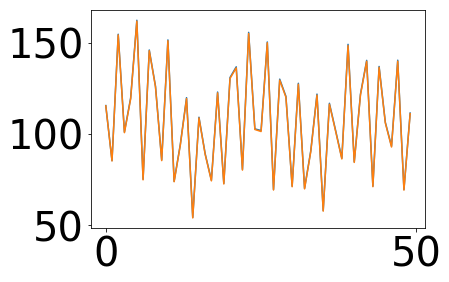

In [36]:
plt.plot(pred_num_4h)
plt.plot(pred_num_4h_sim)

In [37]:
#print(pred_num_4h, real_num_4h, pai_4h)
print(np.mean(pred_num_4h), np.mean(real_num_4h), np.mean(pai_4h), 
      np.median(pred_num_4h), np.median(real_num_4h), np.median(pai_4h))

print(np.mean(pred_num_4h_sim), np.mean(real_num_4h_sim), np.mean(pai_4h_sim), 
      np.median(pred_num_4h_sim), np.median(real_num_4h_sim), np.median(pai_4h_sim))

107.70016163435933 115.76 17.093042308767277 107.80223947430244 117.0 16.24946512623021
107.29643424137944 115.76 16.877430218415235 107.43955795976595 117.0 15.8894188305953


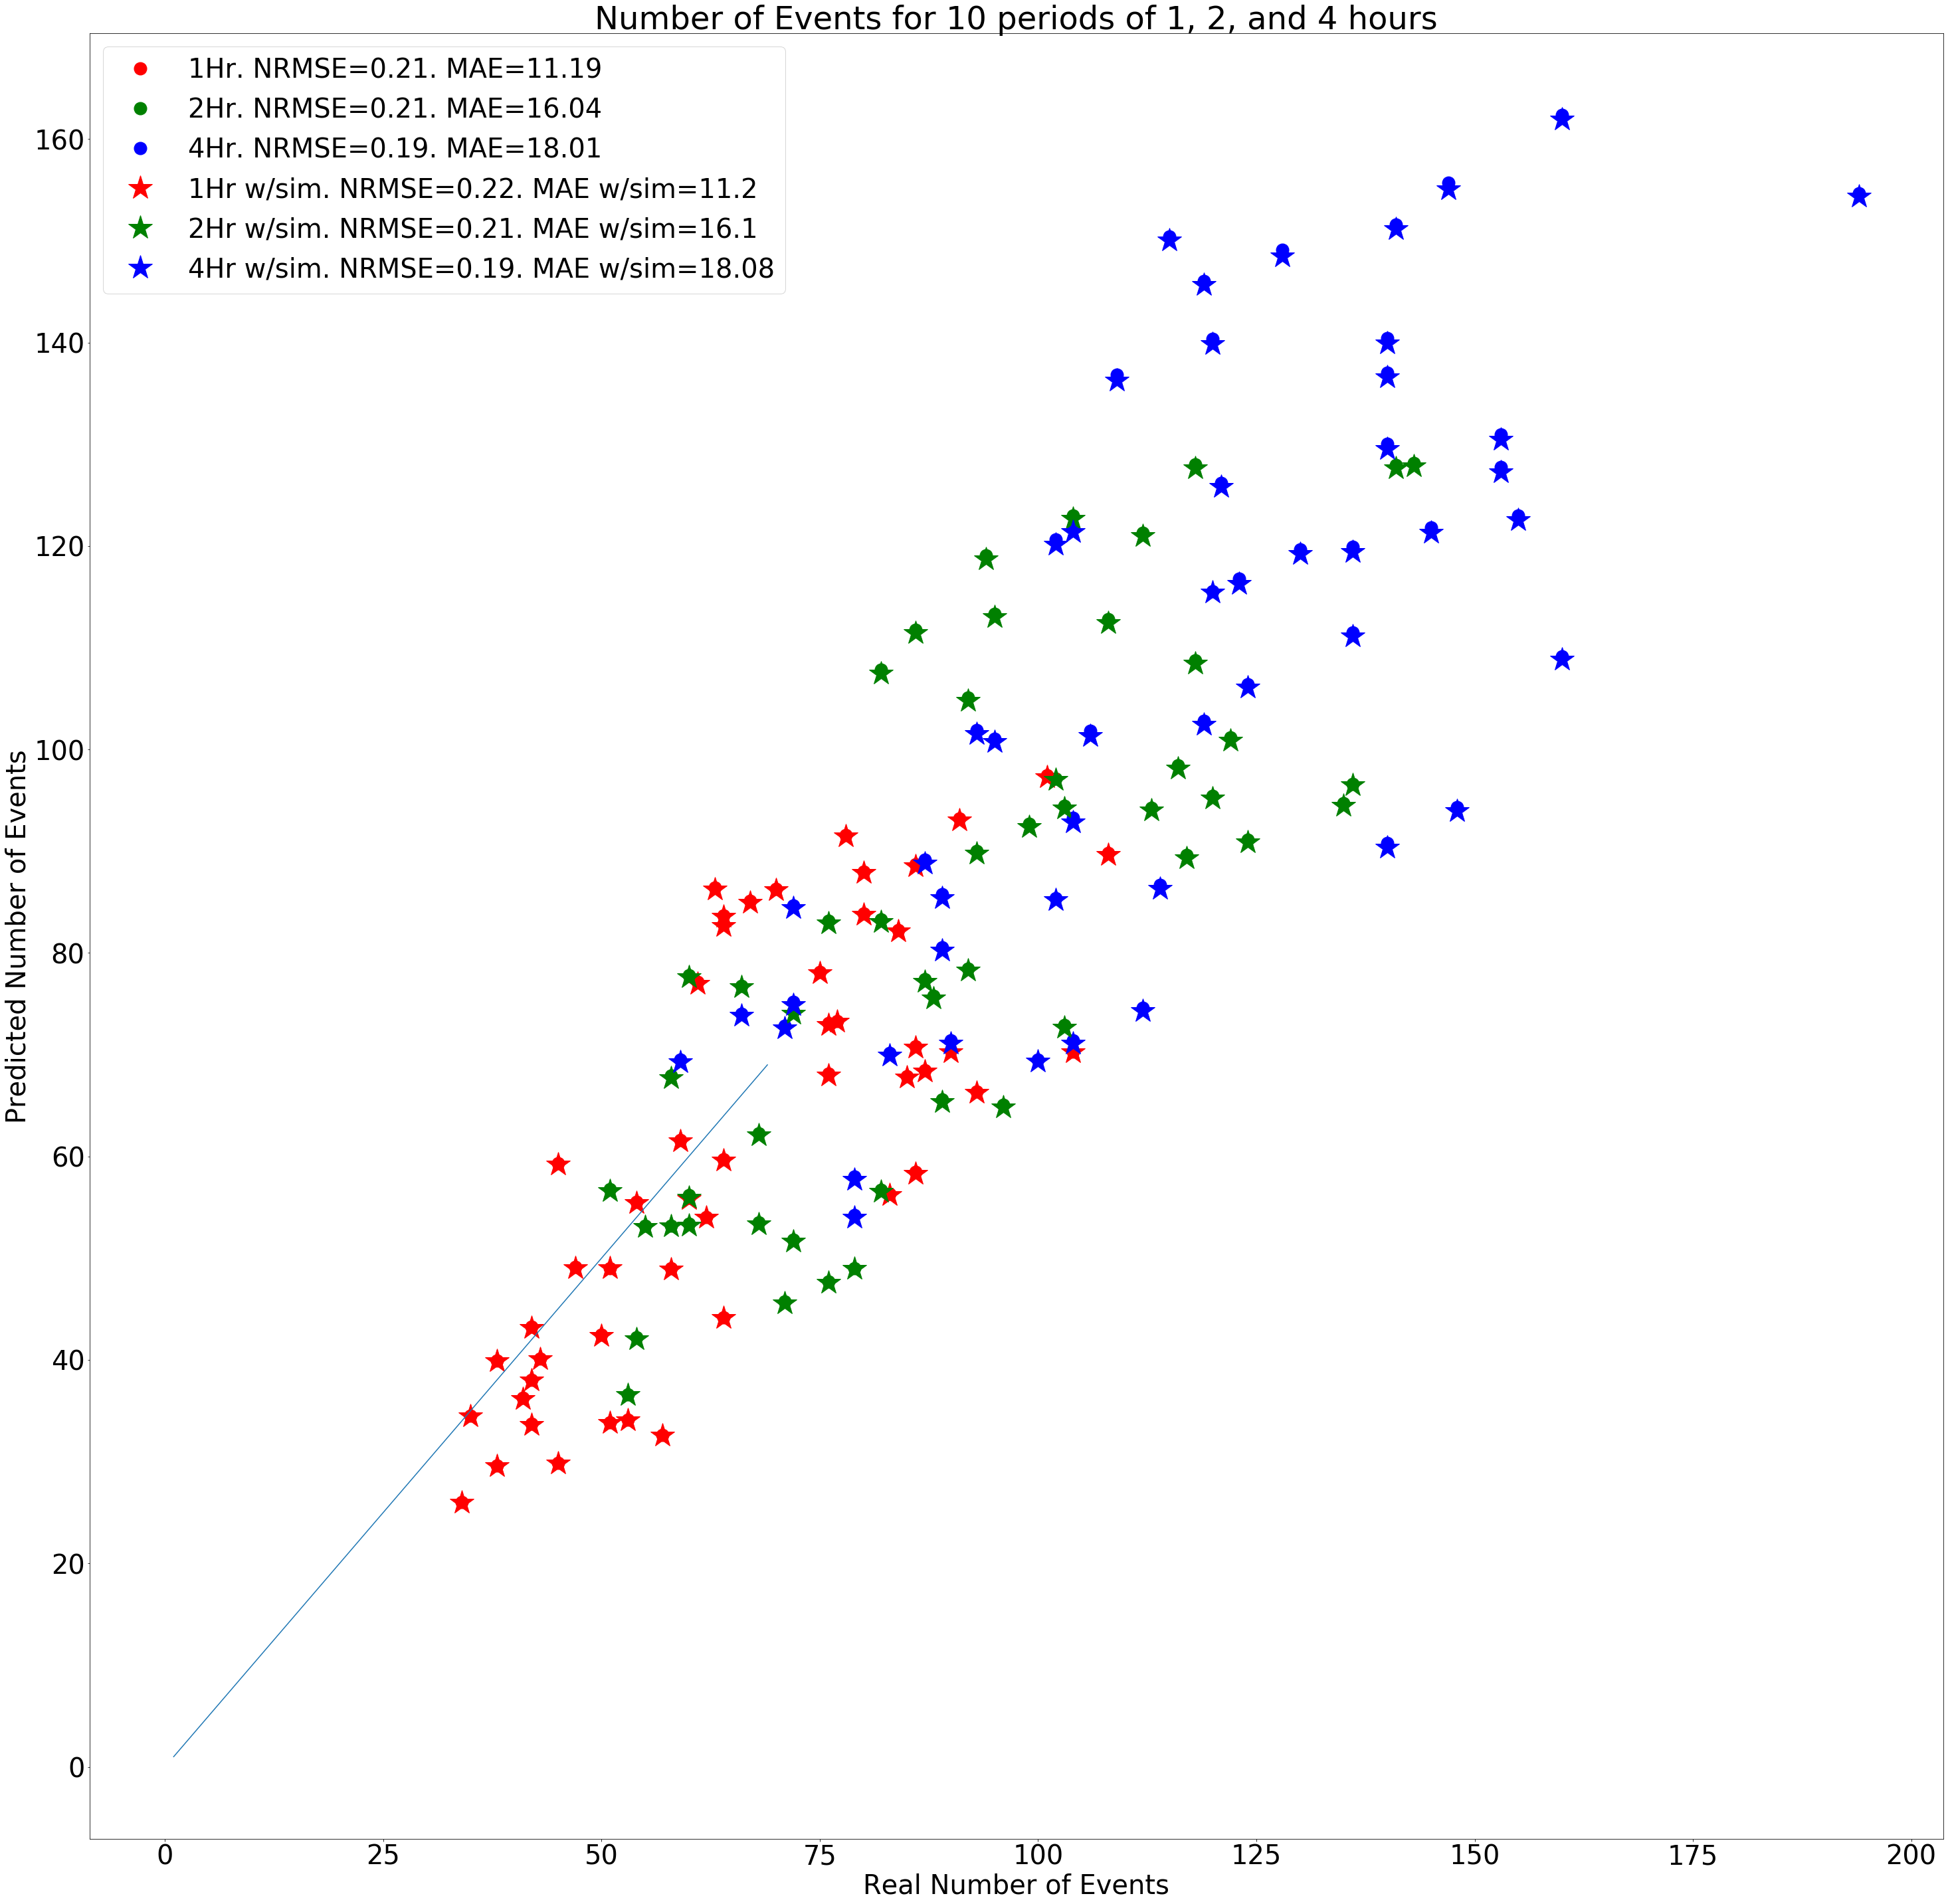

In [38]:
plt.rcParams.update({'font.size': 40, 'text.color' : "black",
                     'axes.labelcolor' : "black"})

import sklearn.metrics
rmse1 = sqrt(sklearn.metrics.mean_squared_error(real_num_1h, pred_num_1h))/ (np.mean(real_num_1h))
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))
rmse4 = sqrt(sklearn.metrics.mean_squared_error(real_num_4h, pred_num_4h))/(np.mean(real_num_4h))

rmse1_sim = sqrt(sklearn.metrics.mean_squared_error(real_num_1h_sim, pred_num_1h_sim))/ (np.mean(real_num_1h_sim))
rmse2_sim = sqrt(sklearn.metrics.mean_squared_error(real_num_2h_sim, pred_num_2h_sim))/ (np.mean(real_num_2h_sim))
rmse4_sim = sqrt(sklearn.metrics.mean_squared_error(real_num_4h_sim, pred_num_4h_sim))/ (np.mean(real_num_4h_sim))

mae1 = sklearn.metrics.mean_absolute_error(real_num_1h, pred_num_1h)
mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)
mae4 = sklearn.metrics.mean_absolute_error(real_num_4h, pred_num_4h)

mae1_sim = sklearn.metrics.mean_absolute_error(real_num_1h_sim, pred_num_1h_sim)
mae2_sim = sklearn.metrics.mean_absolute_error(real_num_2h_sim, pred_num_2h_sim)
mae4_sim = sklearn.metrics.mean_absolute_error(real_num_4h_sim, pred_num_4h_sim)

plt.figure(figsize=(50,50))
plt.plot(real_num_1h, pred_num_1h, 'r.', label = "1Hr. NRMSE="+str(round(rmse1, 2))+". MAE="+str(round(mae1, 2)), markersize=38)
plt.plot(real_num_2h, pred_num_2h, 'g.', label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=38)
plt.plot(real_num_4h, pred_num_4h, 'b.', label = "4Hr. NRMSE="+str(round(rmse4, 2))+". MAE="+str(round(mae4, 2)), markersize=38)
plt.plot(real_num_1h, pred_num_1h_sim, 'r.', label = "1Hr w/sim. NRMSE="+str(round(rmse1_sim, 2))+". MAE w/sim="+str(round(mae1_sim, 2)), markersize=38, marker='*')
plt.plot(real_num_2h, pred_num_2h_sim, 'g.', label = "2Hr w/sim. NRMSE="+str(round(rmse2_sim, 2))+". MAE w/sim="+str(round(mae2_sim, 2)), markersize=38, marker='*')
plt.plot(real_num_4h, pred_num_4h_sim, 'b.', label = "4Hr w/sim. NRMSE="+str(round(rmse4_sim, 2))+". MAE w/sim="+str(round(mae4_sim, 2)), markersize=38, marker='*')
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()
plt.title('Number of Events for 10 periods of 1, 2, and 4 hours')
x = np.arange(1, 70)
plt.plot(x, x)

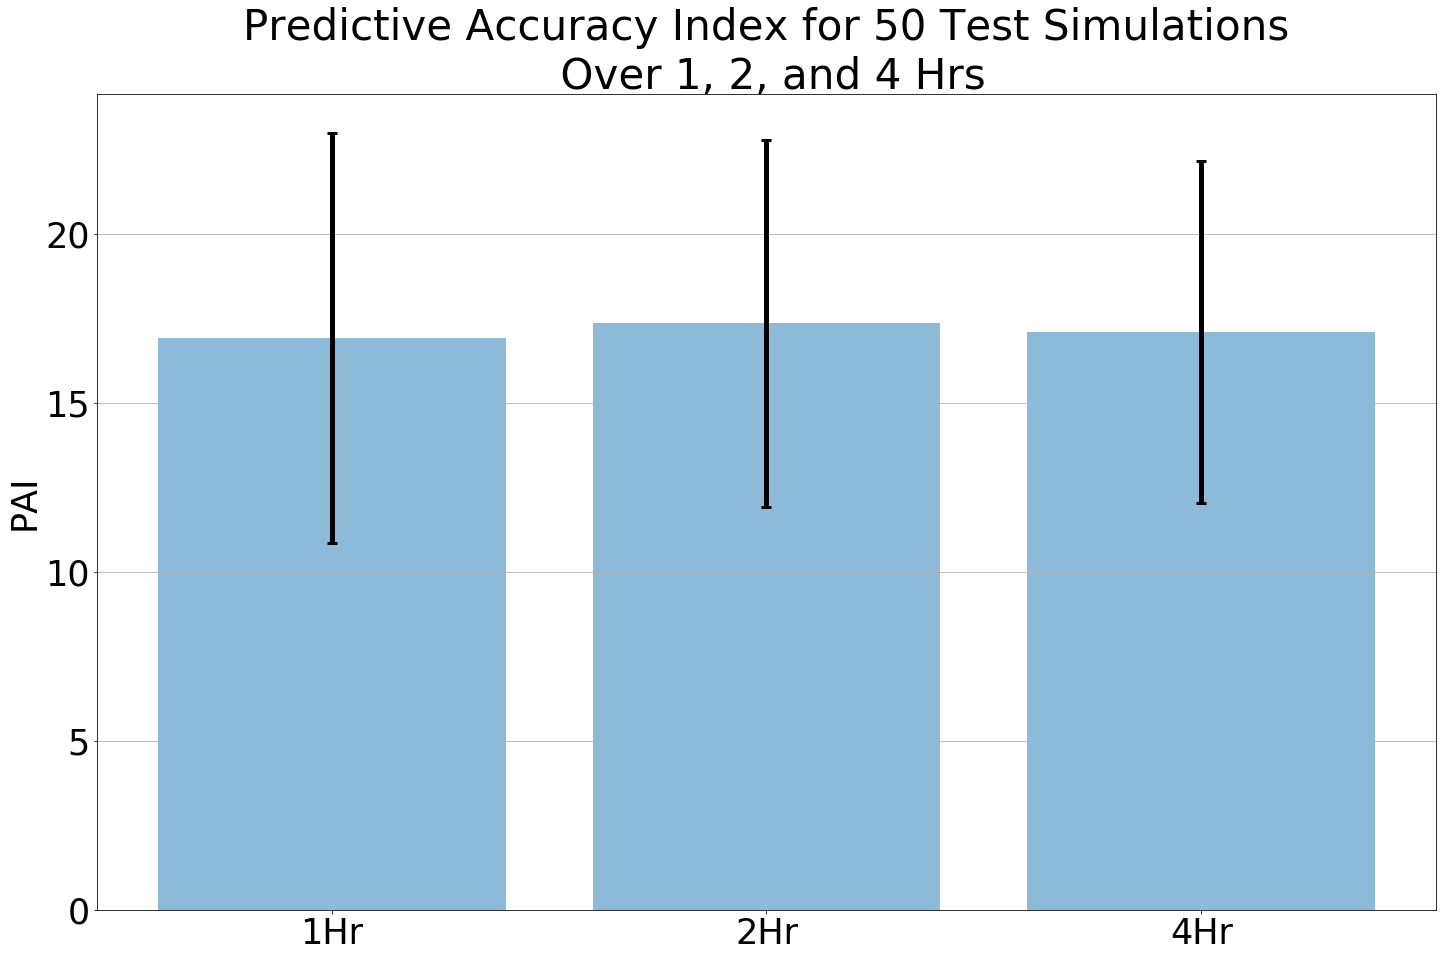

In [67]:
'''
labels=['1Hr',
        '1Hr w/sim',
        '2Hr', 
        '2Hr w/sim',
        '4Hr',
        '4Hr w/sim']

x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
        np.mean(pai_1h_sim),
        np.mean(pai_2h), 
        np.mean(pai_2h_sim),
        np.mean(pai_4h),
        np.mean(pai_4h_sim)]

error = [np.std(pai_1h),
         np.std(pai_1h_sim),
         np.std(pai_2h),
         np.std(pai_2h_sim),
         np.std(pai_4h), 
         np.std(pai_4h_sim)]
'''

labels=['1Hr',
        '2Hr', 
        '4Hr']

x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
        np.mean(pai_2h), 
        np.mean(pai_4h)]

error = [np.std(pai_1h),
         np.std(pai_2h),
         np.std(pai_4h)]

fig, ax = plt.subplots(figsize=(24,15))
# color=[11/255,122/255,117/255], 
ax.bar(x_pos, CTEs, yerr = error,alpha=0.5, ecolor='black', capsize=5,error_kw=dict(lw=5, capsize=5, capthick=3))
ax.set_ylabel("PAI")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.yaxis.grid(True)
plt.title("Predictive Accuracy Index for 50 Test Simulations\n Over 1, 2, and 4 Hrs")
plt.show()

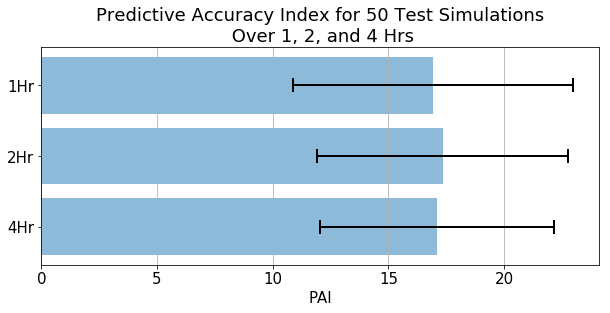

In [90]:
'''
labels=['1Hr',
        '1Hr w/sim',
        '2Hr', 
        '2Hr w/sim',
        '4Hr',
        '4Hr w/sim']

x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
        np.mean(pai_1h_sim),
        np.mean(pai_2h), 
        np.mean(pai_2h_sim),
        np.mean(pai_4h),
        np.mean(pai_4h_sim)]

error = [np.std(pai_1h),
         np.std(pai_1h_sim),
         np.std(pai_2h),
         np.std(pai_2h_sim),
         np.std(pai_4h), 
         np.std(pai_4h_sim)]
'''

plt.rcParams.update({'font.size': 15, 'text.color' : "black",
                     'axes.labelcolor' : "black"})
labels=['1Hr',
        '2Hr', 
        '4Hr']

x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
        np.mean(pai_2h), 
        np.mean(pai_4h)]

error = [np.std(pai_1h),
         np.std(pai_2h),
         np.std(pai_4h)]

fig, ax = plt.subplots(figsize=(10,4))
# color=[11/255,122/255,117/255], 
ax.barh(x_pos, CTEs, xerr = error,alpha=0.5, ecolor='black',error_kw=dict(lw=2, capsize=7, capthick=2))
ax.set_xlabel("PAI")
ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.xaxis.grid(True)
plt.title("Predictive Accuracy Index for 50 Test Simulations\n Over 1, 2, and 4 Hrs")
plt.show()

In [91]:
tosave = ax.get_figure()
tosave.savefig('pia.png', bbox_inches='tight')

#### What about peak time detection?

In [44]:
percentile = 80

In [45]:
simulation = PointProcessRun(param_location = 'GoodParameters!/Trained_Params_.npz', save_loc = 'PPtesting.npz')
print(simulation._LastTime)

max_iters = 160

last_t = simulation._LastTime
indices = []
for i in range(end-100000, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*2: # 2 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []
percentile_2h = []

labels = []

if len(indices)-2 < max_iters:
    max_iters=len(indices)

for i in range(0, max_iters):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, time, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_synthetic=False, time_step=15)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    labels.append(time)
    pai_2h.append(pai)
    percentile_2h.append(np.percentile(array(pred_num_2h), percentile))
    #test_points.to_csv('for_results.csv')
    msg = simulation.update_from_new_inputs(test_points)
    print(msg)

2016-06-27 10:21:07

Predicting over time of 0.0813774971 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.047619047619044. 
Hit number/Tot number: 0.16326530612244897. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.497292514551503

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.31314933922235416, Real: 1.0
Grid: (27, 22), Model: 0.2857632230970931, Real: 1.0
Grid: (33, 25), Model: 0.13880627754400435, Real: 1.0
Grid: (35, 32), Model: 0.11743445584596912, Real: 1.0
Grid: (28, 19), Model: 0.10610318564908401, Real: 1.0
Grid: (36, 23), Model: 0.10230500582394698, Real: 1.0
Grid: (26, 26), Model: 0.0977221086460014, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.25333634624732343, Real: 0.0
Grid: (26, 22), Model: 0.24383589901588995, Real: 0.0
Grid: (26, 23), Model: 0.14288712028992942, Real: 0.0
Grid: (28, 23), Model: 0.1342039204186913, Real: 0.0
Grid: (32, 25), Model:

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Parameters updated: 32 used for update ranging from: 2016-06-27 16:28:37 to 2016-06-27 18:26:17.Parameters updated: 32 used for update ranging from: 2016-06-27 16:28:37 to 2016-06-27 18:26:17. Params also saved.

Predicting over time of 0.0832293531 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 43.333333333333336. 
Hit number/Tot number: 0.37142857142857144. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.69869136729616

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.36590272685708697, Real: 2.0
Grid: (27, 22), Model: 0.34025336500582193, Real: 1.0
Grid: (26, 22), Model: 0.2802344206161566, Real: 2.0
Grid: (28, 23), Model: 0.15235098911563252, Real: 2.0
Grid: (28, 24), Model: 0.140731599885561, Real: 1.0
Grid: (33, 23), Model: 0.14046540388387063, Real: 1.0
Grid: (27, 26), Model: 0.12997314731425533, Real: 2.0
Grid: (26, 29), Model: 0.12809028281336182, Real: 1.0
Grid: (51, 33), Model: 0.11780571

Parameters updated: 32 used for update ranging from: 2016-06-27 22:32:43 to 2016-06-28 00:31:15.Parameters updated: 32 used for update ranging from: 2016-06-27 22:32:43 to 2016-06-28 00:31:15. Params also saved.

Predicting over time of 0.083217779 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.875. 
Hit number/Tot number: 0.1875. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.89592448888693

Predicted hotspots in real top 30
Grid: (44, 32), Model: 0.06342820304808211, Real: 1.0
Grid: (47, 32), Model: 0.05903814130022605, Real: 1.0
Grid: (33, 24), Model: 0.054815899730177794, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1911695267286185, Real: 0.0
Grid: (27, 22), Model: 0.17487754878954256, Real: 0.0
Grid: (26, 22), Model: 0.1479748015019544, Real: 0.0
Grid: (27, 24), Model: 0.14786524669912257, Real: 0.0
Grid: (33, 25), Model: 0.08798174510049156, Real: 0.0
Grid: (28, 23), M

Parameters updated: 15 used for update ranging from: 2016-06-28 04:44:22 to 2016-06-28 06:37:26.Parameters updated: 15 used for update ranging from: 2016-06-28 04:44:22 to 2016-06-28 06:37:26. Params also saved.

Predicting over time of 0.0825464812 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.66157087810258

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.13980671810699313, Real: 1.0
Grid: (29, 22), Model: 0.06324827263214472, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.17615226620065874, Real: 0.0
Grid: (27, 22), Model: 0.1641564988851306, Real: 0.0
Grid: (26, 22), Model: 0.1363549404890871, Real: 0.0
Grid: (33, 25), Model: 0.0811304312011184, Real: 0.0
Grid: (26, 23), Model: 0.07914807449817471, Real: 0.0
Grid: (28, 23), Model: 0.07837191507057371, Real: 0.0
Grid: (28

Parameters updated: 36 used for update ranging from: 2016-06-28 11:01:25 to 2016-06-28 12:58:51.Parameters updated: 36 used for update ranging from: 2016-06-28 11:01:25 to 2016-06-28 12:58:51. Params also saved.

Predicting over time of 0.0798034195 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.773682434688475

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.2938780809908115, Real: 2.0
Grid: (26, 26), Model: 0.11588842978344085, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3625537855958499, Real: 0.0
Grid: (27, 22), Model: 0.33699841690497107, Real: 0.0
Grid: (26, 22), Model: 0.2806202509330442, Real: 0.0
Grid: (33, 25), Model: 0.1670498794813347, Real: 0.0
Grid: (26, 23), Model: 0.1622198004135131, Real: 0.0
Grid: (28, 23), Model: 0.15898547445890016, Real

Parameters updated: 30 used for update ranging from: 2016-06-28 17:30:56 to 2016-06-28 19:28:10.Parameters updated: 30 used for update ranging from: 2016-06-28 17:30:56 to 2016-06-28 19:28:10. Params also saved.

Predicting over time of 0.0696876561 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.1710612101233

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.26652313833702357, Real: 1.0
Grid: (32, 25), Model: 0.125826903881671, Real: 1.0
Grid: (37, 23), Model: 0.10722140579079442, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32941268822105446, Real: 0.0
Grid: (27, 22), Model: 0.31113163919583997, Real: 0.0
Grid: (27, 24), Model: 0.2882021606088701, Real: 0.0
Grid: (33, 25), Model: 0.15179732150567626, Real: 0.0
Grid: (28, 23), Model: 0.14858572452427377, Real: 0.0
Grid: (26,


The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.243487719081893

Predicted hotspots in real top 30
Grid: (34, 24), Model: 0.055996233560091306, Real: 1.0
Grid: (33, 24), Model: 0.04334715824966638, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1446260423287583, Real: 0.0
Grid: (27, 22), Model: 0.13606714587525365, Real: 0.0
Grid: (27, 24), Model: 0.1250011531640426, Real: 0.0
Grid: (26, 22), Model: 0.11852117250122965, Real: 0.0
Grid: (33, 25), Model: 0.07163078774757636, Real: 0.0
Grid: (26, 23), Model: 0.06689711925485994, Real: 0.0
Grid: (28, 23), Model: 0.06426170706994189, Real: 0.0
Grid: (27, 31), Model: 0.06220277960714063, Real: 0.0
Grid: (27, 26), Model: 0.0591991285233636, Real: 0.0
Grid: (28, 24), Model: 0.05871762086469054, Real: 0.0
Grid: (32, 25), Model: 0.0575976322009657, Real: 0.0
Grid: (29, 22), 

Parameters updated: 19 used for update ranging from: 2016-06-29 07:56:20 to 2016-06-29 09:56:00.Parameters updated: 19 used for update ranging from: 2016-06-29 07:56:20 to 2016-06-29 09:56:00. Params also saved.

Predicting over time of 0.0831946308 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.362318840579707. 
Hit number/Tot number: 0.21739130434782608. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.544879591606023

Predicted hotspots in real top 30
Grid: (34, 24), Model: 0.09994027626284219, Real: 1.0
Grid: (27, 26), Model: 0.09977044887024696, Real: 1.0
Grid: (26, 26), Model: 0.09429458116374625, Real: 1.0
Grid: (33, 24), Model: 0.07788348732766412, Real: 1.0
Grid: (26, 27), Model: 0.07497081606255582, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.24800471011996839, Real: 0.0
Grid: (27, 22), Model: 0.23240897652273862, Real: 0.0
Grid: (27, 24), Model: 0.21154973625254828,

Parameters updated: 42 used for update ranging from: 2016-06-29 14:00:31 to 2016-06-29 15:58:17.Parameters updated: 42 used for update ranging from: 2016-06-29 14:00:31 to 2016-06-29 15:58:17. Params also saved.

Predicting over time of 0.0820140726 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.99261528807933

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.33864878319471736, Real: 1.0
Grid: (27, 22), Model: 0.322411550508385, Real: 1.0
Grid: (32, 25), Model: 0.13971366868695326, Real: 1.0
Grid: (35, 32), Model: 0.1352450263609787, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.29241815357490963, Real: 0.0
Grid: (26, 22), Model: 0.27817634953811143, Real: 0.0
Grid: (33, 25), Model: 0.1641371674768013, Real: 0.0
Grid: (26, 23), Model: 0.15412520345510222, Real: 0.0
Grid: (2

Parameters updated: 29 used for update ranging from: 2016-06-29 20:18:48 to 2016-06-29 22:17:01.Parameters updated: 29 used for update ranging from: 2016-06-29 20:18:48 to 2016-06-29 22:17:01. Params also saved.

Predicting over time of 0.0777548038 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 22.435897435897434. 
Hit number/Tot number: 0.19230769230769232. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.786271351977046

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.1154138207408115, Real: 2.0
Grid: (29, 22), Model: 0.11263442240778695, Real: 1.0
Grid: (26, 29), Model: 0.09177835335156598, Real: 1.0
Grid: (37, 23), Model: 0.09133238001894775, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2873522406666791, Real: 0.0
Grid: (27, 22), Model: 0.26415163532168295, Real: 0.0
Grid: (27, 24), Model: 0.2392008950629781, Real: 0.0
Grid: (26, 22), Model: 0.2234068031798845, Rea


The predictive accuracy index for 30 hotspots is: 9.722222222222221. 
Hit number/Tot number: 0.08333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.732970673915313

Predicted hotspots in real top 30
Grid: (28, 19), Model: 0.039716042345174035, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.10992340894385788, Real: 0.0
Grid: (27, 22), Model: 0.10299056061938457, Real: 0.0
Grid: (27, 24), Model: 0.09121096588557416, Real: 0.0
Grid: (26, 22), Model: 0.08554484644296581, Real: 0.0
Grid: (33, 25), Model: 0.050550665412394453, Real: 0.0
Grid: (27, 31), Model: 0.04768811144343718, Real: 0.0
Grid: (26, 23), Model: 0.047620502655679936, Real: 0.0
Grid: (28, 23), Model: 0.044985049253863735, Real: 0.0
Grid: (35, 32), Model: 0.04470882197343829, Real: 0.0
Grid: (29, 22), Model: 0.04445463598111227, Real: 0.0
Grid: (32, 25), Model: 0.044357076738238264, Real: 0.0
Grid: (28, 24), Model: 0.04385740529224907, Real: 0.0
Grid: (3

Parameters updated: 33 used for update ranging from: 2016-06-30 08:49:44 to 2016-06-30 10:49:32.Parameters updated: 33 used for update ranging from: 2016-06-30 08:49:44 to 2016-06-30 10:49:32. Params also saved.

Predicting over time of 0.0813312007 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.144927536231883. 
Hit number/Tot number: 0.08695652173913043. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 26.763020275774775

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.11094373135155672, Real: 1.0
Grid: (36, 24), Model: 0.08527434276406612, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2759526980205332, Real: 0.0
Grid: (27, 22), Model: 0.25857495052260615, Real: 0.0
Grid: (27, 24), Model: 0.23387105717984613, Real: 0.0
Grid: (26, 22), Model: 0.2112300350093636, Real: 0.0
Grid: (33, 25), Model: 0.1248691023462373, Real: 0.0
Grid: (26, 23), Model: 0.12246675291755876, Re

Parameters updated: 31 used for update ranging from: 2016-06-30 14:59:32 to 2016-06-30 16:54:56.Parameters updated: 31 used for update ranging from: 2016-06-30 14:59:32 to 2016-06-30 16:54:56. Params also saved.

Predicting over time of 0.0819562021 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.32526235936826

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3542097608637187, Real: 1.0
Grid: (32, 25), Model: 0.13758389109862212, Real: 1.0
Grid: (27, 26), Model: 0.13260954696130783, Real: 1.0
Grid: (29, 20), Model: 0.11860657794342562, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3318291379804434, Real: 0.0
Grid: (27, 24), Model: 0.2998558674517091, Real: 0.0
Grid: (26, 22), Model: 0.2674644560042938, Real: 0.0
Grid: (33, 25), Model: 0.16364285620426697, Real:

Parameters updated: 26 used for update ranging from: 2016-06-30 21:07:49 to 2016-06-30 23:02:16.Parameters updated: 26 used for update ranging from: 2016-06-30 21:07:49 to 2016-06-30 23:02:16. Params also saved.

Predicting over time of 0.0826853704 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 33.33333333333333. 
Hit number/Tot number: 0.2857142857142857. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.646481701621703

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.23886382429257275, Real: 1.0
Grid: (33, 25), Model: 0.11572552785464701, Real: 1.0
Grid: (29, 20), Model: 0.08825395458510951, Real: 1.0
Grid: (26, 29), Model: 0.08567832093154251, Real: 1.0
Grid: (51, 33), Model: 0.08490322357824638, Real: 1.0
Grid: (36, 23), Model: 0.07728546842267377, Real: 1.0
Grid: (24, 29), Model: 0.07724097378351745, Real: 1.0
Grid: (26, 27), Model: 0.07630664315982454, Real: 1.0

Predicted hotstpots not in rea

Parameters updated: 16 used for update ranging from: 2016-07-01 03:23:08 to 2016-07-01 05:22:36.Parameters updated: 16 used for update ranging from: 2016-07-01 03:23:08 to 2016-07-01 05:22:36. Params also saved.

Predicting over time of 0.0751969277 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 29.166666666666664. 
Hit number/Tot number: 0.25. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.902883157714047

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.14770561837256993, Real: 1.0
Grid: (27, 31), Model: 0.0649583795886733, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15243591529020503, Real: 0.0
Grid: (27, 24), Model: 0.12849331711798617, Real: 0.0
Grid: (26, 22), Model: 0.1144561776059181, Real: 0.0
Grid: (33, 25), Model: 0.07446837009738476, Real: 0.0
Grid: (26, 23), Model: 0.0656512669705073, Real: 0.0
Grid: (28, 23), Model: 0.06156994274024906, Real: 0.0
Grid: (

Parameters updated: 31 used for update ranging from: 2016-07-01 10:13:07 to 2016-07-01 12:10:27.Parameters updated: 31 used for update ranging from: 2016-07-01 10:13:07 to 2016-07-01 12:10:27. Params also saved.

Predicting over time of 0.0785302685 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.416666666666664. 
Hit number/Tot number: 0.175. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.72111198176401

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.34725649979171236, Real: 1.0
Grid: (26, 22), Model: 0.2577033343886377, Real: 2.0
Grid: (29, 20), Model: 0.1326327876388117, Real: 2.0
Grid: (26, 29), Model: 0.11858078108629844, Real: 1.0
Grid: (33, 1), Model: 0.11182028142581894, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.34024521380268513, Real: 0.0
Grid: (27, 24), Model: 0.28655013014115394, Real: 0.0
Grid: (33, 25), Model: 0.16536626534174642, Real: 0.0
Grid: (

Parameters updated: 32 used for update ranging from: 2016-07-01 16:28:40 to 2016-07-01 18:27:03.Parameters updated: 32 used for update ranging from: 2016-07-01 16:28:40 to 2016-07-01 18:27:03. Params also saved.

Predicting over time of 0.0817710165 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 38.32476121393577

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.40623420242029856, Real: 1.0
Grid: (26, 22), Model: 0.3008933540558768, Real: 1.0
Grid: (29, 20), Model: 0.15858892365444902, Real: 1.0
Grid: (35, 32), Model: 0.1500994720203479, Real: 1.0
Grid: (37, 23), Model: 0.13382556711649168, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.39638223003074097, Real: 0.0
Grid: (27, 24), Model: 0.33803339410956657, Real: 0.0
Grid: (33, 25), Model: 0.19047253029253364, Re

Parameters updated: 25 used for update ranging from: 2016-07-01 22:34:24 to 2016-07-02 00:31:45.Parameters updated: 25 used for update ranging from: 2016-07-01 22:34:24 to 2016-07-02 00:31:45. Params also saved.

Predicting over time of 0.0814006453 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.606060606060606. 
Hit number/Tot number: 0.09090909090909091. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 18.121775192356445

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.07988224136593224, Real: 1.0
Grid: (31, 22), Model: 0.055406858340674506, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.19423738280670635, Real: 0.0
Grid: (27, 22), Model: 0.1894820431798087, Real: 0.0
Grid: (27, 24), Model: 0.1564859750270417, Real: 0.0
Grid: (26, 22), Model: 0.14598869051576435, Real: 0.0
Grid: (33, 25), Model: 0.08819027576746251, Real: 0.0
Grid: (34, 24), Model: 0.07938140059499643, 


The predictive accuracy index for 30 hotspots is: 24.999999999999996. 
Hit number/Tot number: 0.21428571428571427. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.166632018325977

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.16606397876809856, Real: 1.0
Grid: (26, 26), Model: 0.06239655362343389, Real: 1.0
Grid: (26, 27), Model: 0.053800865241311044, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.17097030848669095, Real: 0.0
Grid: (27, 24), Model: 0.13796542810557455, Real: 0.0
Grid: (26, 22), Model: 0.1288124248203318, Real: 0.0
Grid: (33, 25), Model: 0.07776308783714904, Real: 0.0
Grid: (27, 31), Model: 0.07295377137422161, Real: 0.0
Grid: (34, 24), Model: 0.06955819414376938, Real: 0.0
Grid: (35, 32), Model: 0.06942022672650669, Real: 0.0
Grid: (26, 23), Model: 0.06888608792729307, Real: 0.0
Grid: (29, 20), Model: 0.06822101872292256, Real: 0.0
Grid: (27, 26), Model: 0.06766900993552646, Real: 0.0
Grid: (28, 2

Parameters updated: 34 used for update ranging from: 2016-07-02 11:03:17 to 2016-07-02 13:00:20.Parameters updated: 34 used for update ranging from: 2016-07-02 11:03:17 to 2016-07-02 13:00:20. Params also saved.

Predicting over time of 0.0810881446 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.225225225225227. 
Hit number/Tot number: 0.21621621621621623. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.56231826466244

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.39151928952029663, Real: 1.0
Grid: (27, 24), Model: 0.34218755854967997, Real: 1.0
Grid: (26, 22), Model: 0.3020660302777759, Real: 1.0
Grid: (33, 25), Model: 0.17830302726722527, Real: 2.0
Grid: (32, 25), Model: 0.1578855224939494, Real: 1.0
Grid: (27, 26), Model: 0.15435565969265294, Real: 1.0
Grid: (29, 22), Model: 0.14486256844370102, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.39778530092219944, Re

Parameters updated: 36 used for update ranging from: 2016-07-02 17:18:04 to 2016-07-02 19:07:43.Parameters updated: 36 used for update ranging from: 2016-07-02 17:18:04 to 2016-07-02 19:07:43. Params also saved.

Predicting over time of 0.0792594368 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 30.24691358024691. 
Hit number/Tot number: 0.25925925925925924. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.26268144269255

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.402902247609602, Real: 2.0
Grid: (26, 22), Model: 0.29923606312944073, Real: 2.0
Grid: (29, 20), Model: 0.14860714584224732, Real: 2.0
Grid: (33, 24), Model: 0.11349498913970384, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3868288810222208, Real: 0.0
Grid: (27, 24), Model: 0.33568372581539674, Real: 0.0
Grid: (33, 25), Model: 0.18496841560441205, Real: 0.0
Grid: (27, 31), Model: 0.1615474538762712, Real:

Parameters updated: 19 used for update ranging from: 2016-07-02 23:30:07 to 2016-07-03 01:28:10.Parameters updated: 19 used for update ranging from: 2016-07-02 23:30:07 to 2016-07-03 01:28:10. Params also saved.

Predicting over time of 0.0645024593 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 32.407407407407405. 
Hit number/Tot number: 0.2777777777777778. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 12.209771822545227

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.10265416087640027, Real: 1.0
Grid: (29, 20), Model: 0.051599673454709956, Real: 1.0
Grid: (26, 23), Model: 0.05087694899594327, Real: 1.0
Grid: (26, 29), Model: 0.04069416764025478, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.13497824827192398, Real: 0.0
Grid: (27, 23), Model: 0.12526457793328377, Real: 0.0
Grid: (27, 24), Model: 0.10978733341576212, Real: 0.0
Grid: (33, 25), Model: 0.05955382857341813,

Parameters updated: 23 used for update ranging from: 2016-07-03 08:10:59 to 2016-07-03 09:56:37.Parameters updated: 23 used for update ranging from: 2016-07-03 08:10:59 to 2016-07-03 09:56:37. Params also saved.

Predicting over time of 0.0815163863 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 5.0724637681159415. 
Hit number/Tot number: 0.043478260869565216. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.593832136813724

Predicted hotspots in real top 30
Grid: (26, 27), Model: 0.08697867602878687, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.272224962284609, Real: 0.0
Grid: (27, 23), Model: 0.2500163850581571, Real: 0.0
Grid: (27, 24), Model: 0.2207437200338943, Real: 0.0
Grid: (26, 22), Model: 0.20985461097209307, Real: 0.0
Grid: (33, 25), Model: 0.1181359480870703, Real: 0.0
Grid: (34, 24), Model: 0.10949731724825494, Real: 0.0
Grid: (27, 26), Model: 0.10598313526674123, Rea

Parameters updated: 32 used for update ranging from: 2016-07-03 14:21:56 to 2016-07-03 16:15:53.Parameters updated: 32 used for update ranging from: 2016-07-03 14:21:56 to 2016-07-03 16:15:53. Params also saved.

Predicting over time of 0.0820835172 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 4.022988505747126. 
Hit number/Tot number: 0.034482758620689655. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.7656512895856

Predicted hotspots in real top 30
Grid: (28, 19), Model: 0.11459996839562084, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.359623427168835, Real: 0.0
Grid: (27, 23), Model: 0.33002288312427003, Real: 0.0
Grid: (27, 24), Model: 0.2885256895636465, Real: 0.0
Grid: (26, 22), Model: 0.27933458057421295, Real: 0.0
Grid: (33, 25), Model: 0.1553664485700119, Real: 0.0
Grid: (34, 24), Model: 0.14286122407808696, Real: 0.0
Grid: (26, 23), Model: 0.13945264167703952, Real:

Parameters updated: 26 used for update ranging from: 2016-07-03 20:39:07 to 2016-07-03 22:35:41.Parameters updated: 26 used for update ranging from: 2016-07-03 20:39:07 to 2016-07-03 22:35:41. Params also saved.

Predicting over time of 0.0697455266 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.28684523966016

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.24963572390032412, Real: 0.0
Grid: (27, 23), Model: 0.23226898173187613, Real: 0.0
Grid: (27, 24), Model: 0.20539737697019453, Real: 0.0
Grid: (26, 22), Model: 0.19422732740850077, Real: 0.0
Grid: (33, 25), Model: 0.11266954866704962, Real: 0.0
Grid: (34, 24), Model: 0.09962120025074113, Real: 0.0
Grid: (26, 23), Model: 0.09808185126383447, Real: 0.0
Grid: (27, 31), Model: 0.09685763011117877, Real: 0.0
Grid: (27, 26), Model

Parameters updated: 15 used for update ranging from: 2016-07-04 02:50:25 to 2016-07-04 04:45:19.Parameters updated: 15 used for update ranging from: 2016-07-04 02:50:25 to 2016-07-04 04:45:19. Params also saved.

Predicting over time of 0.0808798108 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.94871794871795. 
Hit number/Tot number: 0.15384615384615385. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.566175983975382

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.04354892393191756, Real: 1.0
Grid: (33, 1), Model: 0.034469385123064286, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.1134394645198627, Real: 0.0
Grid: (27, 23), Model: 0.1050584127508218, Real: 0.0
Grid: (27, 24), Model: 0.09207282841052618, Real: 0.0
Grid: (26, 22), Model: 0.09069812216681547, Real: 0.0
Grid: (33, 25), Model: 0.05060383896892173, Real: 0.0
Grid: (34, 24), Model: 0.04474103634364642, Re


The predictive accuracy index for 30 hotspots is: 13.461538461538462. 
Hit number/Tot number: 0.11538461538461539. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.925551615050583

Predicted hotspots in real top 30
Grid: (26, 23), Model: 0.11696888666809019, Real: 1.0
Grid: (44, 32), Model: 0.09752865942963412, Real: 1.0
Grid: (51, 33), Model: 0.09547331870325718, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2962269981040996, Real: 0.0
Grid: (27, 23), Model: 0.2813866566848002, Real: 0.0
Grid: (27, 24), Model: 0.24119508653397528, Real: 0.0
Grid: (26, 22), Model: 0.23614916443965328, Real: 0.0
Grid: (33, 25), Model: 0.13277503840381064, Real: 0.0
Grid: (28, 23), Model: 0.11807689192963128, Real: 0.0
Grid: (34, 24), Model: 0.11740841267984911, Real: 0.0
Grid: (27, 31), Model: 0.1155684925816639, Real: 0.0
Grid: (27, 26), Model: 0.11366233354259542, Real: 0.0
Grid: (29, 20), Model: 0.11097272780562528, Real: 0.0
Grid: (32, 25),

Parameters updated: 28 used for update ranging from: 2016-07-04 17:22:19 to 2016-07-04 19:21:34.Parameters updated: 28 used for update ranging from: 2016-07-04 17:22:19 to 2016-07-04 19:21:34. Params also saved.

Predicting over time of 0.0815858309 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 28.282828282828284. 
Hit number/Tot number: 0.24242424242424243. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.42612027210768

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3466888244038081, Real: 1.0
Grid: (27, 23), Model: 0.33179098404957363, Real: 1.0
Grid: (26, 22), Model: 0.28054689142577627, Real: 1.0
Grid: (28, 23), Model: 0.14271727203937754, Real: 1.0
Grid: (28, 24), Model: 0.13312694118140297, Real: 1.0
Grid: (29, 20), Model: 0.13016242981040113, Real: 1.0
Grid: (26, 27), Model: 0.12141231101252935, Real: 1.0
Grid: (33, 24), Model: 0.0995593592092651, Real: 1.0

Predicted hotstpots not in real

Parameters updated: 36 used for update ranging from: 2016-07-04 23:32:18 to 2016-07-05 01:30:15.Parameters updated: 36 used for update ranging from: 2016-07-04 23:32:18 to 2016-07-05 01:30:15. Params also saved.

Predicting over time of 0.0774538772 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.246271191968106

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.15971155527435763, Real: 2.0
Grid: (28, 24), Model: 0.061809135959011836, Real: 1.0
Grid: (36, 24), Model: 0.05013390626300074, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15139290791944218, Real: 0.0
Grid: (26, 22), Model: 0.13241697668336114, Real: 0.0
Grid: (27, 24), Model: 0.13176827690080412, Real: 0.0
Grid: (33, 25), Model: 0.07001692852221322, Real: 0.0
Grid: (28, 23), Model: 0.06790579570579802, Real: 0.0
Grid


The predictive accuracy index for 30 hotspots is: 7.777777777777778. 
Hit number/Tot number: 0.06666666666666667. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 20.3707324400519

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.17431508048970867, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2208858327171958, Real: 0.0
Grid: (27, 23), Model: 0.2014489915655903, Real: 0.0
Grid: (26, 22), Model: 0.1740184654517004, Real: 0.0
Grid: (33, 25), Model: 0.09317943455012681, Real: 0.0
Grid: (28, 23), Model: 0.08871980284002942, Real: 0.0
Grid: (29, 20), Model: 0.085817864826787, Real: 0.0
Grid: (34, 24), Model: 0.08576943419036195, Real: 0.0
Grid: (26, 23), Model: 0.0851702554575915, Real: 0.0
Grid: (28, 24), Model: 0.08475756528296675, Real: 0.0
Grid: (35, 32), Model: 0.08471534438054683, Real: 0.0
Grid: (27, 26), Model: 0.08249072132354744, Real: 0.0
Grid: (27, 31), Model: 0.08207096858763746, Real: 0.0
Grid: (29, 22), Model

Parameters updated: 30 used for update ranging from: 2016-07-05 14:19:36 to 2016-07-05 16:15:00.Parameters updated: 30 used for update ranging from: 2016-07-05 14:19:36 to 2016-07-05 16:15:00. Params also saved.

Predicting over time of 0.0825117589 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.875. 
Hit number/Tot number: 0.1875. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.233102339021194

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.2987704902893454, Real: 2.0
Grid: (33, 25), Model: 0.1547766654481763, Real: 1.0
Grid: (28, 19), Model: 0.12462095899204771, Real: 1.0
Grid: (44, 32), Model: 0.12435722739022774, Real: 1.0
Grid: (27, 25), Model: 0.11056746504330851, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.37339452613046425, Real: 0.0
Grid: (27, 23), Model: 0.3346841173807681, Real: 0.0
Grid: (26, 22), Model: 0.29633967409601947, Real: 0.0
Grid: (28, 23), M

Parameters updated: 37 used for update ranging from: 2016-07-05 20:26:27 to 2016-07-05 22:20:15.Parameters updated: 37 used for update ranging from: 2016-07-05 20:26:27 to 2016-07-05 22:20:15. Params also saved.

Predicting over time of 0.0820719431 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.606060606060606. 
Hit number/Tot number: 0.09090909090909091. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.91557073997224

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3242140648787106, Real: 1.0
Grid: (47, 32), Model: 0.09388943351390491, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2935708644914858, Real: 0.0
Grid: (27, 24), Model: 0.269959135436763, Real: 0.0
Grid: (26, 22), Model: 0.25286920944966484, Real: 0.0
Grid: (29, 20), Model: 0.13933629832679373, Real: 0.0
Grid: (33, 25), Model: 0.1379940187912909, Real: 0.0
Grid: (28, 23), Model: 0.13214199309046665, Real:

Parameters updated: 14 used for update ranging from: 2016-07-06 02:48:28 to 2016-07-06 04:44:09.Parameters updated: 14 used for update ranging from: 2016-07-06 02:48:28 to 2016-07-06 04:44:09. Params also saved.

Predicting over time of 0.0795603634 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 11.051234907569121

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.12164459157775828, Real: 0.0
Grid: (27, 23), Model: 0.11146000208922036, Real: 0.0
Grid: (27, 24), Model: 0.09808829850282172, Real: 0.0
Grid: (26, 22), Model: 0.09227932940724191, Real: 0.0
Grid: (33, 25), Model: 0.050610462897591066, Real: 0.0
Grid: (29, 20), Model: 0.04999334513366767, Real: 0.0
Grid: (28, 23), Model: 0.04783527715873328, Real: 0.0
Grid: (34, 24), Model: 0.047732297984127744, Real: 0.0
Grid: (35, 32), Mo

Parameters updated: 33 used for update ranging from: 2016-07-06 08:54:17 to 2016-07-06 10:51:47.Parameters updated: 33 used for update ranging from: 2016-07-06 08:54:17 to 2016-07-06 10:51:47. Params also saved.

Predicting over time of 0.08327564949999999 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.612612612612613. 
Hit number/Tot number: 0.10810810810810811. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.5258278799632

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.24061005087161746, Real: 1.0
Grid: (28, 23), Model: 0.12158391502622669, Real: 1.0
Grid: (33, 1), Model: 0.08654398944034715, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3027335148115048, Real: 0.0
Grid: (27, 23), Model: 0.27481027196558316, Real: 0.0
Grid: (26, 22), Model: 0.2271282731691572, Real: 0.0
Grid: (33, 25), Model: 0.12503064136357234, Real: 0.0
Grid: (29, 20), Model: 0.1214496050174517

Parameters updated: 23 used for update ranging from: 2016-07-06 15:02:04 to 2016-07-06 16:54:37.Parameters updated: 23 used for update ranging from: 2016-07-06 15:02:04 to 2016-07-06 16:54:37. Params also saved.

Predicting over time of 0.0790395289 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.15686274509804. 
Hit number/Tot number: 0.14705882352941177. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.05145848989429

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.2773354004764518, Real: 1.0
Grid: (28, 23), Model: 0.1520993490948148, Real: 2.0
Grid: (35, 32), Model: 0.13929787361658977, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.36776373902520265, Real: 0.0
Grid: (27, 23), Model: 0.34706792000222775, Real: 0.0
Grid: (27, 24), Model: 0.30322915787765786, Real: 0.0
Grid: (33, 25), Model: 0.15840267858744406, Real: 0.0
Grid: (29, 20), Model: 0.14675919259790182, Rea

Parameters updated: 26 used for update ranging from: 2016-07-06 21:08:38 to 2016-07-06 23:08:00.Parameters updated: 26 used for update ranging from: 2016-07-06 21:08:38 to 2016-07-06 23:08:00. Params also saved.

Predicting over time of 0.0715626603 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 7.777777777777778. 
Hit number/Tot number: 0.06666666666666667. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 22.286961148079996

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.1945512495082976, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.23658110933677748, Real: 0.0
Grid: (27, 23), Model: 0.22707960010721473, Real: 0.0
Grid: (26, 22), Model: 0.18606966889761115, Real: 0.0
Grid: (33, 25), Model: 0.10552367068851631, Real: 0.0
Grid: (28, 23), Model: 0.1035050718118764, Real: 0.0
Grid: (35, 32), Model: 0.09625004809000723, Real: 0.0
Grid: (29, 20), Model: 0.0939789753284338, Rea

Parameters updated: 20 used for update ranging from: 2016-07-07 03:18:45 to 2016-07-07 05:14:11.Parameters updated: 20 used for update ranging from: 2016-07-07 03:18:45 to 2016-07-07 05:14:11. Params also saved.

Predicting over time of 0.0789585102 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 15.555555555555555. 
Hit number/Tot number: 0.13333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 12.05465593646004

Predicted hotspots in real top 30
Grid: (35, 32), Model: 0.05124449377803324, Real: 1.0
Grid: (27, 31), Model: 0.04675913036216215, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.12875317232851458, Real: 0.0
Grid: (27, 23), Model: 0.12171879529860143, Real: 0.0
Grid: (27, 24), Model: 0.10590713516073906, Real: 0.0
Grid: (26, 22), Model: 0.09966324430938181, Real: 0.0
Grid: (33, 25), Model: 0.058319136667946095, Real: 0.0
Grid: (28, 23), Model: 0.05472767752358275,


The predictive accuracy index for 30 hotspots is: 22.435897435897434. 
Hit number/Tot number: 0.19230769230769232. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 25.014393916337646

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.26446225801881135, Real: 1.0
Grid: (27, 23), Model: 0.25811918099065273, Real: 1.0
Grid: (51, 33), Model: 0.08840987061998276, Real: 1.0
Grid: (28, 19), Model: 0.08693338134728157, Real: 1.0
Grid: (33, 1), Model: 0.07942703973813944, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.21701810137578706, Real: 0.0
Grid: (26, 22), Model: 0.2047096923756023, Real: 0.0
Grid: (33, 25), Model: 0.1191579369853344, Real: 0.0
Grid: (35, 32), Model: 0.11226023329426146, Real: 0.0
Grid: (28, 23), Model: 0.11113774821730861, Real: 0.0
Grid: (29, 20), Model: 0.10306627959263392, Real: 0.0
Grid: (28, 24), Model: 0.1022878440459792, Real: 0.0
Grid: (34, 24), Model: 0.10224622743743525, Real: 0.0
Grid: (26, 23), 

Parameters updated: 28 used for update ranging from: 2016-07-07 15:51:02 to 2016-07-07 17:40:38.Parameters updated: 28 used for update ranging from: 2016-07-07 15:51:02 to 2016-07-07 17:40:38. Params also saved.

Predicting over time of 0.0817247201 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.520833333333332. 
Hit number/Tot number: 0.21875. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.971133036134574

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.35957735811254826, Real: 1.0
Grid: (27, 24), Model: 0.29055709306454813, Real: 1.0
Grid: (28, 23), Model: 0.152849378248096, Real: 1.0
Grid: (35, 32), Model: 0.14881380211613449, Real: 1.0
Grid: (26, 29), Model: 0.11705074369301162, Real: 1.0
Grid: (33, 1), Model: 0.11168210186181361, Real: 1.0
Grid: (33, 24), Model: 0.1037027521030124, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.36617097733644105, Real: 0.0
Grid:

Parameters updated: 34 used for update ranging from: 2016-07-07 22:10:19 to 2016-07-08 00:09:49.Parameters updated: 34 used for update ranging from: 2016-07-07 22:10:19 to 2016-07-08 00:09:49. Params also saved.

Predicting over time of 0.080439995 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 15.217391304347824. 
Hit number/Tot number: 0.13043478260869565. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 19.21474337637738

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.07509419934439554, Real: 1.0
Grid: (34, 23), Model: 0.06014533384405335, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2147859797718375, Real: 0.0
Grid: (27, 23), Model: 0.2022778519099647, Real: 0.0
Grid: (27, 24), Model: 0.1673054105304132, Real: 0.0
Grid: (26, 22), Model: 0.15326787305752348, Real: 0.0
Grid: (28, 23), Model: 0.09274739018094559, Real: 0.0
Grid: (33, 25), Model: 0.08857368836808747, Real

Parameters updated: 20 used for update ranging from: 2016-07-08 06:45:18 to 2016-07-08 08:43:52.Parameters updated: 20 used for update ranging from: 2016-07-08 06:45:18 to 2016-07-08 08:43:52. Params also saved.

Predicting over time of 0.0820256467 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.300439828713422

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2554718593671294, Real: 0.0
Grid: (27, 23), Model: 0.24114935414017807, Real: 0.0
Grid: (27, 24), Model: 0.20008259427884098, Real: 0.0
Grid: (26, 22), Model: 0.18459616198544096, Real: 0.0
Grid: (35, 32), Model: 0.1107284785410903, Real: 0.0
Grid: (33, 25), Model: 0.10972164413137685, Real: 0.0
Grid: (28, 23), Model: 0.10871584782385273, Real: 0.0
Grid: (32, 25), Model: 0.09789154165947007, Real: 0.0
Grid: (29, 20), Model:

Parameters updated: 37 used for update ranging from: 2016-07-08 12:53:02 to 2016-07-08 14:51:19.Parameters updated: 37 used for update ranging from: 2016-07-08 12:53:02 to 2016-07-08 14:51:19. Params also saved.

Predicting over time of 0.0754052615 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.65092378674739

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3631669481290446, Real: 2.0
Grid: (32, 25), Model: 0.14638101096214923, Real: 1.0
Grid: (26, 27), Model: 0.12892724189449953, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3948942508340909, Real: 0.0
Grid: (27, 24), Model: 0.3069399624629726, Real: 0.0
Grid: (26, 22), Model: 0.2844245263226787, Real: 0.0
Grid: (33, 25), Model: 0.1703629998182863, Real: 0.0
Grid: (35, 32), Model: 0.16987706361659882, Real: 0.0
Grid: (28

Parameters updated: 32 used for update ranging from: 2016-07-08 18:59:56 to 2016-07-08 20:55:48.Parameters updated: 32 used for update ranging from: 2016-07-08 18:59:56 to 2016-07-08 20:55:48. Params also saved.

Predicting over time of 0.0786460095 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.676767676767675. 
Hit number/Tot number: 0.15151515151515152. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.99027634333804

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.36515314034790075, Real: 2.0
Grid: (26, 22), Model: 0.2674630216452627, Real: 1.0
Grid: (34, 24), Model: 0.1329585154824981, Real: 1.0
Grid: (36, 24), Model: 0.11851821101943427, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.37900845140537215, Real: 0.0
Grid: (27, 24), Model: 0.29288243704012984, Real: 0.0
Grid: (33, 25), Model: 0.16436589439718036, Real: 0.0
Grid: (35, 32), Model: 0.1571944844959089, Rea

Parameters updated: 28 used for update ranging from: 2016-07-09 01:30:06 to 2016-07-09 03:26:19.Parameters updated: 28 used for update ranging from: 2016-07-09 01:30:06 to 2016-07-09 03:26:19. Params also saved.

Predicting over time of 0.0729052559 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 15.555555555555555. 
Hit number/Tot number: 0.13333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 11.89785232261728

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.10631317079458898, Real: 1.0
Grid: (28, 23), Model: 0.05332568738661041, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.13734833853182576, Real: 0.0
Grid: (27, 23), Model: 0.1284983293751391, Real: 0.0
Grid: (26, 22), Model: 0.09774353776328881, Real: 0.0
Grid: (33, 25), Model: 0.058083007297128855, Real: 0.0
Grid: (35, 32), Model: 0.05371581415002734, Real: 0.0
Grid: (27, 31), Model: 0.05033376209499804, 

Parameters updated: 34 used for update ranging from: 2016-07-09 10:10:44 to 2016-07-09 12:09:47.Parameters updated: 34 used for update ranging from: 2016-07-09 10:10:44 to 2016-07-09 12:09:47. Params also saved.

Predicting over time of 0.0823612956 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.918795379203324

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.37594722823114046, Real: 1.0
Grid: (27, 24), Model: 0.2924631352598824, Real: 1.0
Grid: (33, 25), Model: 0.15730686810171243, Real: 1.0
Grid: (29, 20), Model: 0.13215513257906547, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.35749369579835033, Real: 0.0
Grid: (26, 22), Model: 0.27090231795054553, Real: 0.0
Grid: (28, 23), Model: 0.1488635684325906, Real: 0.0
Grid: (35, 32), Model: 0.14551969698341294, Re

Parameters updated: 33 used for update ranging from: 2016-07-09 16:28:59 to 2016-07-09 18:17:06.Parameters updated: 33 used for update ranging from: 2016-07-09 16:28:59 to 2016-07-09 18:17:06. Params also saved.

Predicting over time of 0.08273166679999999 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.073170731707314. 
Hit number/Tot number: 0.14634146341463414. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.18644713421811

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.3062232326849489, Real: 1.0
Grid: (27, 31), Model: 0.15157257388361006, Real: 1.0
Grid: (34, 24), Model: 0.1510169730162115, Real: 1.0
Grid: (26, 26), Model: 0.12929310032813288, Real: 1.0
Grid: (33, 24), Model: 0.1234786547059028, Real: 1.0
Grid: (33, 1), Model: 0.1213140391657882, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.4260481071111142, Real: 0.0
Grid: (27, 23), Model: 0.40593510017933976,

Parameters updated: 33 used for update ranging from: 2016-07-09 22:33:09 to 2016-07-10 00:31:14.Parameters updated: 33 used for update ranging from: 2016-07-09 22:33:09 to 2016-07-10 00:31:14. Params also saved.

Predicting over time of 0.0764700787 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.974403588926481

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.17920589538295825, Real: 1.0
Grid: (28, 24), Model: 0.06294802231972936, Real: 1.0
Grid: (27, 26), Model: 0.05957308343968521, Real: 1.0
Grid: (28, 19), Model: 0.05522006316048824, Real: 1.0
Grid: (26, 32), Model: 0.04794984779361339, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.17070937448634074, Real: 0.0
Grid: (27, 24), Model: 0.1386101938086038, Real: 0.0
Grid: (26, 22), Model: 0.13139828290999475, Real: 0.0
Grid: 

Parameters updated: 16 used for update ranging from: 2016-07-10 04:49:48 to 2016-07-10 06:43:13.Parameters updated: 16 used for update ranging from: 2016-07-10 04:49:48 to 2016-07-10 06:43:13. Params also saved.

Predicting over time of 0.0743404443 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.072949846102555

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.14850319317990085, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.15781385388980562, Real: 0.0
Grid: (27, 24), Model: 0.12274893445396005, Real: 0.0
Grid: (26, 22), Model: 0.11438146059388415, Real: 0.0
Grid: (33, 25), Model: 0.06585783150896968, Real: 0.0
Grid: (35, 32), Model: 0.06156778163867384, Real: 0.0
Grid: (28, 23), Model: 0.060385982703064035, Real: 0.0
Grid: (34, 24), Model: 0.059657079747710805, Real: 0.0
Gri

Parameters updated: 25 used for update ranging from: 2016-07-10 11:02:16 to 2016-07-10 12:56:13.Parameters updated: 25 used for update ranging from: 2016-07-10 11:02:16 to 2016-07-10 12:56:13. Params also saved.

Predicting over time of 0.0744677594 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.091954022988503. 
Hit number/Tot number: 0.13793103448275862. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 30.484367911794063

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.263255427908083, Real: 1.0
Grid: (35, 32), Model: 0.132051835823873, Real: 1.0
Grid: (29, 22), Model: 0.11075241030929231, Real: 1.0
Grid: (26, 32), Model: 0.09334335442218575, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3426562992985639, Real: 0.0
Grid: (27, 23), Model: 0.3229012194424335, Real: 0.0
Grid: (26, 22), Model: 0.250276347960221, Real: 0.0
Grid: (33, 25), Model: 0.14150643189444323, Real: 0

Parameters updated: 28 used for update ranging from: 2016-07-10 17:21:29 to 2016-07-10 19:20:04.Parameters updated: 28 used for update ranging from: 2016-07-10 17:21:29 to 2016-07-10 19:20:04. Params also saved.

Predicting over time of 0.0775001736 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.833333333333332. 
Hit number/Tot number: 0.17857142857142858. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.01149019872837

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.14005031314396396, Real: 1.0
Grid: (29, 20), Model: 0.13689125058795523, Real: 1.0
Grid: (29, 22), Model: 0.1269837095742714, Real: 1.0
Grid: (36, 24), Model: 0.1181632322263307, Real: 1.0
Grid: (47, 32), Model: 0.10596715705518948, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.37616758103904646, Real: 0.0
Grid: (27, 23), Model: 0.3548332219281873, Real: 0.0
Grid: (27, 24), Model: 0.2940312047059096, Real

Parameters updated: 23 used for update ranging from: 2016-07-10 23:50:10 to 2016-07-11 01:40:15.Parameters updated: 23 used for update ranging from: 2016-07-10 23:50:10 to 2016-07-11 01:40:15. Params also saved.

Predicting over time of 0.0822108323 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 7.291666666666666. 
Hit number/Tot number: 0.0625. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.1066031117128

Predicted hotspots in real top 30
Grid: (32, 25), Model: 0.05814323190494607, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.16717424115411955, Real: 0.0
Grid: (27, 23), Model: 0.15584457188700124, Real: 0.0
Grid: (27, 24), Model: 0.1289198225754114, Real: 0.0
Grid: (26, 22), Model: 0.12249348936817475, Real: 0.0
Grid: (33, 25), Model: 0.06853497333730714, Real: 0.0
Grid: (28, 23), Model: 0.06679262368769166, Real: 0.0
Grid: (35, 32), Model: 0.06558353725068519, Real: 0.0
Grid: 

Parameters updated: 25 used for update ranging from: 2016-07-11 08:09:04 to 2016-07-11 10:08:54.Parameters updated: 25 used for update ranging from: 2016-07-11 08:09:04 to 2016-07-11 10:08:54. Params also saved.


In [46]:
dt_lbs = []

for i in range(0, len(labels)):
    for j in range(0, len(labels[i])):
        day = weekday_lookup[labels[i][j].weekday()]
        d = labels[i][j].day
        m = labels[i][j].month
        string = str(m) + '/' + str(d)
        dt_lbs.append(string)

In [47]:
nbins = 14
incr = ceil(len(dt_lbs)/14)
dt_smlr = []
for i in range(0, len(dt_lbs)):
    if i % incr == 0:
        print(i)
        dt_smlr.append(dt_lbs[i])

0
91
182
273
364
455
546
637
728
819
910
1001
1092
1183


In [48]:
len(dt_smlr)

14

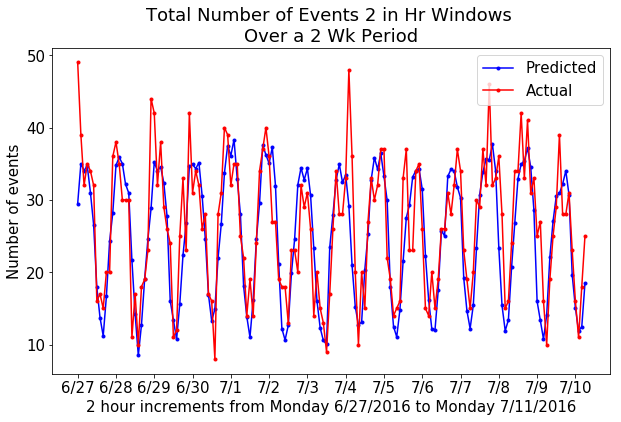

In [51]:
plt.rcParams.update({'font.size': 15, 'text.color' : "black",
                     'axes.labelcolor' : "black"})

fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

ax.plot(pred_num_2h, 'b.-', label="Predicted")
ax.plot(real_num_2h, 'r.-', label="Actual")
plt.legend()
#plt.xlabel("2 hour increments from " + str(week_lookup[full_data.DATE_TIME[indices[0]].weekday()])+ " to " +str(week_lookup[full_data.DATE_TIME[indices[max_iters]].weekday()]))
plt.xlabel("2 hour increments from Monday 6/27/2016 to Monday 7/11/2016")
plt.ylabel("Number of events")
plt.title("Total Number of Events 2 in Hr Windows \nOver a 2 Wk Period")
plt.xticks(range(len(pred_num_2h)), dt_smlr, rotation=0)

plt.locator_params(axis='x', nbins=nbins)

plt.show()

In [52]:
tosave = ax.get_figure()
tosave.savefig('Following.png', pad_inches = -1)

In [154]:
pred_num_2h = array(pred_num_2h)
real_num_2h = array(real_num_2h)
percentile_2h = array(percentile_2h)
np.mean(percentile_2h), np.percentile(pred_num_2h, percentile), np.percentile(real_num_2h, percentile)

(32.08869488665213, 32.75086680025503, 34.0)

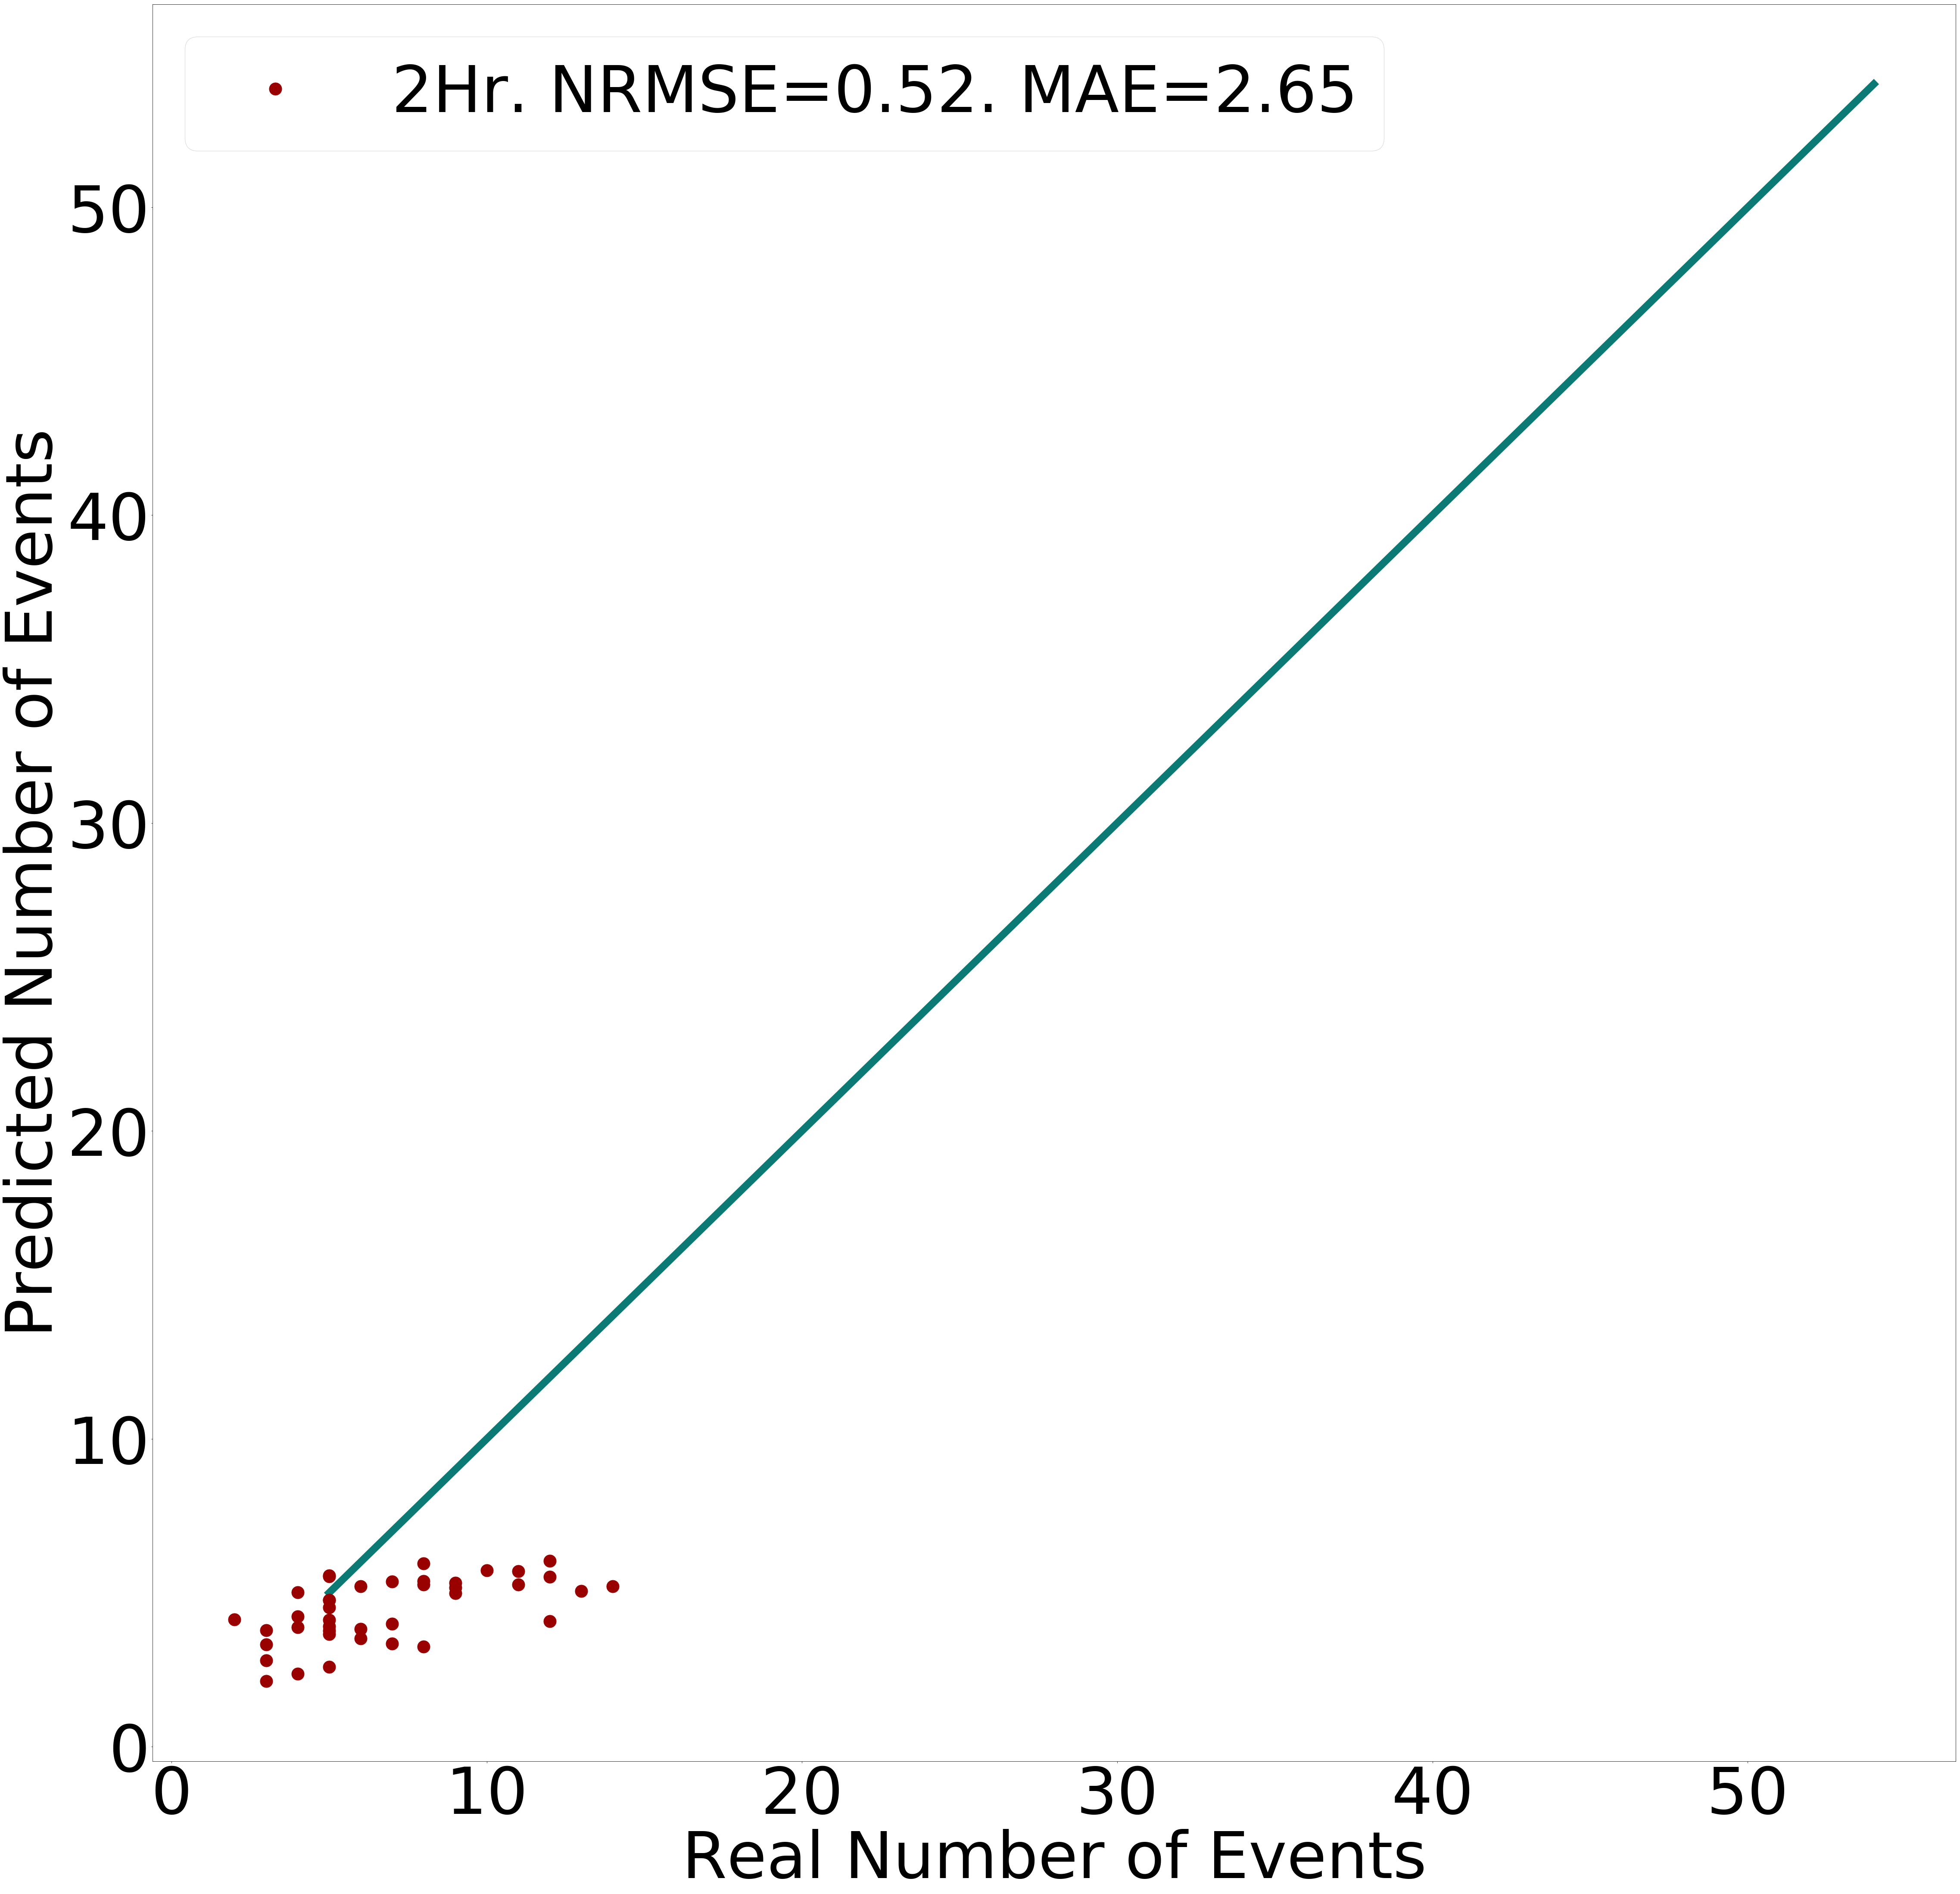

In [39]:
import sklearn.metrics
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))

mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)

plt.rcParams.update({'font.size': 150, 'text.color' : "black",
                     'axes.labelcolor' : "black"})


fig = plt.figure(figsize=(75,75))
ax = plt.subplot()
x = np.arange(5, 55)
ax.plot(x, x, color=[11/255,122/255,117/255], linewidth=17.0)
ax.plot(real_num_2h, pred_num_2h, color = [153/255,1/255,0], marker=".",linestyle="", label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=58)
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()


In [167]:
import sklearn.metrics

st_indx =0
pred = pred_num_2h[st_indx:] - percentile_2h[st_indx:]
neg_indx = pred < 0
pred[neg_indx] = 0
pos_indx = pred > 0
pred[pos_indx] = 1


real = real_num_2h[st_indx:] - np.percentile(real_num_2h, percentile)
neg_indx = real < 0
real[neg_indx] = 0
pos_indx = real > 0
real[pos_indx] = 1


sklearn.metrics.roc_auc_score(pred, real)

0.6472769654587835

In [ ]:
num_events_in_top_percentile = 0
false_neg = 0
true_neg = 0
false_pos = 0
true_pos = 0

for i in range(0, len(real)):
    if real[i]:
        num_events_in_top_percentile += 1
    if real[i] and pred[i]:
        true_pos += 1
    elif real[i] and not pred[i]:
        false_neg += 1
    elif not real[i] and not pred[i]:
        true_neg +=1
    elif not real[i] and pred[i]:
        false_pos +=1
print("\nTot num top percentile events: ")
print(num_events_in_top_percentile)
print('\nTrue pos: ')
print(true_pos)
print("\nFalse neg: ")
print(false_neg)
print("\nFalse pos: ")
print(false_pos)
print("\nTrue neg: ")
print(true_neg)

### Checking Wasserstein

In [ ]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
start_time = simulation._LastTime
num = 300
future_intensity, times, incr = simulation.get_future_events(start_time, num, 0)
future_intensity = sum(future_intensity)
wasserstein_locs = simulation.locs_for_wasserstein(start_time, num, top_percent=96)


In [ ]:
wasserstein_locs

In [ ]:
cluster = Cluster(wasserstein_locs, n = 6)
cluster.randomize_centers()
lam = cluster.learn_lam(n_iter=8, rand_centers=False)
centers= cluster.get_centers()
centers_grid_x = np.zeros(len(centers))
centers_grid_y = np.zeros(len(centers))

for i in range(0, len(centers)):
    x, y = simulation.coord_to_grid(centers[i][1], centers[i][0])
    centers_grid_x[i] = x
    centers_grid_y[i] = y
centers_grid_x, centers_grid_y

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(future_intensity),cmap='hot', interpolation = 'nearest')
plt.title('Future predictions over 4 hours')
plt.plot(centers_grid_x, centers_grid_y, 'g.', markersize = 20)
plt.colorbar()
plt.show()

In [19]:
test_changing = PointProcessRun(param_location = save_loc_out)
test_points = full_data[end+200:end+300]
test_points.reset_index(inplace=True, drop=True)
test_changing.update_from_new_inputs(test_points)

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


'Parameters updated: 100 used for update ranging from: 2016-06-27 20:56:19 to 2016-06-28 05:26:48. Params also saved.'